# Particle collisions to cylinder (disc) in inviscid flow field


This Python notebook calculates particle trajectories and hence collisions in 2D, for particles in inviscid incompressible flow field around a long cylinder perpendicular to flow field. Cylinder axis is along $z$, flow far from the cylinder is uniform at $U$ along $x$ axis. Cylinder axis is $(0,0)$ so $y$ is displacement from cylinder axis.

It contains the numerics needed for all the calculations for all the figures for: *Critical scaling law for the deposition efficiency of inertia-driven particle collisions with a cylinder in high Reynolds number air flow* by Matthew Turner and Richard Sear.

Re-use as you wish but we make no guarantees as to correctness.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from math import floor
import os
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import simps

Inviscid, incompressible flow around a disc (or cylinder), i.e., in two dimensions. $r=1$

obstacle radius  1.0

disc centre at x, y  0.0 0.0


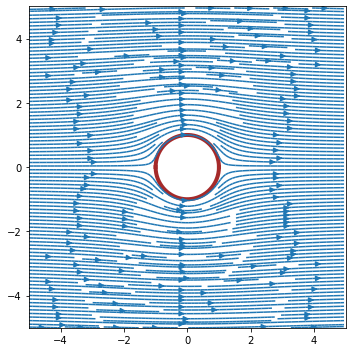

In [2]:

radius_cylinder=1.0
print('obstacle radius ',radius_cylinder)

print('')
cx=0.0
cy=0.0
print('disc centre at x, y ',cx,cy)
#
'''
flow field
'''
def u_ffinviscid(x,y):
    dx=x-cx
    dy=y-cy
    if(dx**2+dy**2 > 1.0): #and rr < outer_boundary ):
# outside fibre
        r4=(dx**2+dy**2)**2
        ux=1.0+(dy**2-dx**2)/r4
        uy=-2.0*dx*dy/r4
#
#        delta=-1.0-x
#        if(delta < 1.0e-2):
#            print(x,delta)
#            ux=2.0*delta
#            uy=0.0
    else:
# inside fibre
        ux = 0.0
        uy = 0.0
    return ux,uy


#
npts=1000
x_circle=np.linspace(-1,1,npts)
y_circle=np.sqrt(1-x_circle**2)
nx=200
ny=200
xs=np.zeros((nx,ny))
ys=np.zeros((nx,ny))
us=np.zeros((nx,ny))
vs=np.zeros((nx,ny))
for ix in range(0,nx):
    for iy in range(0,ny):
#            xs[ix,iy]=cx+outer_boundary*2.0*float(ix-250)/float(nx)
#            ys[ix,iy]=cy+outer_boundary*2.0*float(iy-250)/float(ny)
        xs[ix,iy]=-5.0+10.0*float(ix)/float(nx)
        ys[ix,iy]=-5+10.0*float(iy)/float(ny)
        vs[ix,iy],us[ix,iy]=u_ffinviscid(ys[ix,iy],xs[ix,iy])
#
plt.figure(figsize=(5,5))#,dpi=250)
plt.plot(x_circle,y_circle,lw=4,color='brown')
plt.plot(x_circle,-y_circle,lw=4,color='brown')
plt.streamplot(ys,xs,vs,us,density=3)
#plt.xticks(())
plt.xlim([-5,5])
plt.ylim([-5,5])
#plt.yticks(())
plt.tight_layout()
plt.show()
#
uBC=1.0

This sets up Scipy's solve_ivp to solve the ODEs for the particl trajectories

In [3]:


def fderivs(t,array_var):    
    x=array_var[0]
    y=array_var[1]
    vx=array_var[2]
    vy=array_var[3]
# get flow field velocity
    usfp,vsfp=u_ffinviscid(x,y)
#
    dvxdt=-(vx-usfp)/Stokes
    dvydt=-(vy-vsfp)/Stokes
    return vx,vy,dvxdt,dvydt
#

def escape(t,array_var):
    x=array_var[0]
    y=array_var[1]
    tolerance=1.0e-06
    xSTAG_sq=x**2+y**2-1.0-tolerance
    return xSTAG_sq

escape.terminal = True
#

t_max= 40.0
t_eval = np.linspace(0.0, t_max, 10001)
x0=-10.0
y0=0.0000
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
Stokes=0.1255
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],atol=1.0e-12,rtol=1.0e-12,method='RK45',max_step=1e-2)#,dense_output=True)
print(sol0)
x_traj=sol0.y[0,:]
t_traj=sol0.t[:]

#plt.plot(t_traj,-1-x_traj)

initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
  message: 'A termination event occurred.'
     nfev: 8954
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.0000e+00, 4.0000e-03, 8.0000e-03, ..., 1.3760e+01, 1.3764e+01,
       1.3768e+01])
 t_events: [array([13.77062083])]
        y: array([[-1.00000000e+01, -9.99604000e+00, -9.99208000e+00, ...,
        -1.00000052e+00, -1.00000051e+00, -1.00000051e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.90000000e-01,  9.89999875e-01,  9.89999505e-01, ...,
         1.97651394e-06,  1.94692368e-06,  1.91777307e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
 y_events: [array([[-1.00000050e+00,  0.00000000e+00,  1.89890863e-06,
         0.00000000e+00]])]


Function to find deposition efficiency $\eta_d$ at given Stokes number. Uses bisection to bracket edge of region where particles do and do not collide with cylinder surface.

In [4]:
def root_find():
    n_traj=24
    ymin=cy
    ymax=ymin+radius_cylinder
#    print('starting with ys','{:9.3f}'.format(ymin), \
#          '{:9.3f}'.format(ymax), \
#          ' which should bracket edge of coll zone')
#
    x_collide=0.0
    y_collide=0.0
    t_collide=0.0
    for i_traj in range(0,n_traj):
# starting position and velocity
        ytry=0.5*(ymin+ymax)
#
        t_max= 30.0
        t_eval = np.linspace(0.0, t_max, 10001)
        x0=-10.0
        y0=ytry
        dxdt0,dydt0=u_ffinviscid(x0,y0)
        initialBC_array=np.array([x0,y0,dxdt0,dydt0])
        sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],method='RK45',rtol=1.0e-13,atol=1.0e-13)#,max_step=1e-3)
        if(sol0.status == 1):
# particle has collided
            penetrated=False
            ymin=ytry
            print('missed initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
# add collision point
            x_collide=sol0.y[0,-1]
            y_collide=sol0.y[1,-1]
            t_collide=sol0.t[-1]
            print('collided t ',t_collide,'initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
        else:
            penetrated=True
            ymax=ytry
# now return
    return ymin,ymax,x_collide,y_collide,t_collide


Calculate $\eta_d$ for given Stokes number

In [5]:
Stokes=0.7
#t0Stokes=Stokes*radius_cylinder/uBC
print('Stokes number ',Stokes)


#
ymin,ymax,x_collide,y_collide,t_collide=root_find()
#
print('edge of collision region between ',ymin,' and ',ymax)
width_collzone=(ymax+ymin)
print('width coll zone divided by diameter                    ', \
          '{:9.3f}'.format(width_collzone/2.0), ' units so radius = 1')
efficiency=width_collzone/(2.0*radius_cylinder)
print('')
print('time to collide ',t_collide)


Stokes number  0.7
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  10.02 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.28125 0.9900236992180749 0.0005616111621877542
collided t  10.203 initial conditions x,y,v_x,v_y  -10.0 0.28125 0.9900236992180749 0.0005616111621877542
missed initial conditions x,y,v_x,v_y  -10.0 0.281280517578125 0.9900237043546372 0.0005616719082061272
collided t  10.206 initial conditions x,y,v_x,v_y  -10.0 0.281280517578125 0.9900237043546372 0.0005616719082061272
missed initial conditions x,y,v_x,v_y  -10.0 0.28128814697265625 0.9900237056388644 0.0005616870947009358
collided t  10.209 initial conditions x,y,v_x,v_y  -10.0 0.28128814697265625 0.9900237056388644 0.0005616870947009358
missed initial conditions x,y,v_x,v_y  -10.0 0.2812919616699219 0.990023706280991 0.0005616946879468726
collided t  10.209 initial conditions x,y,v_x,

Stokes number  0.7
initial conditions x,y,v_x,v_y  -20.0 0.4 0.9975029980011194 9.992004797441278e-05
initial conditions x,y,v_x,v_y  -20.0 0.2793 0.9975014621839013 6.979777325087857e-05
initial conditions x,y,v_x,v_y  -20.0 0.1 0.9975001874921878 2.4998750046873436e-05


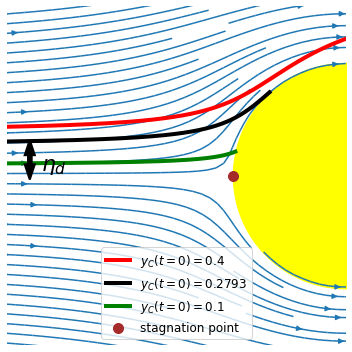

In [6]:
Stokes=0.7

print('Stokes number ',Stokes)

t_max= 30.0
t_eval = np.linspace(0.0, t_max, 10001)
x0=-20.0



plt.figure(figsize=(5,5))

plt.streamplot(ys,xs,vs,us,density=4)



#plt.plot(x_circle,y_circle,lw=5,color='brown')
#plt.plot(x_circle,-y_circle,lw=5,color='brown')
plt.fill_between(x_circle,-y_circle,y_circle,color='yellow')
#




y0=0.4
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='DOP853',max_step=1e-3)
xtraj=sol0.y[0,:]
ytraj=sol0.y[1,:]
plt.plot(xtraj,ytraj,label='$y_C(t=0)=0.4$',lw=4,color='red')


####

y0=0.2793
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='DOP853',max_step=1e-3)
xtraj=sol0.y[0,:]
ytraj=sol0.y[1,:]
plt.plot(xtraj,ytraj,lw=4,color='black',label='$y_C(t=0)=0.2793$')


##

y0=0.1
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='DOP853',max_step=1e-3)
xtraj=sol0.y[0,:]
ytraj=sol0.y[1,:]
plt.plot(xtraj,ytraj,label='$y_C(t=0)=0.1$',lw=4,color='green')


plt.xlim([-3.0,-0.0])
plt.ylim([-1.5,1.5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks([])
plt.yticks([])
#

plt.arrow(-2.8,0.03,0.0,0.281-0.13,lw=2,width=0.03,zorder=9,color='black')
plt.arrow(-2.8,0.281-0.1,0.0,-0.281+0.2,lw=2,width=0.03,zorder=9,color='black')
plt.scatter([-1.0],[0.0],s=100,color='brown',label='stagnation point')
plt.text(-2.7, 0.05, '$\eta_d$',fontsize=22,zorder=9)
#
plt.axis('off')

plt.tight_layout()
plt.legend(fontsize=12)

plt.savefig('cylinder+collision.png',dpi=1200)
plt.show()





Stokes number  0.7
initial conditions x,y,v_x,v_y  -20.0 0.4 0.9975029980011194 9.992004797441278e-05
initial conditions x,y,v_x,v_y  -20.0 0.2793 0.9975014621839013 6.979777325087857e-05
initial conditions x,y,v_x,v_y  -20.0 0.1 0.9975001874921878 2.4998750046873436e-05


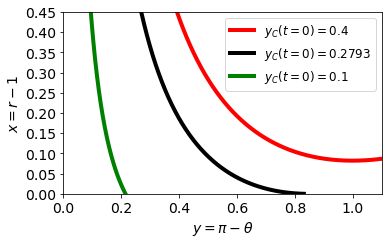

In [7]:
Stokes=0.7
#t0Stokes=Stokes*radius_cylinder/uBC
print('Stokes number ',Stokes)


#
plt.figure(figsize=(5.5,3.5))

y0=0.4
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='DOP853',max_step=1e-3)
xtraj=sol0.y[0,:]
ytraj=sol0.y[1,:]
r=np.sqrt(xtraj**2+ytraj**2)
theta=np.arcsin(-ytraj/r)+np.pi
xSTAG=r-1.0
ySTAG=np.pi-theta
plt.plot(ySTAG,xSTAG,label='$y_C(t=0)=0.4$',lw=4,color='red')


y0=0.2793
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='DOP853',max_step=1e-3)
xtraj=sol0.y[0,:]
ytraj=sol0.y[1,:]
r=np.sqrt(xtraj**2+ytraj**2)
theta=np.arcsin(-ytraj/r)+np.pi
xSTAG=r-1.0
ySTAG=np.pi-theta
plt.plot(ySTAG,xSTAG,lw=4,color='black',label='$y_C(t=0)=0.2793$')


y0=0.1
dxdt0,dydt0=u_ffinviscid(x0,y0)
initialBC_array=np.array([x0,y0,dxdt0,dydt0])
print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='DOP853',max_step=1e-3)
xtraj=sol0.y[0,:]
ytraj=sol0.y[1,:]
r=np.sqrt(xtraj**2+ytraj**2)
theta=np.arcsin(-ytraj/r)+np.pi
xSTAG=r-1.0
ySTAG=np.pi-theta
plt.plot(ySTAG,xSTAG,label='$y_C(t=0)=0.1$',lw=4,color='green')


plt.xlim([0.0,1.1])
plt.ylim([0,0.45])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$y=\pi-\\theta$",fontsize=14)
plt.ylabel("$x=r-1$",fontsize=14)



plt.tight_layout()
plt.legend(fontsize=12)

plt.savefig('cylinder+collision_xy.png',dpi=1200)
plt.show()






Stokes number  0.25
mu_2  -5.464101615137754
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
near so x,y expansion switch  3312 1.099496017941135 0.0 0
initial conditions x,y,v_x,v_y  -10.0 0.0006896551724137932 0.9900000001426873 1.3793103317069171e-06
near so x,y expansion switch  3312 1.0994964357448316 0.00173621073094532 1
initial conditions x,y,v_x,v_y  -10.0 0.0013793103448275863 0.9900000005707491 2.7586205846898222e-06
near so x,y expansion switch  3312 1.0994976891529609 0.0034724154626015746 2
initial conditions x,y,v_x,v_y  -10.0 0.0020689655172413794 0.9900000012841854 4.137930680224714e-06
near so x,y expansion switch  3312 1.0994997781567248 0.00520860819579072 3
initial conditions x,y,v_x,v_y  -10.0 0.0027586206896551726 0.9900000022829961 5.5172405395876165e-06
near so x,y expansion switch  3312 1.099502702741421 0.0069447829315549825 4
initial conditions x,y,v_x,v_y  -10.0 0.003448275862068966 0.9900000035671812 6.896550084054582e-06
near so x,y expansion switch  3

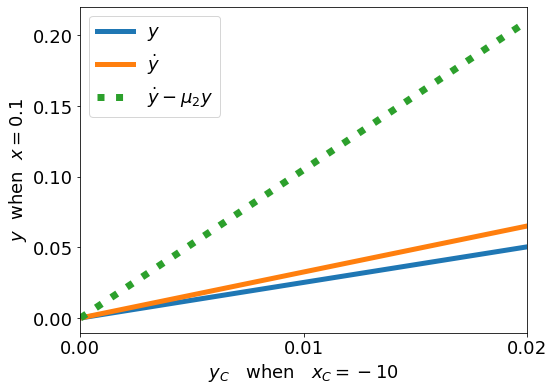

In [8]:
Stokes=0.25
#t0Stokes=Stokes*radius_cylinder/uBC
print('Stokes number ',Stokes)

mu2=(-1.0-np.sqrt(1.0+8.0*Stokes))/(2.0*Stokes)
print('mu_2 ',mu2)
#
n_ptsSWITCH=30
yC0=np.linspace(0,0.02,n_ptsSWITCH)
ySTAGX=np.zeros(n_ptsSWITCH)
vthetaX=np.zeros(n_ptsSWITCH)
for it in range(0,n_ptsSWITCH):
    y0=yC0[it]
    x0=-10.0
    dxdt0,dydt0=u_ffinviscid(x0,y0)
    initialBC_array=np.array([x0,y0,dxdt0,dydt0])
    print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
    sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-11,atol=1.0e-11,max_step=1e-2)
    xtraj=sol0.y[0,:]
    ytraj=sol0.y[1,:]
    vxtraj=sol0.y[2,:]
    vytraj=sol0.y[3,:]
    r=np.sqrt(xtraj**2+ytraj**2)
    theta=np.arcsin(-ytraj/r)+np.pi
    vtheta=(-vxtraj*np.sin(theta)+vytraj*np.cos(theta))/r
    i_close=0
    for i in range(0,len(r)):
        if(r[i]<1.0+0.1):
            i_close=i
            ySTAGX[it]=np.pi-theta[i]
            vthetaX[it]=vtheta[i]
            print('near so x,y expansion switch ',i,r[i],ySTAGX[it],it)
            break
#
plt.figure(figsize=(8,6))
plt.plot(yC0,ySTAGX,label='$y$',lw=5)
plt.plot(yC0,-vthetaX,label='$\dot{y}$',lw=5)
plt.plot(yC0,vthetaX-mu2*ySTAGX,label='$\dot{y}-\mu_2y$',ls=':',lw=7)

plt.legend(fontsize=18)
plt.xlim([0.0,0.02])
plt.xlabel('$y_C$   when   $x_C=-10$',fontsize=18)
#plt.savefig('invis.png')
#plt.ylim([1e-3,5])
plt.ylabel('$y$  when  $x=0.1$',fontsize=18)
plt.xticks([0.0,0.01,0.02],fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('BCcheck2.png',dpi=1200)
plt.show()

Now compute $\eta_d$ as a function of $\delta$.

It is worth noting that solve_ivp struggles at small $\delta\lesssim 0.005$, and its results can become unreliable here.

In [9]:
n_plot=800
#Stokes_plot=np.linspace(0.135,0.4,n_plot)
Stokes_plot=np.linspace(0.135,10.0,n_plot)
width_plot=np.zeros(n_plot)
x_col=np.zeros(n_plot)
y_col=np.zeros(n_plot)
t_col=np.zeros(n_plot)
for i in range(0,n_plot):
    Stokes=Stokes_plot[i]
#
    ymin,ymax,x_col[i],y_col[i],t_col[i]=root_find()
    width_collzone=(ymax+ymin)/2.0
    print('width coll zone divided by diameter          ', \
          '{:10.7f}'.format(width_collzone/2.0), ' units so radius = 1 at Stokes ',round(Stokes,3))
    width_plot[i]=width_collzone
print('done')

missed initial conditions x,y,v_x,v_y  -10.0 7.62939453125e-06 0.9900000000000174 1.5258789062482236e-08
collided t  12.84 initial conditions x,y,v_x,v_y  -10.0 7.62939453125e-06 0.9900000000000174 1.5258789062482236e-08
missed initial conditions x,y,v_x,v_y  -10.0 1.1444091796875e-05 0.9900000000000393 2.2888183593690046e-08
collided t  12.879 initial conditions x,y,v_x,v_y  -10.0 1.1444091796875e-05 0.9900000000000393 2.2888183593690046e-08
missed initial conditions x,y,v_x,v_y  -10.0 1.33514404296875e-05 0.9900000000000535 2.67028808592798e-08
collided t  12.93 initial conditions x,y,v_x,v_y  -10.0 1.33514404296875e-05 0.9900000000000535 2.67028808592798e-08
missed initial conditions x,y,v_x,v_y  -10.0 1.3589859008789062e-05 0.9900000000000554 2.7179718017477733e-08
collided t  12.951 initial conditions x,y,v_x,v_y  -10.0 1.3589859008789062e-05 0.9900000000000554 2.7179718017477733e-08
missed initial conditions x,y,v_x,v_y  -10.0 1.3649463653564453e-05 0.990000000000056 2.7298927307

missed initial conditions x,y,v_x,v_y  -10.0 0.007966279983520508 0.9900000190384649 1.5932539744939968e-05
collided t  11.202 initial conditions x,y,v_x,v_y  -10.0 0.007966279983520508 0.9900000190384649 1.5932539744939968e-05
width coll zone divided by diameter            0.0039832  units so radius = 1 at Stokes  0.184
missed initial conditions x,y,v_x,v_y  -10.0 0.0078125 0.9900000183105282 1.5624980926531135e-05
collided t  10.932 initial conditions x,y,v_x,v_y  -10.0 0.0078125 0.9900000183105282 1.5624980926531135e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.01171875 0.9900000411986362 2.3437435627116248e-05
collided t  11.001 initial conditions x,y,v_x,v_y  -10.0 0.01171875 0.9900000411986362 2.3437435627116248e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.01220703125 0.9900000447033726 2.441398974058649e-05
collided t  11.022 initial conditions x,y,v_x,v_y  -10.0 0.01220703125 0.9900000447033726 2.441398974058649e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.0124

width coll zone divided by diameter            0.0152605  units so radius = 1 at Stokes  0.234
missed initial conditions x,y,v_x,v_y  -10.0 0.03125 0.9900002929639817 6.249877931475616e-05
collided t  10.644 initial conditions x,y,v_x,v_y  -10.0 0.03125 0.9900002929639817 6.249877931475616e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.03515625 0.9900003707809364 7.031076196078067e-05
collided t  10.686 initial conditions x,y,v_x,v_y  -10.0 0.03515625 0.9900003707809364 7.031076196078067e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.037109375 0.990000413122232 7.421670590093163e-05
collided t  10.734 initial conditions x,y,v_x,v_y  -10.0 0.037109375 0.990000413122232 7.421670590093163e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.037353515625 0.9900004185758049 7.470494654143603e-05
collided t  10.752 initial conditions x,y,v_x,v_y  -10.0 0.037353515625 0.9900004185758049 7.470494654143603e-05
missed initial conditions x,y,v_x,v_y  -10.0 0.037384033203125 0.99000041926001

missed initial conditions x,y,v_x,v_y  -10.0 0.059467315673828125 0.9900010608459638 0.0001189262198765052
collided t  10.632 initial conditions x,y,v_x,v_y  -10.0 0.059467315673828125 0.9900010608459638 0.0001189262198765052
missed initial conditions x,y,v_x,v_y  -10.0 0.05946826934814453 0.9900010608799876 0.00011892812682046283
collided t  10.632 initial conditions x,y,v_x,v_y  -10.0 0.05946826934814453 0.9900010608799876 0.00011892812682046283
missed initial conditions x,y,v_x,v_y  -10.0 0.059468746185302734 0.9900010608969997 0.00011892908029243679
collided t  10.632 initial conditions x,y,v_x,v_y  -10.0 0.059468746185302734 0.9900010608969997 0.00011892908029243679
missed initial conditions x,y,v_x,v_y  -10.0 0.059468865394592285 0.9900010609012527 0.00011892931866042978
collided t  10.632 initial conditions x,y,v_x,v_y  -10.0 0.059468865394592285 0.9900010609012527 0.00011892931866042978
missed initial conditions x,y,v_x,v_y  -10.0 0.05946892499923706 0.9900010609033792 0.000118

missed initial conditions x,y,v_x,v_y  -10.0 0.08984375 0.9900024212440832 0.00017965849512339464
collided t  10.491 initial conditions x,y,v_x,v_y  -10.0 0.08984375 0.9900024212440832 0.00017965849512339464
missed initial conditions x,y,v_x,v_y  -10.0 0.090087890625 0.9900024344191153 0.00018014653929674602
collided t  10.506 initial conditions x,y,v_x,v_y  -10.0 0.090087890625 0.9900024344191153 0.00018014653929674602
missed initial conditions x,y,v_x,v_y  -10.0 0.090118408203125 0.9900024360685068 0.00018020754472791028
collided t  10.512 initial conditions x,y,v_x,v_y  -10.0 0.090118408203125 0.9900024360685068 0.00018020754472791028
missed initial conditions x,y,v_x,v_y  -10.0 0.09012222290039062 0.99000243627472 0.00018021517040539025
collided t  10.512 initial conditions x,y,v_x,v_y  -10.0 0.09012222290039062 0.99000243627472 0.00018021517040539025
missed initial conditions x,y,v_x,v_y  -10.0 0.09012413024902344 0.9900024363778299 0.0001802189832440122
collided t  10.515 initial

missed initial conditions x,y,v_x,v_y  -10.0 0.11295413970947266 0.9900038267775344 0.00022585064481155684
collided t  10.449 initial conditions x,y,v_x,v_y  -10.0 0.11295413970947266 0.9900038267775344 0.00022585064481155684
width coll zone divided by diameter            0.0564771  units so radius = 1 at Stokes  0.37
missed initial conditions x,y,v_x,v_y  -10.0 0.0625 0.9900011717987103 0.0001249902349471748
collided t  10.200000000000001 initial conditions x,y,v_x,v_y  -10.0 0.0625 0.9900011717987103 0.0001249902349471748
missed initial conditions x,y,v_x,v_y  -10.0 0.09375 0.9900026363325595 0.00018746704536029446
collided t  10.254 initial conditions x,y,v_x,v_y  -10.0 0.09375 0.9900026363325595 0.00018746704536029446
missed initial conditions x,y,v_x,v_y  -10.0 0.109375 0.9900035881517536 0.00021869767174366095
collided t  10.308 initial conditions x,y,v_x,v_y  -10.0 0.109375 0.9900035881517536 0.00021869767174366095
missed initial conditions x,y,v_x,v_y  -10.0 0.1171875 0.9900041

missed initial conditions x,y,v_x,v_y  -10.0 0.1416015625 0.9900060132911014 0.00028308958901743366
collided t  10.35 initial conditions x,y,v_x,v_y  -10.0 0.1416015625 0.9900060132911014 0.00028308958901743366
missed initial conditions x,y,v_x,v_y  -10.0 0.14208984375 0.9900060548196007 0.00028406497319087863
collided t  10.362 initial conditions x,y,v_x,v_y  -10.0 0.14208984375 0.9900060548196007 0.00028406497319087863
missed initial conditions x,y,v_x,v_y  -10.0 0.142333984375 0.9900060756373864 0.0002845526622335009
collided t  10.374 initial conditions x,y,v_x,v_y  -10.0 0.142333984375 0.9900060756373864 0.0002845526622335009
missed initial conditions x,y,v_x,v_y  -10.0 0.14239501953125 0.9900060808474095 0.0002846745841764733
collided t  10.38 initial conditions x,y,v_x,v_y  -10.0 0.14239501953125 0.9900060808474095 0.0002846745841764733
missed initial conditions x,y,v_x,v_y  -10.0 0.1424102783203125 0.9900060821502638 0.00028470506464234633
collided t  10.383000000000001 initial

width coll zone divided by diameter            0.0817882  units so radius = 1 at Stokes  0.456
missed initial conditions x,y,v_x,v_y  -10.0 0.125 0.9900046862795638 0.0002499218933067329
collided t  10.119 initial conditions x,y,v_x,v_y  -10.0 0.125 0.9900046862795638 0.0002499218933067329
missed initial conditions x,y,v_x,v_y  -10.0 0.15625 0.990007321239536 0.0003123474679705451
collided t  10.203 initial conditions x,y,v_x,v_y  -10.0 0.15625 0.990007321239536 0.0003123474679705451
missed initial conditions x,y,v_x,v_y  -10.0 0.1640625 0.9900080713300455 0.00032794843173531866
collided t  10.245000000000001 initial conditions x,y,v_x,v_y  -10.0 0.1640625 0.9900080713300455 0.00032794843173531866
missed initial conditions x,y,v_x,v_y  -10.0 0.16796875 0.9900084600718563 0.00033574802073218645
collided t  10.278 initial conditions x,y,v_x,v_y  -10.0 0.16796875 0.9900084600718563 0.00033574802073218645
missed initial conditions x,y,v_x,v_y  -10.0 0.169921875 0.9900086578663867 0.0003396

missed initial conditions x,y,v_x,v_y  -10.0 0.19039344787597656 0.99001086833264 0.0003805109778418897
collided t  10.308 initial conditions x,y,v_x,v_y  -10.0 0.19039344787597656 0.99001086833264 0.0003805109778418897
missed initial conditions x,y,v_x,v_y  -10.0 0.19039368629455566 0.9900108683598431 0.00038051145364287456
collided t  10.308 initial conditions x,y,v_x,v_y  -10.0 0.19039368629455566 0.9900108683598431 0.00038051145364287456
missed initial conditions x,y,v_x,v_y  -10.0 0.19039374589920044 0.9900108683666439 0.0003805115725931205
collided t  10.308 initial conditions x,y,v_x,v_y  -10.0 0.19039374589920044 0.9900108683666439 0.0003805115725931205
width coll zone divided by diameter            0.0951969  units so radius = 1 at Stokes  0.505
missed initial conditions x,y,v_x,v_y  -10.0 0.125 0.9900046862795638 0.0002499218933067329
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.125 0.9900046862795638 0.0002499218933067329
missed initial conditions x,y,v_x,v_y  

missed initial conditions x,y,v_x,v_y  -10.0 0.21533203125 0.9900138996221757 0.0004302649604810639
collided t  10.257 initial conditions x,y,v_x,v_y  -10.0 0.21533203125 0.9900138996221757 0.0004302649604810639
missed initial conditions x,y,v_x,v_y  -10.0 0.215576171875 0.9900139311340472 0.0004307518833331159
collided t  10.269 initial conditions x,y,v_x,v_y  -10.0 0.215576171875 0.9900139311340472 0.0004307518833331159
missed initial conditions x,y,v_x,v_y  -10.0 0.215606689453125 0.9900139350755341 0.0004308127484733641
collided t  10.272 initial conditions x,y,v_x,v_y  -10.0 0.215606689453125 0.9900139350755341 0.0004308127484733641
missed initial conditions x,y,v_x,v_y  -10.0 0.21561431884765625 0.9900139360609927 0.0004308279647509139
collided t  10.272 initial conditions x,y,v_x,v_y  -10.0 0.21561431884765625 0.9900139360609927 0.0004308279647509139
missed initial conditions x,y,v_x,v_y  -10.0 0.21561622619628906 0.9900139363073628 0.00043083176881983186
collided t  10.275 init

missed initial conditions x,y,v_x,v_y  -10.0 0.23352962732315063 0.9900163459664736 0.00046655023939824047
collided t  10.254 initial conditions x,y,v_x,v_y  -10.0 0.23352962732315063 0.9900163459664736 0.00046655023939824047
width coll zone divided by diameter            0.1167648  units so radius = 1 at Stokes  0.592
missed initial conditions x,y,v_x,v_y  -10.0 0.125 0.9900046862795638 0.0002499218933067329
collided t  9.939 initial conditions x,y,v_x,v_y  -10.0 0.125 0.9900046862795638 0.0002499218933067329
missed initial conditions x,y,v_x,v_y  -10.0 0.1875 0.9900105406982307 0.0003747364671055663
collided t  10.017 initial conditions x,y,v_x,v_y  -10.0 0.1875 0.9900105406982307 0.0003747364671055663
missed initial conditions x,y,v_x,v_y  -10.0 0.21875 0.990014344027555 0.000437081599169073
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.21875 0.990014344027555 0.000437081599169073
missed initial conditions x,y,v_x,v_y  -10.0 0.234375 0.9900164644163565 0.000468235439892

missed initial conditions x,y,v_x,v_y  -10.0 0.256134033203125 0.9900196598927922 0.00051159658399196
collided t  10.23 initial conditions x,y,v_x,v_y  -10.0 0.256134033203125 0.9900196598927922 0.00051159658399196
missed initial conditions x,y,v_x,v_y  -10.0 0.2561378479003906 0.9900196604777605 0.0005116041834038179
collided t  10.23 initial conditions x,y,v_x,v_y  -10.0 0.2561378479003906 0.9900196604777605 0.0005116041834038179
missed initial conditions x,y,v_x,v_y  -10.0 0.25613975524902344 0.990019660770248 0.0005116079831094125
collided t  10.233 initial conditions x,y,v_x,v_y  -10.0 0.25613975524902344 0.990019660770248 0.0005116079831094125
missed initial conditions x,y,v_x,v_y  -10.0 0.25614070892333984 0.9900196609164925 0.0005116098829621263
collided t  10.233 initial conditions x,y,v_x,v_y  -10.0 0.25614070892333984 0.9900196609164925 0.0005116098829621263
width coll zone divided by diameter            0.1280704  units so radius = 1 at Stokes  0.641
missed initial conditio

missed initial conditions x,y,v_x,v_y  -10.0 0.2722001075744629 0.9900222004492265 0.0005435943870531902
collided t  10.218 initial conditions x,y,v_x,v_y  -10.0 0.2722001075744629 0.9900222004492265 0.0005435943870531902
missed initial conditions x,y,v_x,v_y  -10.0 0.272200345993042 0.9900222004880691 0.0005435948617744528
collided t  10.218 initial conditions x,y,v_x,v_y  -10.0 0.272200345993042 0.9900222004880691 0.0005435948617744528
width coll zone divided by diameter            0.1361002  units so radius = 1 at Stokes  0.678
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.265625 0.9900211421255549 0.0005305011283545415
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.265625 0.9900211421255549 0.0005305011283545415
missed initial conditions x,y,v_x,v_y  -10.0 0.2734375 0.9900224024978331

missed initial conditions x,y,v_x,v_y  -10.0 0.2924957275390625 0.9900256295717536 0.0005839917738967397
collided t  10.200000000000001 initial conditions x,y,v_x,v_y  -10.0 0.2924957275390625 0.9900256295717536 0.0005839917738967397
missed initial conditions x,y,v_x,v_y  -10.0 0.2924995422363281 0.9900256302393218 0.000583999364210994
collided t  10.200000000000001 initial conditions x,y,v_x,v_y  -10.0 0.2924995422363281 0.9900256302393218 0.000583999364210994
missed initial conditions x,y,v_x,v_y  -10.0 0.29250144958496094 0.9900256305731091 0.00058400315936774
collided t  10.200000000000001 initial conditions x,y,v_x,v_y  -10.0 0.29250144958496094 0.9900256305731091 0.00058400315936774
missed initial conditions x,y,v_x,v_y  -10.0 0.29250240325927734 0.9900256307400036 0.0005840050569460174
collided t  10.200000000000001 initial conditions x,y,v_x,v_y  -10.0 0.29250240325927734 0.9900256307400036 0.0005840050569460174
missed initial conditions x,y,v_x,v_y  -10.0 0.29250264167785645 0

missed initial conditions x,y,v_x,v_y  -10.0 0.306949257850647 0.9900282210275304 0.0006127433445963202
collided t  10.191 initial conditions x,y,v_x,v_y  -10.0 0.306949257850647 0.9900282210275304 0.0006127433445963202
width coll zone divided by diameter            0.1534746  units so radius = 1 at Stokes  0.765
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.93 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.28125 0.9900236992180749 0.0005616111621877542
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.28125 0.9900236992180749 0.0005616111621877542
missed initial conditions x,y,v_x,v_y  -10.0 0.296875 0.9900264016388712 0.0005927047816621867
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.296875 0.9900264016388712 0.0005927047816621867
missed initial conditions x,y,v_x,v_y  -10.0 0.3046875 0.9900278073065384 0.000608245153438467
col

missed initial conditions x,y,v_x,v_y  -10.0 0.3203125 0.9900307274709005 0.0006393124566002385
collided t  10.098 initial conditions x,y,v_x,v_y  -10.0 0.3203125 0.9900307274709005 0.0006393124566002385
missed initial conditions x,y,v_x,v_y  -10.0 0.32421875 0.9900314801717954 0.0006470764000723162
collided t  10.14 initial conditions x,y,v_x,v_y  -10.0 0.32421875 0.9900314801717954 0.0006470764000723162
missed initial conditions x,y,v_x,v_y  -10.0 0.3251953125 0.9900316697626382 0.0006490172019431677
collided t  10.17 initial conditions x,y,v_x,v_y  -10.0 0.3251953125 0.9900316697626382 0.0006490172019431677
missed initial conditions x,y,v_x,v_y  -10.0 0.325225830078125 0.9900316756964751 0.0006490778508097669
collided t  10.173 initial conditions x,y,v_x,v_y  -10.0 0.325225830078125 0.9900316756964751 0.0006490778508097669
missed initial conditions x,y,v_x,v_y  -10.0 0.3252410888671875 0.990031678663601 0.0006491081752159506
collided t  10.176 initial conditions x,y,v_x,v_y  -10.0 0

missed initial conditions x,y,v_x,v_y  -10.0 0.338287353515625 0.9900342661241585 0.0006750288394947783
collided t  10.167 initial conditions x,y,v_x,v_y  -10.0 0.338287353515625 0.9900342661241585 0.0006750288394947783
missed initial conditions x,y,v_x,v_y  -10.0 0.3383026123046875 0.9900342692095548 0.0006750591481188735
collided t  10.17 initial conditions x,y,v_x,v_y  -10.0 0.3383026123046875 0.9900342692095548 0.0006750591481188735
missed initial conditions x,y,v_x,v_y  -10.0 0.3383035659790039 0.9900342694023967 0.0006750610424072552
collided t  10.17 initial conditions x,y,v_x,v_y  -10.0 0.3383035659790039 0.9900342694023967 0.0006750610424072552
width coll zone divided by diameter            0.1691518  units so radius = 1 at Stokes  0.851
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.861 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.3125 0.99

missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.834 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.3125 0.990029249256395 0.0006237810826888757
collided t  9.939 initial conditions x,y,v_x,v_y  -10.0 0.3125 0.990029249256395 0.0006237810826888757
missed initial conditions x,y,v_x,v_y  -10.0 0.34375 0.990035379520339 0.0006858781194264003
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.34375 0.990035379520339 0.0006858781194264003
missed initial conditions x,y,v_x,v_y  -10.0 0.3515625 0.9900370026092835 0.0007013901455415378
collided t  10.095 initial conditions x,y,v_x,v_y  -10.0 0.3515625 0.9900370026092835 0.0007013901455415378
missed initial conditions x,y,v_x,v_y  -10.0 0.353515625 0.9900374140339228 0.0007052673567520454
collided t  10.119 initial conditions x,y,v_x,v_y  -10.0 0.353515625 0.9900374140339228 0.0007052673567520454
missed i

missed initial conditions x,y,v_x,v_y  -10.0 0.36283302307128906 0.9900394078445123 0.0007237591657091566
collided t  10.155 initial conditions x,y,v_x,v_y  -10.0 0.36283302307128906 0.9900394078445123 0.0007237591657091566
missed initial conditions x,y,v_x,v_y  -10.0 0.36283349990844727 0.9900394079478654 0.000723760111875247
collided t  10.155 initial conditions x,y,v_x,v_y  -10.0 0.36283349990844727 0.9900394079478654 0.000723760111875247
missed initial conditions x,y,v_x,v_y  -10.0 0.3628336191177368 0.9900394079737037 0.0007237603484167666
collided t  10.155 initial conditions x,y,v_x,v_y  -10.0 0.3628336191177368 0.9900394079737037 0.0007237603484167666
missed initial conditions x,y,v_x,v_y  -10.0 0.3628336787223816 0.9900394079866228 0.0007237604666875259
collided t  10.155 initial conditions x,y,v_x,v_y  -10.0 0.3628336787223816 0.9900394079866228 0.0007237604666875259
width coll zone divided by diameter            0.1814169  units so radius = 1 at Stokes  0.925
missed initial 

missed initial conditions x,y,v_x,v_y  -10.0 0.3740234375 0.9900418703998366 0.0007459583202646918
collided t  10.128 initial conditions x,y,v_x,v_y  -10.0 0.3740234375 0.9900418703998366 0.0007459583202646918
missed initial conditions x,y,v_x,v_y  -10.0 0.374267578125 0.9900419249513216 0.0007464425147105194
collided t  10.14 initial conditions x,y,v_x,v_y  -10.0 0.374267578125 0.9900419249513216 0.0007464425147105194
missed initial conditions x,y,v_x,v_y  -10.0 0.37432861328125 0.9900419385947029 0.0007465635624913927
collided t  10.143 initial conditions x,y,v_x,v_y  -10.0 0.37432861328125 0.9900419385947029 0.0007465635624913927
missed initial conditions x,y,v_x,v_y  -10.0 0.374359130859375 0.99004194541722 0.0007466240862572051
collided t  10.146 initial conditions x,y,v_x,v_y  -10.0 0.374359130859375 0.99004194541722 0.0007466240862572051
missed initial conditions x,y,v_x,v_y  -10.0 0.37436676025390625 0.9900419471229354 0.0007466392171856754
collided t  10.149000000000001 initia

missed initial conditions x,y,v_x,v_y  -10.0 0.3854522705078125 0.9900444618946331 0.0007686189170323518
collided t  10.143 initial conditions x,y,v_x,v_y  -10.0 0.3854522705078125 0.9900444618946331 0.0007686189170323518
missed initial conditions x,y,v_x,v_y  -10.0 0.38545989990234375 0.9900444636503997 0.0007686340402995208
collided t  10.143 initial conditions x,y,v_x,v_y  -10.0 0.38545989990234375 0.9900444636503997 0.0007686340402995208
missed initial conditions x,y,v_x,v_y  -10.0 0.38546180725097656 0.9900444640893467 0.0007686378211154779
collided t  10.143 initial conditions x,y,v_x,v_y  -10.0 0.38546180725097656 0.9900444640893467 0.0007686378211154779
missed initial conditions x,y,v_x,v_y  -10.0 0.38546276092529297 0.990044464308821 0.0007686397115233312
collided t  10.143 initial conditions x,y,v_x,v_y  -10.0 0.38546276092529297 0.990044464308821 0.0007686397115233312
missed initial conditions x,y,v_x,v_y  -10.0 0.38546323776245117 0.9900444644185583 0.0007686406567272265
co

missed initial conditions x,y,v_x,v_y  -10.0 0.3961355686187744 0.9900469541618193 0.0007897904604736916
collided t  10.14 initial conditions x,y,v_x,v_y  -10.0 0.3961355686187744 0.9900469541618193 0.0007897904604736916
missed initial conditions x,y,v_x,v_y  -10.0 0.3961356282234192 0.9900469541759123 0.0007897905785649679
collided t  10.14 initial conditions x,y,v_x,v_y  -10.0 0.3961356282234192 0.9900469541759123 0.0007897905785649679
width coll zone divided by diameter            0.1980678  units so radius = 1 at Stokes  1.036
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.756 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
collided t  9.963000000000001 initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
missed initial conditions x,y,v_x,v_y  -10.0 0.390625 0.990045660200068

missed initial conditions x,y,v_x,v_y  -10.0 0.40625 0.990049375843295 0.0008098247398908894
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.40625 0.990049375843295 0.0008098247398908894
missed initial conditions x,y,v_x,v_y  -10.0 0.408203125 0.9900498504331079 0.0008136922832376102
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.408203125 0.9900498504331079 0.0008136922832376102
missed initial conditions x,y,v_x,v_y  -10.0 0.4091796875 0.9900500885721248 0.0008156259160367382
collided t  10.107000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4091796875 0.9900500885721248 0.0008156259160367382
missed initial conditions x,y,v_x,v_y  -10.0 0.40966796875 0.9900502078526412 0.0008165926976223819
collided t  10.125 initial conditions x,y,v_x,v_y  -10.0 0.40966796875 0.9900502078526412 0.0008165926976223819
missed initial conditions x,y,v_x,v_y  -10.0 0.40972900390625 0.9900502227725962 0.0008167135436866896
collided t  10.128 initial conditions x,y,v_x,v_y  -10.0 

missed initial conditions x,y,v_x,v_y  -10.0 0.4163127541542053 0.9900518450636876 0.0008297468426617888
collided t  10.131 initial conditions x,y,v_x,v_y  -10.0 0.4163127541542053 0.9900518450636876 0.0008297468426617888
width coll zone divided by diameter            0.2081564  units so radius = 1 at Stokes  1.11
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.723 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
collided t  9.897 initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
missed initial conditions x,y,v_x,v_y  -10.0 0.40625 0.990049375843295 0.0008098247398908894
collided t  9.996 initial conditions x,y,v_x,v_y  -10.0 0.40625 0.990049375843295 0.0008098247398908894
missed initial conditions x,y,v_x,v_y  -10.0 0.4140625 0.9900512877065057 0.0008252926825724167
collided t 

missed initial conditions x,y,v_x,v_y  -10.0 0.428955078125 0.9900550318882435 0.0008547616972077013
collided t  10.122 initial conditions x,y,v_x,v_y  -10.0 0.428955078125 0.9900550318882435 0.0008547616972077013
missed initial conditions x,y,v_x,v_y  -10.0 0.42896270751953125 0.9900550338398639 0.0008547767883067816
collided t  10.125 initial conditions x,y,v_x,v_y  -10.0 0.42896270751953125 0.9900550338398639 0.0008547767883067816
missed initial conditions x,y,v_x,v_y  -10.0 0.4289665222167969 0.990055034815687 0.0008547843338540953
collided t  10.125 initial conditions x,y,v_x,v_y  -10.0 0.4289665222167969 0.990055034815687 0.0008547843338540953
missed initial conditions x,y,v_x,v_y  -10.0 0.4289674758911133 0.9900550350596442 0.0008547862202406917
collided t  10.125 initial conditions x,y,v_x,v_y  -10.0 0.4289674758911133 0.9900550350596442 0.0008547862202406917
width coll zone divided by diameter            0.2144838  units so radius = 1 at Stokes  1.16
missed initial conditions 

width coll zone divided by diameter            0.2190374  units so radius = 1 at Stokes  1.197
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.69 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
collided t  9.84 initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
missed initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.0008716599831826351
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.0008716599831826351
missed initial conditions x,y,v_x,v_y  -10.0 0.439453125 0.990057749742803 0.0008755213875895895
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.439453125 0.990057749742803 0.0008755213875895895
missed initial conditions x,y,v_x,v_y  -10.0 0.4404296875 0.9900580058646206 0.00087745194047636
collided t  10.092 initial c

missed initial conditions x,y,v_x,v_y  -10.0 0.449737548828125 0.9900604751832267 0.0008958474812429824
collided t  10.119 initial conditions x,y,v_x,v_y  -10.0 0.449737548828125 0.9900604751832267 0.0008958474812429824
missed initial conditions x,y,v_x,v_y  -10.0 0.4497385025024414 0.9900604754388411 0.0008958493655609103
collided t  10.119 initial conditions x,y,v_x,v_y  -10.0 0.4497385025024414 0.9900604754388411 0.0008958493655609103
missed initial conditions x,y,v_x,v_y  -10.0 0.4497387409210205 0.9900604755027448 0.0008958498366403771
collided t  10.119 initial conditions x,y,v_x,v_y  -10.0 0.4497387409210205 0.9900604755027448 0.0008958498366403771
missed initial conditions x,y,v_x,v_y  -10.0 0.4497388005256653 0.9900604755187208 0.000895849954410243
collided t  10.119 initial conditions x,y,v_x,v_y  -10.0 0.4497388005256653 0.9900604755187208 0.000895849954410243
width coll zone divided by diameter            0.2248694  units so radius = 1 at Stokes  1.246
missed initial condit

missed initial conditions x,y,v_x,v_y  -10.0 0.45703125 0.990062445756082 0.0009102558879282286
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.45703125 0.990062445756082 0.0009102558879282286
missed initial conditions x,y,v_x,v_y  -10.0 0.4580078125 0.990062711971618 0.000912184610617725
collided t  10.104000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4580078125 0.990062711971618 0.000912184610617725
missed initial conditions x,y,v_x,v_y  -10.0 0.4581298828125 0.9900627452879562 0.0009124256936643744
collided t  10.113 initial conditions x,y,v_x,v_y  -10.0 0.4581298828125 0.9900627452879562 0.0009124256936643744
missed initial conditions x,y,v_x,v_y  -10.0 0.45813751220703125 0.9900627473705181 0.000912440761300962
collided t  10.113 initial conditions x,y,v_x,v_y  -10.0 0.45813751220703125 0.9900627473705181 0.000912440761300962
missed initial conditions x,y,v_x,v_y  -10.0 0.4581413269042969 0.9900627484118119 0.0009124482951168808
collided t  10.116 initial conditio

missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.654 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
collided t  9.786 initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
missed initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.0008716599831826351
collided t  9.918000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.0008716599831826351
missed initial conditions x,y,v_x,v_y  -10.0 0.453125 0.9900613864978355 0.0009025399641361945
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.453125 0.9900613864978355 0.0009025399641361945
missed initial conditions x,y,v_x,v_y  -10.0 0.4609375 0.9900635139797579 0.0009179701554005894
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.4609375 0.9900635139797579 0.0009179701554005894
missed i

missed initial conditions x,y,v_x,v_y  -10.0 0.4715547561645508 0.9900664627053761 0.0009389291908184185
collided t  10.11 initial conditions x,y,v_x,v_y  -10.0 0.4715547561645508 0.9900664627053761 0.0009389291908184185
missed initial conditions x,y,v_x,v_y  -10.0 0.47155487537384033 0.9900664627388555 0.000938929426073666
collided t  10.11 initial conditions x,y,v_x,v_y  -10.0 0.47155487537384033 0.9900664627388555 0.000938929426073666
width coll zone divided by diameter            0.2357775  units so radius = 1 at Stokes  1.345
missed initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
collided t  9.642 initial conditions x,y,v_x,v_y  -10.0 0.25 0.9900187304858261 0.0004993755854496
missed initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
collided t  9.768 initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
missed initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.00087165998

missed initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
collided t  9.753 initial conditions x,y,v_x,v_y  -10.0 0.375 0.9900420888173596 0.000747895066134788
missed initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.0008716599831826351
collided t  9.870000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4375 0.990057239182902 0.0008716599831826351
missed initial conditions x,y,v_x,v_y  -10.0 0.46875 0.9900656773104307 0.0009333936659639398
collided t  9.975 initial conditions x,y,v_x,v_y  -10.0 0.46875 0.9900656773104307 0.0009333936659639398
missed initial conditions x,y,v_x,v_y  -10.0 0.4765625 0.9900678764636547 0.0009488103850576668
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.4765625 0.9900678764636547 0.0009488103850576668
missed initial conditions x,y,v_x,v_y  -10.0 0.48046875 0.9900689894654194 0.0009565161632218671
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.48046875 0.9900689894654194 0.00095651616

missed initial conditions x,y,v_x,v_y  -10.0 0.486724853515625 0.9900707906421441 0.0009688538192364217
collided t  10.107000000000001 initial conditions x,y,v_x,v_y  -10.0 0.486724853515625 0.9900707906421441 0.0009688538192364217
missed initial conditions x,y,v_x,v_y  -10.0 0.4867286682128906 0.9900707917474196 0.0009688613408248406
collided t  10.107000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4867286682128906 0.9900707917474196 0.0009688613408248406
missed initial conditions x,y,v_x,v_y  -10.0 0.48672914505004883 0.9900707918855797 0.000968862281023275
collided t  10.107000000000001 initial conditions x,y,v_x,v_y  -10.0 0.48672914505004883 0.9900707918855797 0.000968862281023275
missed initial conditions x,y,v_x,v_y  -10.0 0.4867292642593384 0.9900707919201197 0.0009688625160728793
collided t  10.107000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4867292642593384 0.9900707919201197 0.0009688625160728793
missed initial conditions x,y,v_x,v_y  -10.0 0.48672932386398315 0

missed initial conditions x,y,v_x,v_y  -10.0 0.4921875 0.9900723821308265 0.0009796230063797724
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.4921875 0.9900723821308265 0.0009796230063797724
missed initial conditions x,y,v_x,v_y  -10.0 0.4931640625 0.9900726684842144 0.0009815478583472845
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.4931640625 0.9900726684842144 0.0009815478583472845
missed initial conditions x,y,v_x,v_y  -10.0 0.49365234375 0.9900728118703138 0.0009825102425271477
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.49365234375 0.9900728118703138 0.0009825102425271477
missed initial conditions x,y,v_x,v_y  -10.0 0.493896484375 0.990072883615712 0.0009829914241543235
collided t  10.098 initial conditions x,y,v_x,v_y  -10.0 0.493896484375 0.990072883615712 0.0009829914241543235
missed initial conditions x,y,v_x,v_y  -10.0 0.49395751953125 0.9900729015575144 0.0009831117184706775
collided t  10.104000000000001 initial conditio

missed initial conditions x,y,v_x,v_y  -10.0 0.5009765625 0.9900749794093543 0.0009969426415280713
collided t  10.101 initial conditions x,y,v_x,v_y  -10.0 0.5009765625 0.9900749794093543 0.0009969426415280713
missed initial conditions x,y,v_x,v_y  -10.0 0.5009841918945312 0.9900749816835752 0.0009969576719718923
collided t  10.104000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5009841918945312 0.9900749816835752 0.0009969576719718923
missed initial conditions x,y,v_x,v_y  -10.0 0.5009860992431641 0.9900749822521357 0.0009969614295817677
collided t  10.104000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5009860992431641 0.9900749822521357 0.0009969614295817677
missed initial conditions x,y,v_x,v_y  -10.0 0.5009870529174805 0.9900749825364169 0.0009969633083865433
collided t  10.104000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5009870529174805 0.9900749825364169 0.0009969633083865433
missed initial conditions x,y,v_x,v_y  -10.0 0.5009872913360596 0.9900749826074873 0.000

missed initial conditions x,y,v_x,v_y  -10.0 0.507568359375 0.9900769570299495 0.001009926357299092
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.507568359375 0.9900769570299495 0.001009926357299092
missed initial conditions x,y,v_x,v_y  -10.0 0.5076904296875 0.9900769938921974 0.001010166747404319
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.5076904296875 0.9900769938921974 0.001010166747404319
missed initial conditions x,y,v_x,v_y  -10.0 0.50775146484375 0.9900770123265885 0.0010102869417848047
collided t  10.095 initial conditions x,y,v_x,v_y  -10.0 0.50775146484375 0.9900770123265885 0.0010102869417848047
missed initial conditions x,y,v_x,v_y  -10.0 0.507781982421875 0.9900770215446009 0.0010103470388069925
collided t  10.098 initial conditions x,y,v_x,v_y  -10.0 0.507781982421875 0.9900770215446009 0.0010103470388069925
missed initial conditions x,y,v_x,v_y  -10.0 0.5077896118164062 0.990077023849189 0.0010103620630450324
collided t  10.101 initial condi

missed initial conditions x,y,v_x,v_y  -10.0 0.5144147872924805 0.9900790379392006 0.00102340608115672
collided t  10.101 initial conditions x,y,v_x,v_y  -10.0 0.5144147872924805 0.9900790379392006 0.00102340608115672
missed initial conditions x,y,v_x,v_y  -10.0 0.5144148468971252 0.9900790379574361 0.001023406198485741
collided t  10.101 initial conditions x,y,v_x,v_y  -10.0 0.5144148468971252 0.9900790379574361 0.001023406198485741
width coll zone divided by diameter            0.2572074  units so radius = 1 at Stokes  1.567
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.948 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.515625 0.9900794086212388 0.0010257882403139097
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.515625 0.9900794086212388 0.0010257882403139097
missed initial conditions x,y,v_x,v_y  -10.0 0.51611328125 0.9900795584215

missed initial conditions x,y,v_x,v_y  -10.0 0.515625 0.9900794086212388 0.0010257882403139097
collided t  9.996 initial conditions x,y,v_x,v_y  -10.0 0.515625 0.9900794086212388 0.0010257882403139097
missed initial conditions x,y,v_x,v_y  -10.0 0.51953125 0.9900806109232498 0.0010334760044474012
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.51953125 0.9900806109232498 0.0010334760044474012
missed initial conditions x,y,v_x,v_y  -10.0 0.521484375 0.9900812154159128 0.00103731918346142
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.521484375 0.9900812154159128 0.00103731918346142
missed initial conditions x,y,v_x,v_y  -10.0 0.5224609375 0.9900815184974591 0.0010392405964542435
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.5224609375 0.9900815184974591 0.0010392405964542435
missed initial conditions x,y,v_x,v_y  -10.0 0.522705078125 0.9900815943548376 0.0010397209312792443
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.522705078125 0.9900

missed initial conditions x,y,v_x,v_y  -10.0 0.5270820260047913 0.9900829602270967 0.0010483311090096182
collided t  10.098 initial conditions x,y,v_x,v_y  -10.0 0.5270820260047913 0.9900829602270967 0.0010483311090096182
width coll zone divided by diameter            0.2635410  units so radius = 1 at Stokes  1.641
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.897 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.515625 0.9900794086212388 0.0010257882403139097
collided t  9.96 initial conditions x,y,v_x,v_y  -10.0 0.515625 0.9900794086212388 0.0010257882403139097
missed initial conditions x,y,v_x,v_y  -10.0 0.5234375 0.990081822135739 0.0010411618914849348
collided t  10.008000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5234375 0.990081822135739 0.0010411618914849348
missed initial conditions x,y,v_x,v_y  -10.0 0.52734375 0.9900830422550468 0.0

missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.876 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
collided t  10.02 initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
missed initial conditions x,y,v_x,v_y  -10.0 0.533203125 0.990084889126223 0.00106036830670898
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.533203125 0.990084889126223 0.00106036830670898
missed initial conditions x,y,v_x,v_y  -10.0 0.5341796875 0.990085198884766 0.0010622882900089418
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5341796875 0.990085198884766 0.0010622882900089418
missed initial conditions x,y,v_x,v_y  -10.0 0.53466796875 0.9900853539725557 0.001063248236472244
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.53466796875 0.9900853539725557

missed initial conditions x,y,v_x,v_y  -10.0 0.538818359375 0.990086677830249 0.0010714065609946526
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.538818359375 0.990086677830249 0.0010714065609946526
missed initial conditions x,y,v_x,v_y  -10.0 0.5389404296875 0.9900867169192277 0.0010716464785600205
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.5389404296875 0.9900867169192277 0.0010716464785600205
missed initial conditions x,y,v_x,v_y  -10.0 0.53900146484375 0.9900867364669733 0.0010717664366303673
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.53900146484375 0.9900867364669733 0.0010717664366303673
missed initial conditions x,y,v_x,v_y  -10.0 0.539031982421875 0.9900867462416603 0.0010718264154874332
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.539031982421875 0.9900867462416603 0.0010718264154874332
missed initial conditions x,y,v_x,v_y  -10.0 0.5390472412109375 0.9900867511292073 0.0010718564048714367
collided t  10.092 initial co

width coll zone divided by diameter            0.2714535  units so radius = 1 at Stokes  1.74
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.846 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
collided t  9.954 initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
missed initial conditions x,y,v_x,v_y  -10.0 0.5390625 0.9900867560168899 0.0010718863942257525
collided t  10.002 initial conditions x,y,v_x,v_y  -10.0 0.5390625 0.9900867560168899 0.0010718863942257525
missed initial conditions x,y,v_x,v_y  -10.0 0.54296875 0.9900880117263487 0.0010795626900216681
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.54296875 0.9900880117263487 0.0010795626900216681
missed initial conditions x,y,v_x,v_y  -10.0 0.5439453125 0.9900883270426318 0.0010814814583581744
collide

missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.831 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
collided t  9.927 initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
missed initial conditions x,y,v_x,v_y  -10.0 0.546875 0.9900892763239332 0.001087237026477613
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.546875 0.9900892763239332 0.001087237026477613
missed initial conditions x,y,v_x,v_y  -10.0 0.548828125 0.9900899119545805 0.0010910734556787817
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.548828125 0.9900899119545805 0.0010910734556787817
missed initial conditions x,y,v_x,v_y  -10.0 0.5498046875 0.9900902306026583 0.0010929914847749944
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.5498046875 0.9900902306026583 0.001092991484

missed initial conditions x,y,v_x,v_y  -10.0 0.5540456771850586 0.9900916208580056 0.0011013196098045154
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.5540456771850586 0.9900916208580056 0.0011013196098045154
missed initial conditions x,y,v_x,v_y  -10.0 0.5540461540222168 0.9900916210149079 0.001101320546048073
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.5540461540222168 0.9900916210149079 0.001101320546048073
missed initial conditions x,y,v_x,v_y  -10.0 0.5540462732315063 0.9900916210541334 0.0011013207801089575
collided t  10.092 initial conditions x,y,v_x,v_y  -10.0 0.5540462732315063 0.9900916210541334 0.0011013207801089575
width coll zone divided by diameter            0.2770232  units so radius = 1 at Stokes  1.814
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.816 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.531

width coll zone divided by diameter            0.2796998  units so radius = 1 at Stokes  1.851
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.801 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
collided t  9.885 initial conditions x,y,v_x,v_y  -10.0 0.53125 0.9900842712774871 0.0010565279793650019
missed initial conditions x,y,v_x,v_y  -10.0 0.546875 0.9900892763239332 0.001087237026477613
collided t  9.948 initial conditions x,y,v_x,v_y  -10.0 0.546875 0.9900892763239332 0.001087237026477613
missed initial conditions x,y,v_x,v_y  -10.0 0.5546875 0.9900918321681824 0.001102579766671727
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.5546875 0.9900918321681824 0.001102579766671727
missed initial conditions x,y,v_x,v_y  -10.0 0.55859375 0.9900931234071338 0.0011102481430833122
collided t  10.032

missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  10.017 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.564453125 0.9900950769006462 0.0011217469272007145
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.564453125 0.9900950769006462 0.0011217469272007145
missed initial conditions x,y,v_x,v_y  -10.0 0.5654296875 0.9900954044228714 0.0011236629474268263
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5654296875 0.9900954044228714 0.0011236629474268263
missed initial conditions x,y,v_x,v_y  -10.0 0.56591796875 0.9900955683917805 0.0011246209097908733
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.56591796875 0.9900955683917805 0.0011246209097908733
missed initial conditions x,y,v_x,v_y  -10.0 0.566162109375 0.9900956504281808 0.0011250998790239988
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.5661

missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  9.975 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.5703125 0.9900970503444649 0.001133241133806422
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.5703125 0.9900970503444649 0.001133241133806422
missed initial conditions x,y,v_x,v_y  -10.0 0.5712890625 0.9900973811904429 0.0011351563866420825
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.5712890625 0.9900973811904429 0.0011351563866420825
missed initial conditions x,y,v_x,v_y  -10.0 0.57135009765625 0.990097401886703 0.00113527608567516
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.57135009765625 0.990097401886703 0.00113527608567516
missed initial conditions x,y,v_x,v_y  -10.0 0.5713653564453125 0.990097407061106 0.0011353060103549057
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.5713653564453125 0.990

missed initial conditions x,y,v_x,v_y  -10.0 0.5762825012207031 0.9900990815523149 0.0011449475978724652
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.5762825012207031 0.9900990815523149 0.0011449475978724652
missed initial conditions x,y,v_x,v_y  -10.0 0.5762834548950195 0.9900990818784415 0.0011449494675286338
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.5762834548950195 0.9900990818784415 0.0011449494675286338
missed initial conditions x,y,v_x,v_y  -10.0 0.5762839317321777 0.9900990820415051 0.0011449504023566715
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.5762839317321777 0.9900990820415051 0.0011449504023566715
missed initial conditions x,y,v_x,v_y  -10.0 0.5762841701507568 0.990099082123037 0.001144950869770679
collided t  10.089 initial conditions x,y,v_x,v_y  -10.0 0.5762841701507568 0.990099082123037 0.001144950869770679
missed initial conditions x,y,v_x,v_y  -10.0 0.5762842297554016 0.9900990821434199 0.0011449509866241798
collided t 

missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.753 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  9.915000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.578125 0.9900997126135352 0.001148559542570184
collided t  10.005 initial conditions x,y,v_x,v_y  -10.0 0.578125 0.9900997126135352 0.001148559542570184
missed initial conditions x,y,v_x,v_y  -10.0 0.58203125 0.990101057029324 0.0011562156305975559
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.58203125 0.990101057029324 0.0011562156305975559
missed initial conditions x,y,v_x,v_y  -10.0 0.58251953125 0.9901012257035605 0.0011571724945258605
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.58251953125 0.990101225703560

missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  9.897 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.578125 0.9900997126135352 0.001148559542570184
collided t  9.972 initial conditions x,y,v_x,v_y  -10.0 0.578125 0.9900997126135352 0.001148559542570184
missed initial conditions x,y,v_x,v_y  -10.0 0.5859375 0.9901024102938873 0.001163869622926389
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.5859375 0.9901024102938873 0.001163869622926389
missed initial conditions x,y,v_x,v_y  -10.0 0.5869140625 0.9901027499921717 0.0011657827919635177
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.5869140625 0.9901027499921717 0.0011657827919635177
missed initial conditions x,y,v_x,v_y  -10.0 0.587158203125 0.9901028350031094 0.0011662610635994573
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.587158203125 0.9901028350031094 0.00

missed initial conditions x,y,v_x,v_y  -10.0 0.5918312072753906 0.9901044688229623 0.0011754138864137256
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5918312072753906 0.9901044688229623 0.0011754138864137256
missed initial conditions x,y,v_x,v_y  -10.0 0.5918331146240234 0.9901044694924105 0.001175417621639074
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5918331146240234 0.9901044694924105 0.001175417621639074
missed initial conditions x,y,v_x,v_y  -10.0 0.5918340682983398 0.9901044698271354 0.001175419489251558
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5918340682983398 0.9901044698271354 0.001175419489251558
missed initial conditions x,y,v_x,v_y  -10.0 0.591834545135498 0.990104469994498 0.0011754204230577522
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.591834545135498 0.990104469994498 0.0011754204230577522
missed initial conditions x,y,v_x,v_y  -10.0 0.5918347835540771 0.9901044700781794 0.0011754208899608376
collided t  10.

missed initial conditions x,y,v_x,v_y  -10.0 0.5962643623352051 0.9901060304762855 0.001184094109680708
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5962643623352051 0.9901060304762855 0.001184094109680708
missed initial conditions x,y,v_x,v_y  -10.0 0.5962646007537842 0.9901060305605784 0.0011840945764358469
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5962646007537842 0.9901060305605784 0.0011840945764358469
missed initial conditions x,y,v_x,v_y  -10.0 0.5962647199630737 0.990106030602725 0.001184094809813413
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5962647199630737 0.990106030602725 0.001184094809813413
missed initial conditions x,y,v_x,v_y  -10.0 0.5962647795677185 0.9901060306237982 0.0011840949265021956
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.5962647795677185 0.9901060306237982 0.0011840949265021956
width coll zone divided by diameter            0.2981324  units so radius = 1 at Stokes  2.135
missed initial conditio

missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  9.846 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.59375 0.9901051433529973 0.0011791712661585593
collided t  9.975 initial conditions x,y,v_x,v_y  -10.0 0.59375 0.9901051433529973 0.0011791712661585593
missed initial conditions x,y,v_x,v_y  -10.0 0.6015625 0.9901079117579259 0.0011944643637024181
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.6015625 0.9901079117579259 0.0011944643637024181
missed initial conditions x,y,v_x,v_y  -10.0 0.601806640625 0.9901079988397542 0.0011949421341184156
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.601806640625 0.9901079988397542 0.0011949421341184156
missed initial conditions x,y,v_x,v_y  -10.0 0.6019287109375 0.9901080423935998 0.0011951810161561509
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6019287109375 0.9901080423935

missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  9.834 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.59375 0.9901051433529973 0.0011791712661585593
collided t  9.948 initial conditions x,y,v_x,v_y  -10.0 0.59375 0.9901051433529973 0.0011791712661585593
missed initial conditions x,y,v_x,v_y  -10.0 0.6015625 0.9901079117579259 0.0011944643637024181
collided t  10.002 initial conditions x,y,v_x,v_y  -10.0 0.6015625 0.9901079117579259 0.0011944643637024181
missed initial conditions x,y,v_x,v_y  -10.0 0.60546875 0.9901093092046652 0.0012021076739569786
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.60546875 0.9901093092046652 0.0012021076739569786
missed initial conditions x,y,v_x,v_y  -10.0 0.60595703125 0.9901094845060258 0.0012030629349415048
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.60595703125 0.9901094845060258 0.001203

missed initial conditions x,y,v_x,v_y  -10.0 0.60986328125 0.990110891879372 0.0012107037950480324
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.60986328125 0.990110891879372 0.0012107037950480324
missed initial conditions x,y,v_x,v_y  -10.0 0.610107421875 0.9901109801330735 0.001211181276154406
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.610107421875 0.9901109801330735 0.001211181276154406
missed initial conditions x,y,v_x,v_y  -10.0 0.6102294921875 0.9901110242728427 0.0012114200134952112
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.6102294921875 0.9901110242728427 0.0012114200134952112
missed initial conditions x,y,v_x,v_y  -10.0 0.61029052734375 0.9901110463459567 0.0012115393813623377
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.61029052734375 0.9901110463459567 0.0012115393813623377
missed initial conditions x,y,v_x,v_y  -10.0 0.6103057861328125 0.9901110518645717 0.0012115692232454363
collided t  10.083 initial c

missed initial conditions x,y,v_x,v_y  -10.0 0.61431884765625 0.9901125079309914 0.0012194164739418201
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.61431884765625 0.9901125079309914 0.0012194164739418201
missed initial conditions x,y,v_x,v_y  -10.0 0.6143198013305664 0.9901125082781206 0.0012194183385064161
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.6143198013305664 0.9901125082781206 0.0012194183385064161
missed initial conditions x,y,v_x,v_y  -10.0 0.6143198609352112 0.9901125082998162 0.001219418455041699
collided t  10.086 initial conditions x,y,v_x,v_y  -10.0 0.6143198609352112 0.9901125082998162 0.001219418455041699
width coll zone divided by diameter            0.3071599  units so radius = 1 at Stokes  2.296
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.687 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.

missed initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
collided t  9.795 initial conditions x,y,v_x,v_y  -10.0 0.5625 0.9900944235187839 0.00111791450550188
missed initial conditions x,y,v_x,v_y  -10.0 0.59375 0.9901051433529973 0.0011791712661585593
collided t  9.888 initial conditions x,y,v_x,v_y  -10.0 0.59375 0.9901051433529973 0.0011791712661585593
missed initial conditions x,y,v_x,v_y  -10.0 0.609375 0.9901107154753193 0.0012097488071477862
collided t  9.96 initial conditions x,y,v_x,v_y  -10.0 0.609375 0.9901107154753193 0.0012097488071477862
missed initial conditions x,y,v_x,v_y  -10.0 0.6171875 0.9901135544714098 0.0012250244882404725
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.6171875 0.9901135544714098 0.0012250244882404725
missed initial conditions x,y,v_x,v_y  -10.0 0.619140625 0.9901142697287324 0.0012288420267250048
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.619140625 0.9901142697287324 0.0012288420267250

missed initial conditions x,y,v_x,v_y  -10.0 0.623046875 0.9901157068495764 0.0012364754337333614
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.623046875 0.9901157068495764 0.0012364754337333614
missed initial conditions x,y,v_x,v_y  -10.0 0.623291015625 0.9901157969620163 0.0012369524475074895
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.623291015625 0.9901157969620163 0.0012369524475074895
missed initial conditions x,y,v_x,v_y  -10.0 0.623321533203125 0.9901158082284895 0.001237012073614446
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.623321533203125 0.9901158082284895 0.001237012073614446
missed initial conditions x,y,v_x,v_y  -10.0 0.6233367919921875 0.9901158138619277 0.0012370418866166821
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6233367919921875 0.9901158138619277 0.0012370418866166821
missed initial conditions x,y,v_x,v_y  -10.0 0.6233444213867188 0.9901158166786972 0.0012370567931049895
collided t  10.086 initial conditi

missed initial conditions x,y,v_x,v_y  -10.0 0.6270732879638672 0.9901171973937757 0.0012443413151405588
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6270732879638672 0.9901171973937757 0.0012443413151405588
missed initial conditions x,y,v_x,v_y  -10.0 0.6270734071731567 0.9901171974380444 0.0012443415479889608
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6270734071731567 0.9901171974380444 0.0012443415479889608
missed initial conditions x,y,v_x,v_y  -10.0 0.6270734667778015 0.9901171974601787 0.001244341664413161
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6270734667778015 0.9901171974601787 0.001244341664413161
width coll zone divided by diameter            0.3135367  units so radius = 1 at Stokes  2.419
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.666 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625

missed initial conditions x,y,v_x,v_y  -10.0 0.6307240128517151 0.9901185569435546 0.0012514711958252604
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6307240128517151 0.9901185569435546 0.0012514711958252604
width coll zone divided by diameter            0.3153620  units so radius = 1 at Stokes  2.456
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.66 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.978 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.62890625 0.9901178790382199 0.0012479213440511657
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.62890625 0.9901178790382199 0.0012479213440511657
missed initial conditions x,y,v_x,v_y  -10.0 0.630859375 0.9901186075008919 0.00125173552069

missed initial conditions x,y,v_x,v_y  -10.0 0.6328125 0.9901193381625477 0.0012555491311422942
collided t  10.02 initial conditions x,y,v_x,v_y  -10.0 0.6328125 0.9901193381625477 0.0012555491311422942
missed initial conditions x,y,v_x,v_y  -10.0 0.634765625 0.990120071022638 0.0012593621737006316
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.634765625 0.990120071022638 0.0012593621737006316
missed initial conditions x,y,v_x,v_y  -10.0 0.63525390625 0.9901202545811014 0.0012603153454108854
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.63525390625 0.9901202545811014 0.0012603153454108854
missed initial conditions x,y,v_x,v_y  -10.0 0.6353759765625 0.99012030049218 0.0012605536327731789
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.6353759765625 0.99012030049218 0.0012605536327731789
missed initial conditions x,y,v_x,v_y  -10.0 0.63543701171875 0.9901203234509386 0.001260672775619253
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6354370

missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.936 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6328125 0.9901193381625477 0.0012555491311422942
collided t  9.984 initial conditions x,y,v_x,v_y  -10.0 0.6328125 0.9901193381625477 0.0012555491311422942
missed initial conditions x,y,v_x,v_y  -10.0 0.63671875 0.9901208060806119 0.0012631746466907467
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.63671875 0.9901208060806119 0.0012631746466907467
missed initial conditions x,y,v_x,v_y  -10.0 0.638671875 0.9901215433359167 0.001266986548430887
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.638671875 0.9901215433359167 0.001266986548430887
missed initial conditions x,y,v_x,v_y  -10.0 0.638916015625 0.9901216356473022 0.0012674629958986563
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.638916015625 0.990121635647302

missed initial conditions x,y,v_x,v_y  -10.0 0.6416015625 0.990122653337657 0.001272703326270141
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.6416015625 0.990122653337657 0.001272703326270141
missed initial conditions x,y,v_x,v_y  -10.0 0.64208984375 0.9901228388183604 0.001273655996849778
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.64208984375 0.9901228388183604 0.001273655996849778
missed initial conditions x,y,v_x,v_y  -10.0 0.642333984375 0.9901229316101766 0.0012741323186442478
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.642333984375 0.9901229316101766 0.0012741323186442478
missed initial conditions x,y,v_x,v_y  -10.0 0.6423492431640625 0.9901229374108044 0.0012741620884575656
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6423492431640625 0.9901229374108044 0.0012741620884575656
missed initial conditions x,y,v_x,v_y  -10.0 0.6423530578613281 0.9901229388609822 0.0012741695309054014
collided t  10.08 initial conditions x,y,v_x,

missed initial conditions x,y,v_x,v_y  -10.0 0.6456947326660156 0.9901242124337745 0.0012806882696372063
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6456947326660156 0.9901242124337745 0.0012806882696372063
missed initial conditions x,y,v_x,v_y  -10.0 0.6456966400146484 0.9901242131625344 0.0012806919898953324
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6456966400146484 0.9901242131625344 0.0012806919898953324
missed initial conditions x,y,v_x,v_y  -10.0 0.6456966996192932 0.9901242131853082 0.0012806921061533903
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6456966996192932 0.9901242131853082 0.0012806921061533903
width coll zone divided by diameter            0.3228484  units so radius = 1 at Stokes  2.617
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.633000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_

missed initial conditions x,y,v_x,v_y  -10.0 0.640625 0.9901222827879985 0.0012707978772399417
collided t  9.96 initial conditions x,y,v_x,v_y  -10.0 0.640625 0.9901222827879985 0.0012707978772399417
missed initial conditions x,y,v_x,v_y  -10.0 0.6484375 0.990125262552955 0.0012860374295656776
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.6484375 0.990125262552955 0.0012860374295656776
missed initial conditions x,y,v_x,v_y  -10.0 0.6494140625 0.9901256374925413 0.001287941721816175
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.6494140625 0.9901256374925413 0.001287941721816175
missed initial conditions x,y,v_x,v_y  -10.0 0.64990234375 0.9901258251679983 0.0012888938133764952
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.64990234375 0.9901258251679983 0.0012888938133764952
missed initial conditions x,y,v_x,v_y  -10.0 0.6500244140625 0.9901258721082844 0.0012891318305782926
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6500244140625 0.99

missed initial conditions x,y,v_x,v_y  -10.0 0.640625 0.9901222827879985 0.0012707978772399417
collided t  9.939 initial conditions x,y,v_x,v_y  -10.0 0.640625 0.9901222827879985 0.0012707978772399417
missed initial conditions x,y,v_x,v_y  -10.0 0.6484375 0.990125262552955 0.0012860374295656776
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.6484375 0.990125262552955 0.0012860374295656776
missed initial conditions x,y,v_x,v_y  -10.0 0.65234375 0.9901267656015689 0.0012936537244806743
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.65234375 0.9901267656015689 0.0012936537244806743
missed initial conditions x,y,v_x,v_y  -10.0 0.65283203125 0.9901269540994784 0.0012946055971786428
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.65283203125 0.9901269540994784 0.0012946055971786428
missed initial conditions x,y,v_x,v_y  -10.0 0.653076171875 0.9901270483998253 0.001295081519815987
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.653076171

missed initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.0013012676806734417
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.0013012676806734417
missed initial conditions x,y,v_x,v_y  -10.0 0.65631103515625 0.9901283011133546 0.0013013866301107234
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.65631103515625 0.9901283011133546 0.0013013866301107234
missed initial conditions x,y,v_x,v_y  -10.0 0.656341552734375 0.9901283129600378 0.0013014461046140045
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.656341552734375 0.9901283129600378 0.0013014461046140045
missed initial conditions x,y,v_x,v_y  -10.0 0.6563491821289062 0.9901283159217922 0.0013014609732173903
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6563491821289062 0.9901283159217922 0.0013014609732173903
missed initial conditions x,y,v_x,v_y  -10.0 0.6563510894775391 0.990128316662236 0.0013014646903668347
collided t  10.08 initial conditions 

missed initial conditions x,y,v_x,v_y  -10.0 0.6594200134277344 0.9901295107432467 0.0013074448562711903
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6594200134277344 0.9901295107432467 0.0013074448562711903
missed initial conditions x,y,v_x,v_y  -10.0 0.6594204902648926 0.9901295109291985 0.0013074457853323473
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6594204902648926 0.9901295109291985 0.0013074457853323473
missed initial conditions x,y,v_x,v_y  -10.0 0.6594207286834717 0.9901295110221746 0.001307446249862913
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.6594207286834717 0.9901295110221746 0.001307446249862913
width coll zone divided by diameter            0.3297104  units so radius = 1 at Stokes  2.777
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.612 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 

missed initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.0013012676806734417
collided t  9.975 initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.0013012676806734417
missed initial conditions x,y,v_x,v_y  -10.0 0.66015625 0.9901297980084869 0.0013088792847393655
collided t  10.008000000000001 initial conditions x,y,v_x,v_y  -10.0 0.66015625 0.9901297980084869 0.0013088792847393655
missed initial conditions x,y,v_x,v_y  -10.0 0.662109375 0.9901305615880831 0.0013126842005387073
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.662109375 0.9901305615880831 0.0013126842005387073
missed initial conditions x,y,v_x,v_y  -10.0 0.6630859375 0.990130944199168 0.0013145864361478125
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.6630859375 0.990130944199168 0.0013145864361478125
missed initial conditions x,y,v_x,v_y  -10.0 0.663330078125 0.9901310399374779 0.0013150619718594247
collided t  10.071 initial conditions x,y,v_x,v_y  -10

missed initial conditions x,y,v_x,v_y  -10.0 0.6663360595703125 0.9901322215190136 0.0013209162435267497
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6663360595703125 0.9901322215190136 0.0013209162435267497
missed initial conditions x,y,v_x,v_y  -10.0 0.6663436889648438 0.9901322245245485 0.0013209311002887203
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6663436889648438 0.9901322245245485 0.0013209311002887203
missed initial conditions x,y,v_x,v_y  -10.0 0.6663475036621094 0.9901322260273284 0.0013209385286662915
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6663475036621094 0.9901322260273284 0.0013209385286662915
missed initial conditions x,y,v_x,v_y  -10.0 0.6663479804992676 0.9901322262151765 0.0013209394572133277
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6663479804992676 0.9901322262151765 0.0013209394572133277
missed initial conditions x,y,v_x,v_y  -10.0 0.6663480997085571 0.9901322262621386 0.0013209396893500813
collided t

missed initial conditions x,y,v_x,v_y  -10.0 0.669219970703125 0.9901333599905714 0.0013265314499321045
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.669219970703125 0.9901333599905714 0.0013265314499321045
missed initial conditions x,y,v_x,v_y  -10.0 0.6692237854003906 0.9901333614996456 0.0013265388765899147
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6692237854003906 0.9901333614996456 0.0013265388765899147
missed initial conditions x,y,v_x,v_y  -10.0 0.669224739074707 0.9901333618769155 0.0013265407332540102
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.669224739074707 0.9901333618769155 0.0013265407332540102
missed initial conditions x,y,v_x,v_y  -10.0 0.6692248582839966 0.9901333619240742 0.0013265409653370121
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6692248582839966 0.9901333619240742 0.0013265409653370121
width coll zone divided by diameter            0.3346124  units so radius = 1 at Stokes  2.901
missed initial conditions

missed initial conditions x,y,v_x,v_y  -10.0 0.6720453500747681 0.9901344799816663 0.0013320314235691643
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6720453500747681 0.9901344799816663 0.0013320314235691643
missed initial conditions x,y,v_x,v_y  -10.0 0.6720454096794128 0.9901344800053421 0.0013320315395842068
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6720454096794128 0.9901344800053421 0.0013320315395842068
width coll zone divided by diameter            0.3360227  units so radius = 1 at Stokes  2.938
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.594 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.807 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.001

missed initial conditions x,y,v_x,v_y  -10.0 0.67572021484375 0.9901359435593844 0.0013391831483673023
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.67572021484375 0.9901359435593844 0.0013391831483673023
missed initial conditions x,y,v_x,v_y  -10.0 0.6757278442382812 0.9901359466059724 0.0013391979938553625
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6757278442382812 0.9901359466059724 0.0013391979938553625
missed initial conditions x,y,v_x,v_y  -10.0 0.6757316589355469 0.9901359481292789 0.0013392054165959324
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6757316589355469 0.9901359481292789 0.0013392054165959324
missed initial conditions x,y,v_x,v_y  -10.0 0.6757335662841797 0.9901359488909353 0.0013392091279653521
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6757335662841797 0.9901359488909353 0.0013392091279653521
missed initial conditions x,y,v_x,v_y  -10.0 0.6757340431213379 0.9901359490813496 0.0013392100558076172
collided t  1

missed initial conditions x,y,v_x,v_y  -10.0 0.6783447265625 0.9901369935532214 0.0013442894512338951
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.6783447265625 0.9901369935532214 0.0013442894512338951
missed initial conditions x,y,v_x,v_y  -10.0 0.67840576171875 0.9901370180186354 0.0013444081894393681
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.67840576171875 0.9901370180186354 0.0013444081894393681
missed initial conditions x,y,v_x,v_y  -10.0 0.678436279296875 0.9901370302521426 0.0013444675583198218
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.678436279296875 0.9901370302521426 0.0013444675583198218
missed initial conditions x,y,v_x,v_y  -10.0 0.6784400939941406 0.9901370317813685 0.0013444749794194585
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6784400939941406 0.9901370317813685 0.0013444749794194585
missed initial conditions x,y,v_x,v_y  -10.0 0.6784403324127197 0.9901370318769454 0.0013444754432381091
collided t  10.08 ini

missed initial conditions x,y,v_x,v_y  -10.0 0.681098222732544 0.9901380993914405 0.0013496455307381613
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.681098222732544 0.9901380993914405 0.0013496455307381613
missed initial conditions x,y,v_x,v_y  -10.0 0.6810983419418335 0.9901380994394104 0.0013496457625969704
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6810983419418335 0.9901380994394104 0.0013496457625969704
width coll zone divided by diameter            0.3405492  units so radius = 1 at Stokes  3.061
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.579 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.783 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.00130

missed initial conditions x,y,v_x,v_y  -10.0 0.6837084293365479 0.9901391516912178 0.0013547217664835248
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6837084293365479 0.9901391516912178 0.0013547217664835248
width coll zone divided by diameter            0.3418542  units so radius = 1 at Stokes  3.098
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.576 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.777000000000001 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.0013012676806734417
collided t  9.867 initial conditions x,y,v_x,v_y  -10.0 0.65625 0.9901282774215935 0.0013012676806734417
missed initial conditions x,y,v_x,v_y  -10.0 0.671875 0.9901344123245802 0.001331699850

missed initial conditions x,y,v_x,v_y  -10.0 0.6796875 0.9901375322852419 0.0013469015547478008
collided t  9.975 initial conditions x,y,v_x,v_y  -10.0 0.6796875 0.9901375322852419 0.0013469015547478008
missed initial conditions x,y,v_x,v_y  -10.0 0.68359375 0.9901391053765461 0.0013544987651515896
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.68359375 0.9901391053765461 0.0013544987651515896
missed initial conditions x,y,v_x,v_y  -10.0 0.685546875 0.9901398951978808 0.0013582964540636375
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.685546875 0.9901398951978808 0.0013582964540636375
missed initial conditions x,y,v_x,v_y  -10.0 0.68603515625 0.9901400929943314 0.001359245780562878
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.68603515625 0.9901400929943314 0.001359245780562878
missed initial conditions x,y,v_x,v_y  -10.0 0.6861572265625 0.9901401424647612 0.0013594831061975268
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.686157226562

missed initial conditions x,y,v_x,v_y  -10.0 0.6884765625 0.990141084022821 0.0013639918373859214
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.6884765625 0.990141084022821 0.0013639918373859214
missed initial conditions x,y,v_x,v_y  -10.0 0.688720703125 0.990141183313214 0.0013644663902207172
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.688720703125 0.990141183313214 0.0013644663902207172
missed initial conditions x,y,v_x,v_y  -10.0 0.68878173828125 0.9901412081411396 0.001364585026926162
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.68878173828125 0.9901412081411396 0.001364585026926162
missed initial conditions x,y,v_x,v_y  -10.0 0.6887893676757812 0.99014121124478 0.0013645998564720575
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6887893676757812 0.99014121124478 0.0013645998564720575
missed initial conditions x,y,v_x,v_y  -10.0 0.6887912750244141 0.9901412120206954 0.0013646035638570633
collided t  10.08 initial con

missed initial conditions x,y,v_x,v_y  -10.0 0.6912691593170166 0.9901422217888687 0.0013694194238411167
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6912691593170166 0.9901422217888687 0.0013694194238411167
width coll zone divided by diameter            0.3456346  units so radius = 1 at Stokes  3.209
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.564 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.756 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.69140625 0.9901422777575033 0.0013696858356606416
collid

missed initial conditions x,y,v_x,v_y  -10.0 0.6944580078125 0.9901435264498226 0.0013756156049960669
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.6944580078125 0.9901435264498226 0.0013756156049960669
missed initial conditions x,y,v_x,v_y  -10.0 0.694488525390625 0.9901435389636305 0.0013756748950476965
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.694488525390625 0.9901435389636305 0.0013756748950476965
missed initial conditions x,y,v_x,v_y  -10.0 0.6945037841796875 0.9901435452207341 0.0013757045400166854
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6945037841796875 0.9901435452207341 0.0013757045400166854
missed initial conditions x,y,v_x,v_y  -10.0 0.6945075988769531 0.9901435467850308 0.001375711951253013
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.6945075988769531 0.9901435467850308 0.001375711951253013
missed initial conditions x,y,v_x,v_y  -10.0 0.6945085525512695 0.9901435471761062 0.001375713804061725
collided t  10.08 i

missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.954 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.6953125 0.9901438770376416 0.0013772756691400102
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.6953125 0.9901438770376416 0.0013772756691400102
missed initial conditions x,y,v_x,v_y  -10.0 0.6962890625 0.9901442782203725 0.0013791727396567678
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.6962890625 0.9901442782203725 0.0013791727396567678
missed initial conditions x,y,v_x,v_y  -10.0 0.69677734375 0.9901444790160909 0.0013801212165944004
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.69677734375 0.9901444790160909 0.0013801212165944004
missed initial conditions x,y,v_x,v_y  -10.0 0.69683837890625 0.990144504125134 0.0013802397734759186
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.69683837890625 0.99

missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.741 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.942 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.6953125 0.9901438770376416 0.0013772756691400102
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.6953125 0.9901438770376416 0.0013772756691400102
missed initial conditions x,y,v_x,v_y  -10.0 0.69921875 0.9901454850378344 0.0013848630170371138
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.69921875 0.9901454850378344 0.0013848630170371138
missed initial conditions x,y,v_x,v_y  -10.0 0.6992263793945312 0.9901454881869889 0.0013848778336352317
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.6992263793945312 0.9901454881869889 0

missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.927 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.6953125 0.9901438770376416 0.0013772756691400102
collided t  9.978 initial conditions x,y,v_x,v_y  -10.0 0.6953125 0.9901438770376416 0.0013772756691400102
missed initial conditions x,y,v_x,v_y  -10.0 0.69921875 0.9901454850378344 0.0013848630170371138
collided t  10.017 initial conditions x,y,v_x,v_y  -10.0 0.69921875 0.9901454850378344 0.0013848630170371138
missed initial conditions x,y,v_x,v_y  -10.0 0.701171875 0.9901462923064458 0.001388655754740252
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.701171875 0.9901462923064458 0.001388655754740252
missed initial conditions x,y,v_x,v_y  -10.0 0.701416015625 0.9901463933681897 0.0013891298029450635
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.701416015625 0.990

missed initial conditions x,y,v_x,v_y  -10.0 0.7030482888221741 0.9901470699202404 0.00139229893847383
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7030482888221741 0.9901470699202404 0.00139229893847383
width coll zone divided by diameter            0.3515242  units so radius = 1 at Stokes  3.395
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.549 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.729000000000001 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.915000000000001 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.703125 0.9901471017532613 0.00139244

missed initial conditions x,y,v_x,v_y  -10.0 0.7052880525588989 0.9901480007430083 0.0013966468315670146
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7052880525588989 0.9901480007430083 0.0013966468315670146
width coll zone divided by diameter            0.3526440  units so radius = 1 at Stokes  3.432
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.546 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.726 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.906 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.703125 0.9901471017532613 0.0013924478660667444
collided

missed initial conditions x,y,v_x,v_y  -10.0 0.7074899673461914 0.990148918626768 0.0014009204437772384
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7074899673461914 0.990148918626768 0.0014009204437772384
missed initial conditions x,y,v_x,v_y  -10.0 0.7074904441833496 0.9901489188258406 0.0014009213691653715
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7074904441833496 0.9901489188258406 0.0014009213691653715
missed initial conditions x,y,v_x,v_y  -10.0 0.7074906826019287 0.9901489189253768 0.001400921831859424
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7074906826019287 0.9901489189253768 0.001400921831859424
missed initial conditions x,y,v_x,v_y  -10.0 0.7074908018112183 0.990148918975145 0.0014009220632064468
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7074908018112183 0.990148918975145 0.0014009220632064468
width coll zone divided by diameter            0.3537454  units so radius = 1 at Stokes  3.469
missed initial conditions x

missed initial conditions x,y,v_x,v_y  -10.0 0.7096481323242188 0.9901498209571934 0.001405108364509091
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7096481323242188 0.9901498209571934 0.001405108364509091
missed initial conditions x,y,v_x,v_y  -10.0 0.7096519470214844 0.9901498225544733 0.0014051157662477237
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7096519470214844 0.9901498225544733 0.0014051157662477237
missed initial conditions x,y,v_x,v_y  -10.0 0.7096538543701172 0.9901498233531163 0.0014051194671161336
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7096538543701172 0.9901498233531163 0.0014051194671161336
missed initial conditions x,y,v_x,v_y  -10.0 0.7096548080444336 0.9901498237524387 0.001405121317550112
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7096548080444336 0.9901498237524387 0.001405121317550112
missed initial conditions x,y,v_x,v_y  -10.0 0.7096552848815918 0.9901498239520999 0.0014051222427670445
collided t 

missed initial conditions x,y,v_x,v_y  -10.0 0.7117924690246582 0.9901507201368513 0.0014092686853033444
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7117924690246582 0.9901507201368513 0.0014092686853033444
missed initial conditions x,y,v_x,v_y  -10.0 0.7117927074432373 0.9901507202369726 0.0014092691478270463
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7117927074432373 0.9901507202369726 0.0014092691478270463
missed initial conditions x,y,v_x,v_y  -10.0 0.7117927670478821 0.9901507202620029 0.0014092692634579702
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7117927670478821 0.9901507202620029 0.0014092692634579702
width coll zone divided by diameter            0.3558964  units so radius = 1 at Stokes  3.543
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.537 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 

missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.867 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.703125 0.9901471017532613 0.0013924478660667444
collided t  9.942 initial conditions x,y,v_x,v_y  -10.0 0.703125 0.9901471017532613 0.0013924478660667444
missed initial conditions x,y,v_x,v_y  -10.0 0.7109375 0.9901503613104097 0.001407610014438804
collided t  10.002 initial conditions x,y,v_x,v_y  -10.0 0.7109375 0.9901503613104097 0.001407610014438804
missed initial conditions x,y,v_x,v_y  -10.0 0.712890625 0.9901511816391164 0.0014113989690126515
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.712890625 0.9901511816391164 0.0014113989690126515
missed initial conditions x,y,v_x,v_y  -10.0 0.7138671875 0.9901515926189614 0.0014132932077832092
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.7138671875 0.9901515926189614 0.0014

missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.702 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.861 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.703125 0.9901471017532613 0.0013924478660667444
collided t  9.93 initial conditions x,y,v_x,v_y  -10.0 0.703125 0.9901471017532613 0.0013924478660667444
missed initial conditions x,y,v_x,v_y  -10.0 0.7109375 0.9901503613104097 0.001407610014438804
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.7109375 0.9901503613104097 0.001407610014438804
missed initial conditions x,y,v_x,v_y  -10.0 0.71484375 0.9901520041423647 0.0014151872872670357
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.71484375 0.9901520041423647 0.0014151872872670357
mis

missed initial conditions x,y,v_x,v_y  -10.0 0.7179956436157227 0.9901533360576126 0.0014212994136326514
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7179956436157227 0.9901533360576126 0.0014212994136326514
missed initial conditions x,y,v_x,v_y  -10.0 0.7179961204528809 0.9901533362595408 0.001421300338185329
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7179961204528809 0.9901533362595408 0.001421300338185329
missed initial conditions x,y,v_x,v_y  -10.0 0.7179961800575256 0.9901533362847819 0.001421300453754411
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7179961800575256 0.9901533362847819 0.001421300453754411
width coll zone divided by diameter            0.3589981  units so radius = 1 at Stokes  3.654
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.528 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.99

missed initial conditions x,y,v_x,v_y  -10.0 0.7199987769126892 0.9901541854752542 0.0014251830067110555
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7199987769126892 0.9901541854752542 0.0014251830067110555
width coll zone divided by diameter            0.3599994  units so radius = 1 at Stokes  3.691
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.525 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.693 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.846 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t

width coll zone divided by diameter            0.3609857  units so radius = 1 at Stokes  3.728
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.522 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.69 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.84 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
missed initial conditions x,y,v_x,v_y  -10.0 0.720703125 0.9901544846931922 0.0014265484075704445
collided t  10.023 initial cond

missed initial conditions x,y,v_x,v_y  -10.0 0.7239139080047607 0.9901558522617548 0.0014327715506329505
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7239139080047607 0.9901558522617548 0.0014327715506329505
width coll zone divided by diameter            0.3619570  units so radius = 1 at Stokes  3.765
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.519 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.684000000000001 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.831 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.0014227620081995

missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.825000000000001 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t  9.966000000000001 initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
missed initial conditions x,y,v_x,v_y  -10.0 0.72265625 0.9901553158884322 0.0014303341640075889
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.72265625 0.9901553158884322 0.0014303341640075889
missed initial conditions x,y,v_x,v_y  -10.0 0.724609375 0.9901561492551187 0.0014341192758591601
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.724609375 0.9901561492551187 0.0014341192758591601
missed initial conditions x,y,v_x,v_y  -10.0 0.7255859375 0.9901565667525595 0.0014360115895493697
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.7255859375 0.

missed initial conditions x,y,v_x,v_y  -10.0 0.7275390625 0.9901574033752457 0.001439795731427059
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.7275390625 0.9901574033752457 0.001439795731427059
missed initial conditions x,y,v_x,v_y  -10.0 0.72802734375 0.9901576128699862 0.001440741665599686
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.72802734375 0.9901576128699862 0.001440741665599686
missed initial conditions x,y,v_x,v_y  -10.0 0.728271484375 0.99015771766821 0.0014412146174737595
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.728271484375 0.99015771766821 0.0014412146174737595
missed initial conditions x,y,v_x,v_y  -10.0 0.72833251953125 0.990157743873063 0.001441332853857124
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.72833251953125 0.990157743873063 0.001441332853857124
missed initial conditions x,y,v_x,v_y  -10.0 0.7283363342285156 0.9901577455109367 0.0014413402436100286
collided t  10.077 initial conditions x,y

missed initial conditions x,y,v_x,v_y  -10.0 0.72998046875 0.9901584522049298 0.0014445249963297992
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.72998046875 0.9901584522049298 0.0014445249963297992
missed initial conditions x,y,v_x,v_y  -10.0 0.7301025390625 0.9901585047353911 0.0014447614329098296
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.7301025390625 0.9901585047353911 0.0014447614329098296
missed initial conditions x,y,v_x,v_y  -10.0 0.73016357421875 0.9901585310037992 0.0014448796502464377
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.73016357421875 0.9901585310037992 0.0014448796502464377
missed initial conditions x,y,v_x,v_y  -10.0 0.7301788330078125 0.9901585375712322 0.0014449092044812682
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7301788330078125 0.9901585375712322 0.0014449092044812682
missed initial conditions x,y,v_x,v_y  -10.0 0.7301826477050781 0.9901585392131111 0.0014449165930337678
collided t  10.077 initial 

missed initial conditions x,y,v_x,v_y  -10.0 0.7313991785049438 0.9901590632406062 0.0014472727218721565
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7313991785049438 0.9901590632406062 0.0014472727218721565
width coll zone divided by diameter            0.3656996  units so radius = 1 at Stokes  3.913
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.51 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.672 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.807 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t

missed initial conditions x,y,v_x,v_y  -10.0 0.7332073450088501 0.9901598436730666 0.0014507742399044261
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7332073450088501 0.9901598436730666 0.0014507742399044261
missed initial conditions x,y,v_x,v_y  -10.0 0.7332074046134949 0.9901598436988235 0.0014507743553197146
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7332074046134949 0.9901598436988235 0.0014507743553197146
width coll zone divided by diameter            0.3666037  units so radius = 1 at Stokes  3.95
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.507 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.666 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.00136

missed initial conditions x,y,v_x,v_y  -10.0 0.7349802255630493 0.9901606106797126 0.001454206882828944
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7349802255630493 0.9901606106797126 0.001454206882828944
width coll zone divided by diameter            0.3674901  units so radius = 1 at Stokes  3.987
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.504 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.663 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.798 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t 

missed initial conditions x,y,v_x,v_y  -10.0 0.7367346286773682 0.9901613714504783 0.0014576032185561203
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7367346286773682 0.9901613714504783 0.0014576032185561203
missed initial conditions x,y,v_x,v_y  -10.0 0.7367347478866577 0.9901613715022312 0.0014576034493144997
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7367347478866577 0.9901613715022312 0.0014576034493144997
width coll zone divided by diameter            0.3683674  units so radius = 1 at Stokes  4.024
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.501 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.66 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001

missed initial conditions x,y,v_x,v_y  -10.0 0.7384636402130127 0.9901621229211925 0.0014609498806870107
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7384636402130127 0.9901621229211925 0.0014609498806870107
missed initial conditions x,y,v_x,v_y  -10.0 0.7384636998176575 0.9901621229471274 0.001460949996048446
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7384636998176575 0.9901621229471274 0.001460949996048446
width coll zone divided by diameter            0.3692319  units so radius = 1 at Stokes  4.061
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.501 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.657 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362

missed initial conditions x,y,v_x,v_y  -10.0 0.7401620149612427 0.9901628627292712 0.001464236740504169
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7401620149612427 0.9901628627292712 0.001464236740504169
width coll zone divided by diameter            0.3700810  units so radius = 1 at Stokes  4.098
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.498 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.654 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.783 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t 

missed initial conditions x,y,v_x,v_y  -10.0 0.7418365478515625 0.9901635937552375 0.0014674769711233912
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7418365478515625 0.9901635937552375 0.0014674769711233912
missed initial conditions x,y,v_x,v_y  -10.0 0.7418403625488281 0.9901635954223804 0.0014674843520300822
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7418403625488281 0.9901635954223804 0.0014674843520300822
missed initial conditions x,y,v_x,v_y  -10.0 0.7418413162231445 0.9901635958391675 0.0014674861972563613
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7418413162231445 0.9901635958391675 0.0014674861972563613
missed initial conditions x,y,v_x,v_y  -10.0 0.7418417930603027 0.9901635960475612 0.0014674871198694418
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7418417930603027 0.9901635960475612 0.0014674871198694418
missed initial conditions x,y,v_x,v_y  -10.0 0.7418420314788818 0.9901635961517581 0.0014674875811759671
collide

missed initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
collided t  9.648 initial conditions x,y,v_x,v_y  -10.0 0.625 0.9901164287120169 0.0012402912988841617
missed initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
collided t  9.774000000000001 initial conditions x,y,v_x,v_y  -10.0 0.6875 0.9901406872022148 0.001362093529895357
missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t  9.876 initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
missed initial conditions x,y,v_x,v_y  -10.0 0.734375 0.9901603486383638 0.0014530351085714583
collided t  9.954 initial conditions x,y,v_x,v_y  -10.0 0.734375 0.9901603486383638 0.0014530351085714583
missed initial conditions x,y,v_x,v_y  -10.0 0.7421875 0.9901637471669624 0.0014681560039860302
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.7421875 0.9901637471669624 0.0014681560039860

missed initial conditions x,y,v_x,v_y  -10.0 0.7445831298828125 0.9901647962358187 0.001472790570739113
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7445831298828125 0.9901647962358187 0.001472790570739113
missed initial conditions x,y,v_x,v_y  -10.0 0.7445869445800781 0.9901647979089074 0.0014727979498277708
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7445869445800781 0.9901647979089074 0.0014727979498277708
missed initial conditions x,y,v_x,v_y  -10.0 0.7445888519287109 0.9901647987454549 0.0014728016393711517
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7445888519287109 0.9901647987454549 0.0014728016393711517
missed initial conditions x,y,v_x,v_y  -10.0 0.7445893287658691 0.9901647989545921 0.0014728025617568978
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7445893287658691 0.9901647989545921 0.0014728025617568978
width coll zone divided by diameter            0.3722947  units so radius = 1 at Stokes  4.197
missed initial condit

missed initial conditions x,y,v_x,v_y  -10.0 0.74615478515625 0.9901654862473601 0.0014758305409653682
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.74615478515625 0.9901654862473601 0.0014758305409653682
missed initial conditions x,y,v_x,v_y  -10.0 0.746185302734375 0.990165499659511 0.0014758895652582748
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.746185302734375 0.990165499659511 0.0014758895652582748
missed initial conditions x,y,v_x,v_y  -10.0 0.7462005615234375 0.9901655063657844 0.0014759190773438984
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7462005615234375 0.9901655063657844 0.0014759190773438984
missed initial conditions x,y,v_x,v_y  -10.0 0.7462043762207031 0.9901655080423735 0.0014759264553589676
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7462043762207031 0.9901655080423735 0.0014759264553589676
missed initial conditions x,y,v_x,v_y  -10.0 0.7462062835693359 0.990165508880671 0.001475930144365552
collided t  10.08

missed initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
collided t  9.858 initial conditions x,y,v_x,v_y  -10.0 0.71875 0.9901536556700209 0.001422762008199514
missed initial conditions x,y,v_x,v_y  -10.0 0.734375 0.9901603486383638 0.0014530351085714583
collided t  9.927 initial conditions x,y,v_x,v_y  -10.0 0.734375 0.9901603486383638 0.0014530351085714583
missed initial conditions x,y,v_x,v_y  -10.0 0.7421875 0.9901637471669624 0.0014681560039860302
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.7421875 0.9901637471669624 0.0014681560039860302
missed initial conditions x,y,v_x,v_y  -10.0 0.74609375 0.9901654594246433 0.0014757124918929393
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.74609375 0.9901654594246433 0.0014757124918929393
missed initial conditions x,y,v_x,v_y  -10.0 0.7470703125 0.9901658888416759 0.001477601199164164
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.7470703125 0.9901658888416759 0.0014

missed initial conditions x,y,v_x,v_y  -10.0 0.74884033203125 0.9901666685386139 0.0014810240570995788
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.74884033203125 0.9901666685386139 0.0014810240570995788
missed initial conditions x,y,v_x,v_y  -10.0 0.7488479614257812 0.9901666719032219 0.0014810388096133675
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7488479614257812 0.9901666719032219 0.0014810388096133675
missed initial conditions x,y,v_x,v_y  -10.0 0.7488517761230469 0.9901666735855382 0.0014810461858664472
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7488517761230469 0.9901666735855382 0.0014810461858664472
missed initial conditions x,y,v_x,v_y  -10.0 0.7488527297973633 0.9901666740061187 0.0014810480299293194
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7488527297973633 0.9901666740061187 0.0014810480299293194
missed initial conditions x,y,v_x,v_y  -10.0 0.7488532066345215 0.990166674216409 0.0014810489519606963
collided t  10

width coll zone divided by diameter            0.3749475  units so radius = 1 at Stokes  4.321
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.486 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.750244140625 0.9901672881820998 0.001483738348272286
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.750244140625 0.9901672881820998 0.001483738348272286
missed initial conditions x,y,v_x,v_y  -10.0 0.7503662109375 0.9901673421169407 0.0014839743572957471
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.7503662109375 0.9901673421169407 0.0014839743572957471
missed initial conditions x,y,v_x,v_y  -10.0 0.750396728515625 0.9901673556019708 0.0014840333

missed initial conditions x,y,v_x,v_y  -10.0 0.7519378662109375 0.9901680372824577 0.001487012740281272
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7519378662109375 0.9901680372824577 0.001487012740281272
missed initial conditions x,y,v_x,v_y  -10.0 0.7519454956054688 0.9901680406604622 0.001487027488656977
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7519454956054688 0.9901680406604622 0.001487027488656977
missed initial conditions x,y,v_x,v_y  -10.0 0.751945972442627 0.9901680408715885 0.0014870284104301194
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.751945972442627 0.9901680408715885 0.0014870284104301194
missed initial conditions x,y,v_x,v_y  -10.0 0.751946210861206 0.9901680409771517 0.0014870288713166755
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.751946210861206 0.9901680409771517 0.0014870288713166755
width coll zone divided by diameter            0.3759731  units so radius = 1 at Stokes  4.37
missed initial conditions 

missed initial conditions x,y,v_x,v_y  -10.0 0.75390625 0.990168909901167 0.0014908174823705547
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.75390625 0.990168909901167 0.0014908174823705547
missed initial conditions x,y,v_x,v_y  -10.0 0.75439453125 0.9901691267045593 0.0014917611889411705
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.75439453125 0.9901691267045593 0.0014917611889411705
missed initial conditions x,y,v_x,v_y  -10.0 0.75445556640625 0.9901691538144806 0.0014918791493128648
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.75445556640625 0.9901691538144806 0.0014918791493128648
missed initial conditions x,y,v_x,v_y  -10.0 0.7544631958007812 0.9901691572033691 0.0014918938943132279
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7544631958007812 0.9901691572033691 0.0014918938943132279
missed initial conditions x,y,v_x,v_y  -10.0 0.7544651031494141 0.9901691580505964 0.0014918975805617181
collided t  10.077 initial conditions x,

missed initial conditions x,y,v_x,v_y  -10.0 0.75390625 0.990168909901167 0.0014908174823705547
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.75390625 0.990168909901167 0.0014908174823705547
missed initial conditions x,y,v_x,v_y  -10.0 0.755859375 0.990169777925115 0.0014945920568037402
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.755859375 0.990169777925115 0.0014945920568037402
missed initial conditions x,y,v_x,v_y  -10.0 0.75634765625 0.9901699952687261 0.0014955355953894624
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.75634765625 0.9901699952687261 0.0014955355953894624
missed initial conditions x,y,v_x,v_y  -10.0 0.75640869140625 0.9901700224461719 0.0014956535347558418
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.75640869140625 0.9901700224461719 0.0014956535347558418
missed initial conditions x,y,v_x,v_y  -10.0 0.756439208984375 0.990170036035686 0.0014957125041925692
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 

missed initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
missed initial conditions x,y,v_x,v_y  -10.0 0.75830078125 0.9901708659933626 0.0014993093288738597
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.75830078125 0.9901708659933626 0.0014993093288738597
missed initial conditions x,y,v_x,v_y  -10.0 0.75836181640625 0.9901708932383126 0.001499427247183714
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.75836181640625 0.9901708932383126 0.001499427247183714
missed initial conditions x,y,v_x,v_y  -10.0 0.7583770751953125 0.9901709000498797 0.0014994567266582357
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7583770751953125 0.9901709000498797 0.0014994567266582357
missed initial conditions x,y,v_x,v_y  -10.0 0.7583789825439453 0.9901709009013349 0.0014994604115896556
collided t  10.077 initial conditions x,y,

missed initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
missed initial conditions x,y,v_x,v_y  -10.0 0.759765625 0.9901715204542569 0.0015021391863690023
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.759765625 0.9901715204542569 0.0015021391863690023
missed initial conditions x,y,v_x,v_y  -10.0 0.76025390625 0.9901717388778183 0.00150308238775601
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.76025390625 0.9901717388778183 0.00150308238775601
missed initial conditions x,y,v_x,v_y  -10.0 0.760284423828125 0.9901717525337717 0.0015031413364396337
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.760284423828125 0.9901717525337717 0.0015031413364396337
missed initial conditions x,y,v_x,v_y  -10.0 0.7602882385253906 0.990171754240803 0.0015031487050134779
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0

missed initial conditions x,y,v_x,v_y  -10.0 0.7616958618164062 0.9901723846975553 0.0015058675325525155
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7616958618164062 0.9901723846975553 0.0015058675325525155
missed initial conditions x,y,v_x,v_y  -10.0 0.7616977691650391 0.9901723855525935 0.0015058712163620888
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7616977691650391 0.9901723855525935 0.0015058712163620888
missed initial conditions x,y,v_x,v_y  -10.0 0.7616982460021973 0.9901723857663534 0.0015058721373143811
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7616982460021973 0.9901723857663534 0.0015058721373143811
missed initial conditions x,y,v_x,v_y  -10.0 0.7616984844207764 0.9901723858732333 0.0015058725977905119
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7616984844207764 0.9901723858732333 0.0015058725977905119
missed initial conditions x,y,v_x,v_y  -10.0 0.7616986036300659 0.9901723859266733 0.0015058728280285738
collided t

missed initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
missed initial conditions x,y,v_x,v_y  -10.0 0.76171875 0.9901723949581493 0.0015059117382247528
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.76171875 0.9901723949581493 0.0015059117382247528
missed initial conditions x,y,v_x,v_y  -10.0 0.7626953125 0.9901728330196403 0.0015077977602045826
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.7626953125 0.9901728330196403 0.0015077977602045826
missed initial conditions x,y,v_x,v_y  -10.0 0.76318359375 0.9901730522527362 0.001508740707617984
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.76318359375 0.9901730522527362 0.001508740707617984
missed initial conditions x,y,v_x,v_y  -10.0 0.763427734375 0.9901731619198674 0.0015092121654193711
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0

missed initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
collided t  9.969 initial conditions x,y,v_x,v_y  -10.0 0.7578125 0.9901706481096949 0.0014983659586827358
missed initial conditions x,y,v_x,v_y  -10.0 0.76171875 0.9901723949581493 0.0015059117382247528
collided t  10.005 initial conditions x,y,v_x,v_y  -10.0 0.76171875 0.9901723949581493 0.0015059117382247528
missed initial conditions x,y,v_x,v_y  -10.0 0.763671875 0.9901732716207188 0.001509683612612955
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.763671875 0.9901732716207188 0.001509683612612955
missed initial conditions x,y,v_x,v_y  -10.0 0.7646484375 0.990173710761303 0.0015115692952453598
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.7646484375 0.990173710761303 0.0015115692952453598
missed initial conditions x,y,v_x,v_y  -10.0 0.764892578125 0.9901738206307372 0.0015120406893520042
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.76489

missed initial conditions x,y,v_x,v_y  -10.0 0.7662625312805176 0.9901744377694892 0.0015146856391480572
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7662625312805176 0.9901744377694892 0.0015146856391480572
missed initial conditions x,y,v_x,v_y  -10.0 0.7662627696990967 0.9901744378769848 0.0015146860994303879
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7662627696990967 0.9901744378769848 0.0015146860994303879
width coll zone divided by diameter            0.3831314  units so radius = 1 at Stokes  4.74
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.465 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.909 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.00151

missed initial conditions x,y,v_x,v_y  -10.0 0.7680377960205078 0.9901752390723552 0.001518112619795147
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7680377960205078 0.9901752390723552 0.001518112619795147
missed initial conditions x,y,v_x,v_y  -10.0 0.768038272857666 0.990175239287825 0.0015181135402084537
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.768038272857666 0.990175239287825 0.0015181135402084537
missed initial conditions x,y,v_x,v_y  -10.0 0.7680383920669556 0.9901752393416925 0.001518113770311774
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7680383920669556 0.9901752393416925 0.001518113770311774
width coll zone divided by diameter            0.3840192  units so radius = 1 at Stokes  4.79
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.462 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.99016718

missed initial conditions x,y,v_x,v_y  -10.0 0.7693502902984619 0.9901758326396649 0.0015206459032348692
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7693502902984619 0.9901758326396649 0.0015206459032348692
width coll zone divided by diameter            0.3846752  units so radius = 1 at Stokes  4.827
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.459 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.894 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.76953125 0.9901759145539357 0.0015209951546132977
coll

missed initial conditions x,y,v_x,v_y  -10.0 0.77105712890625 0.9901766060031082 0.0015239398601463409
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.77105712890625 0.9901766060031082 0.0015239398601463409
missed initial conditions x,y,v_x,v_y  -10.0 0.7710647583007812 0.9901766094636598 0.0015239545826237662
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7710647583007812 0.9901766094636598 0.0015239545826237662
missed initial conditions x,y,v_x,v_y  -10.0 0.7710685729980469 0.990176611193948 0.0015239619438585576
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7710685729980469 0.990176611193948 0.0015239619438585576
missed initial conditions x,y,v_x,v_y  -10.0 0.7710704803466797 0.9901766120590951 0.0015239656244749728
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7710704803466797 0.9901766120590951 0.0015239656244749728
missed initial conditions x,y,v_x,v_y  -10.0 0.7710714340209961 0.9901766124916694 0.0015239674647829354
collided t  1

missed initial conditions x,y,v_x,v_y  -10.0 0.7723469734191895 0.9901771915198548 0.0015264287303555168
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7723469734191895 0.9901771915198548 0.0015264287303555168
missed initial conditions x,y,v_x,v_y  -10.0 0.772347092628479 0.9901771915740125 0.001526428960366663
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.772347092628479 0.9901771915740125 0.001526428960366663
missed initial conditions x,y,v_x,v_y  -10.0 0.7723471522331238 0.9901771916010914 0.0015264290753722353
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7723471522331238 0.9901771916010914 0.0015264290753722353
width coll zone divided by diameter            0.3861736  units so radius = 1 at Stokes  4.913
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.456 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.990

missed initial conditions x,y,v_x,v_y  -10.0 0.7736045122146606 0.9901777632765097 0.0015288549756106063
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7736045122146606 0.9901777632765097 0.0015288549756106063
width coll zone divided by diameter            0.3868023  units so radius = 1 at Stokes  4.95
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.456 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.876 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.957 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
collid

missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.951 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
missed initial conditions x,y,v_x,v_y  -10.0 0.7744140625 0.9901781318218711 0.0015304167389326888
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.7744140625 0.9901781318218711 0.0015304167389326888
missed initial conditions x,y,v_x,v_y  -10.0 0.77490234375 0.9901783542894086 0.0015313586612545514
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.77490234375 0.9901783542894086 0.0015313586612545514
missed initial conditions x,y,v_x,v_y  -10.0 0.775146484375 0.9901784655736677 0.0015318296062804106
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.7

missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.864 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.942 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
collided t  10.008000000000001 initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
missed initial conditions x,y,v_x,v_y  -10.0 0.775390625 0.9901785768915853 0.0015323005405453065
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.775390625 0.9901785768915853 0.0015323005405453065
missed initial conditions x,y,v_x,v_y  -10.0 0.7763671875 0.990179022499815 0.0015341841699315344
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.7763671875 0.99017902249981

missed initial conditions x,y,v_x,v_y  -10.0 0.777290403842926 0.9901794442611606 0.0015359647447480635
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.777290403842926 0.9901794442611606 0.0015359647447480635
width coll zone divided by diameter            0.3886452  units so radius = 1 at Stokes  5.061
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.450000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.861 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.933 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.001528532765297

width coll zone divided by diameter            0.3892440  units so radius = 1 at Stokes  5.098
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.450000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.855 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.927 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
missed initial conditions x,y,v_x,v_y  -10.0 0.77734375 0.9901794686464771 0.0015360676268874808
collided t

missed initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
collided t  9.921 initial conditions x,y,v_x,v_y  -10.0 0.765625 0.9901741504413109 0.0015134548078973326
missed initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
collided t  9.972 initial conditions x,y,v_x,v_y  -10.0 0.7734375 0.9901776872907554 0.0015285327652976206
missed initial conditions x,y,v_x,v_y  -10.0 0.77734375 0.9901794686464771 0.0015360676268874808
collided t  10.011000000000001 initial conditions x,y,v_x,v_y  -10.0 0.77734375 0.9901794686464771 0.0015360676268874808
missed initial conditions x,y,v_x,v_y  -10.0 0.779296875 0.9901803625547654 0.0015398340226932068
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.779296875 0.9901803625547654 0.0015398340226932068
missed initial conditions x,y,v_x,v_y  -10.0 0.77978515625 0.9901805863682275 0.001540775513557266
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.

missed initial conditions x,y,v_x,v_y  -10.0 0.781005859375 0.9901811464904513 0.0015431290512859903
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.781005859375 0.9901811464904513 0.0015431290512859903
missed initial conditions x,y,v_x,v_y  -10.0 0.7811279296875 0.9901812025489138 0.0015433643901640256
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.7811279296875 0.9901812025489138 0.0015433643901640256
missed initial conditions x,y,v_x,v_y  -10.0 0.78118896484375 0.9901812305812976 0.0015434820585869143
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.78118896484375 0.9901812305812976 0.0015434820585869143
missed initial conditions x,y,v_x,v_y  -10.0 0.781219482421875 0.9901812445982776 0.0015435408925443049
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.781219482421875 0.9901812445982776 0.0015435408925443049
missed initial conditions x,y,v_x,v_y  -10.0 0.7812271118164062 0.9901812481026047 0.0015435556010071874
collided t  10.077 initial 

missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.7822265625 0.9901817074533565 0.0015454823180801765
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.7822265625 0.9901817074533565 0.0015454823180801765
missed initial conditions x,y,v_x,v_y  -10.0 0.78271484375 0.990181932073873 0.0015464235488470979
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.78271484375 0.990181932073873 0.0015464235488470979
missed initial conditions x,y,v_x,v_y  -10.0 0.782745361328125 0.9901819461171202 0.0015464823743279975
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.782745361328125 0.9901819461171202 0.0015464823743279975
missed initial conditions x,y,v_x,v_y  -10.0 0.7827606201171875 0.9901819531389408 0.0015465117870048142
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0

missed initial conditions x,y,v_x,v_y  -10.0 0.7838134765625 0.9901824379616835 0.0015485411592115277
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.7838134765625 0.9901824379616835 0.0015485411592115277
missed initial conditions x,y,v_x,v_y  -10.0 0.78387451171875 0.9901824660865202 0.0015486587977780342
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.78387451171875 0.9901824660865202 0.0015486587977780342
missed initial conditions x,y,v_x,v_y  -10.0 0.7838897705078125 0.9901824731180576 0.001548688207313464
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7838897705078125 0.9901824731180576 0.001548688207313464
missed initial conditions x,y,v_x,v_y  -10.0 0.7838973999023438 0.9901824766338755 0.001548702912065249
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7838973999023438 0.9901824766338755 0.001548702912065249
missed initial conditions x,y,v_x,v_y  -10.0 0.7839012145996094 0.9901824783917968 0.001548710264437159
collided t  10.08 init

missed initial conditions x,y,v_x,v_y  -10.0 0.7850246429443359 0.9901829964566552 0.0015508754223852571
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7850246429443359 0.9901829964566552 0.0015508754223852571
missed initial conditions x,y,v_x,v_y  -10.0 0.7850251197814941 0.9901829966766981 0.0015508763413337543
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7850251197814941 0.9901829966766981 0.0015508763413337543
width coll zone divided by diameter            0.3925126  units so radius = 1 at Stokes  5.308
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.441 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.831 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.00154359

missed initial conditions x,y,v_x,v_y  -10.0 0.7861294746398926 0.9901835066397464 0.0015530045145457456
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7861294746398926 0.9901835066397464 0.0015530045145457456
missed initial conditions x,y,v_x,v_y  -10.0 0.7861295938491821 0.9901835066948314 0.0015530047442587952
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7861295938491821 0.9901835066948314 0.0015530047442587952
missed initial conditions x,y,v_x,v_y  -10.0 0.7861296534538269 0.9901835067223738 0.0015530048591153192
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7861296534538269 0.9901835067223738 0.0015530048591153192
width coll zone divided by diameter            0.3930648  units so radius = 1 at Stokes  5.345
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.441 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.7

missed initial conditions x,y,v_x,v_y  -10.0 0.78515625 0.9901830571933311 0.0015511290505938876
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.78515625 0.9901830571933311 0.0015511290505938876
missed initial conditions x,y,v_x,v_y  -10.0 0.787109375 0.9901839597085199 0.001554892667959877
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.787109375 0.9901839597085199 0.001554892667959877
missed initial conditions x,y,v_x,v_y  -10.0 0.787353515625 0.9901840726741075 0.0015553630710380792
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.787353515625 0.9901840726741075 0.0015553630710380792
missed initial conditions x,y,v_x,v_y  -10.0 0.7874755859375 0.9901841291694987 0.0015555982684823616
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.7874755859375 0.9901841291694987 0.0015555982684823616
missed initial conditions x,y,v_x,v_y  -10.0 0.78753662109375 0.9901841574203437 0.0015557158661806242
collided t  10.071 initial conditions x,y,v_

missed initial conditions x,y,v_x,v_y  -10.0 0.7883157730102539 0.9901845182444993 0.0015572170143002967
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7883157730102539 0.9901845182444993 0.0015572170143002967
missed initial conditions x,y,v_x,v_y  -10.0 0.7883158922195435 0.9901845182997311 0.0015572172439656047
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7883158922195435 0.9901845182997311 0.0015572172439656047
missed initial conditions x,y,v_x,v_y  -10.0 0.7883159518241882 0.990184518327347 0.0015572173587982577
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7883159518241882 0.990184518327347 0.0015572173587982577
width coll zone divided by diameter            0.3941580  units so radius = 1 at Stokes  5.419
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.438 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9

missed initial conditions x,y,v_x,v_y  -10.0 0.7893829345703125 0.9901850130006553 0.0015592728736647154
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7893829345703125 0.9901850130006553 0.0015592728736647154
missed initial conditions x,y,v_x,v_y  -10.0 0.7893867492675781 0.9901850147703717 0.0015592802222061304
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7893867492675781 0.9901850147703717 0.0015592802222061304
missed initial conditions x,y,v_x,v_y  -10.0 0.7893877029418945 0.990185015212802 0.0015592820593410667
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7893877029418945 0.990185015212802 0.0015592820593410667
missed initial conditions x,y,v_x,v_y  -10.0 0.7893881797790527 0.9901850154340174 0.0015592829779084722
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7893881797790527 0.9901850154340174 0.0015592829779084722
missed initial conditions x,y,v_x,v_y  -10.0 0.7893882989883423 0.9901850154893213 0.0015592832075503168
collided t  

missed initial conditions x,y,v_x,v_y  -10.0 0.7904493808746338 0.9901855080661974 0.001561327146169726
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7904493808746338 0.9901855080661974 0.001561327146169726
missed initial conditions x,y,v_x,v_y  -10.0 0.7904494404792786 0.9901855080938851 0.001561327260979025
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7904494404792786 0.9901855080938851 0.001561327260979025
width coll zone divided by diameter            0.3952247  units so radius = 1 at Stokes  5.493
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.435 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.813 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.001543599726

missed initial conditions x,y,v_x,v_y  -10.0 0.7914942502975464 0.9901859937366785 0.0015633396527672558
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7914942502975464 0.9901859937366785 0.0015633396527672558
missed initial conditions x,y,v_x,v_y  -10.0 0.7914943099021912 0.9901859937644011 0.0015633397675650956
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7914943099021912 0.9901859937644011 0.0015633397675650956
width coll zone divided by diameter            0.3957472  units so radius = 1 at Stokes  5.531
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.432 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.81 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435

missed initial conditions x,y,v_x,v_y  -10.0 0.7925313115119934 0.9901864763858166 0.0015653369213410116
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7925313115119934 0.9901864763858166 0.0015653369213410116
width coll zone divided by diameter            0.3962657  units so radius = 1 at Stokes  5.568
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.432 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.807 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.936 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.7890625 0.9901848643737549 0.0015586555866463167
collided

missed initial conditions x,y,v_x,v_y  -10.0 0.79345703125 0.9901869077281428 0.0015671195907212784
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.79345703125 0.9901869077281428 0.0015671195907212784
missed initial conditions x,y,v_x,v_y  -10.0 0.793701171875 0.9901870215667236 0.001567589708846311
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.793701171875 0.9901870215667236 0.001567589708846311
missed initial conditions x,y,v_x,v_y  -10.0 0.7938232421875 0.9901870784985985 0.0015678247637830572
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.7938232421875 0.9901870784985985 0.0015678247637830572
missed initial conditions x,y,v_x,v_y  -10.0 0.79388427734375 0.9901871069676821 0.0015679422902198147
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.79388427734375 0.9901871069676821 0.0015679422902198147
missed initial conditions x,y,v_x,v_y  -10.0 0.7938919067382812 0.990187110526465 0.0015679569809760486
collided t  10.077 initial conditions 

missed initial conditions x,y,v_x,v_y  -10.0 0.7939453125 0.990187135438863 0.0015680598159687616
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.7939453125 0.990187135438863 0.0015680598159687616
missed initial conditions x,y,v_x,v_y  -10.0 0.79443359375 0.9901873632838132 0.0015689999971932314
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.79443359375 0.9901873632838132 0.0015689999971932314
missed initial conditions x,y,v_x,v_y  -10.0 0.794677734375 0.9901874772566212 0.0015694700712889074
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.794677734375 0.9901874772566212 0.0015694700712889074
missed initial conditions x,y,v_x,v_y  -10.0 0.7947998046875 0.9901875342556077 0.0015697051042062179
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.7947998046875 0.9901875342556077 0.0015697051042062179
missed initial conditions x,y,v_x,v_y  -10.0 0.79486083984375 0.9901875627582466 0.0015698226196320681
collided t  10.071 initial conditions x,y,v_x,v

missed initial conditions x,y,v_x,v_y  -10.0 0.7958984375 0.9901880476239368 0.001571820276474848
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7958984375 0.9901880476239368 0.001571820276474848
missed initial conditions x,y,v_x,v_y  -10.0 0.7959060668945312 0.9901880511913699 0.0015718349643904805
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7959060668945312 0.9901880511913699 0.0015718349643904805
missed initial conditions x,y,v_x,v_y  -10.0 0.7959098815917969 0.9901880529750987 0.0015718423083442565
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7959098815917969 0.9901880529750987 0.0015718423083442565
missed initial conditions x,y,v_x,v_y  -10.0 0.7959117889404297 0.9901880538669662 0.001571845980320135
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7959117889404297 0.9901880538669662 0.001571845980320135
missed initial conditions x,y,v_x,v_y  -10.0 0.7959120273590088 0.9901880539784498 0.0015718464393170725
collided t  10.08 initial

missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
missed initial conditions x,y,v_x,v_y  -10.0 0.7968902587890625 0.9901885116649255 0.0015737296151435427
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.7968902587890625 0.9901885116649255 0.0015737296151435427
missed initial conditions x,y,v_x,v_y  -10.0 0.7968978881835938 0.9901885152366171 0.001573744301657916
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7968978881835938 0.9901885152366171 0.001573744301657916
missed initial conditions x,y,v_x,v_y  -10.0 0.7968988418579102 0.9901885156830809 0.0015737461374714541
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.7968988418579102 0.9901885156830809 0.0015737461374714541
missed initial conditions x,y,v_x,v_y  -10.0 0.7968989610671997 0.9901885157388889 0.0015737463669481346
collided t  10.08 initial conditi

missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.906 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
missed initial conditions x,y,v_x,v_y  -10.0 0.7978515625 0.9901889619560086 0.001575580030989223
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.7978515625 0.9901889619560086 0.001575580030989223
missed initial conditions x,y,v_x,v_y  -10.0 0.798095703125 0.9901890763984446 0.0015760499505826475
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.798095703125 0.9901890763984446 0.0015760499505826475
missed initial conditions x,y,v_x,v_y  -10.0 0.79815673828125 0.9901891050142934 0.0015761674287530579
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.7981567

missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.423 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.786 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.9 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  10.011000000000001 initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
missed initial conditions x,y,v_x,v_y  -10.0 0.798828125 0.9901894199269561 0.0015774596429923727
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.798828125 0.9901894199269561 0.0015774596429923727
mis

missed initial conditions x,y,v_x,v_y  -10.0 0.8004302978515625 0.9901901724476218 0.0015805429977044073
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8004302978515625 0.9901901724476218 0.0015805429977044073
missed initial conditions x,y,v_x,v_y  -10.0 0.8004341125488281 0.9901901742410605 0.0015805503384555759
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8004341125488281 0.9901901742410605 0.0015805503384555759
missed initial conditions x,y,v_x,v_y  -10.0 0.8004350662231445 0.9901901746894215 0.001580552173642945
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8004350662231445 0.9901901746894215 0.001580552173642945
missed initial conditions x,y,v_x,v_y  -10.0 0.8004351854324341 0.9901901747454666 0.0015805524030413542
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8004351854324341 0.9901901747454666 0.0015805524030413542
width coll zone divided by diameter            0.4002176  units so radius = 1 at Stokes  5.864
missed initial condi

missed initial conditions x,y,v_x,v_y  -10.0 0.8013811111450195 0.9901906197154244 0.0015823725961368166
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8013811111450195 0.9901906197154244 0.0015823725961368166
width coll zone divided by diameter            0.4006906  units so radius = 1 at Stokes  5.901
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.423 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.78 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.891 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  

missed initial conditions x,y,v_x,v_y  -10.0 0.8023116588592529 0.9901910579424138 0.0015841630355691333
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8023116588592529 0.9901910579424138 0.0015841630355691333
width coll zone divided by diameter            0.4011558  units so radius = 1 at Stokes  5.938
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.42 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.777000000000001 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.885 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441


missed initial conditions x,y,v_x,v_y  -10.0 0.80322265625 0.9901914874340969 0.0015859157023884202
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.80322265625 0.9901914874340969 0.0015859157023884202
missed initial conditions x,y,v_x,v_y  -10.0 0.803466796875 0.9901916026139913 0.0015863853779380292
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.803466796875 0.9901916026139913 0.0015863853779380292
missed initial conditions x,y,v_x,v_y  -10.0 0.80352783203125 0.9901916314142002 0.0015865027950866008
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.80352783203125 0.9901916314142002 0.0015865027950866008
missed initial conditions x,y,v_x,v_y  -10.0 0.8035354614257812 0.9901916350143736 0.0015865174721812615
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8035354614257812 0.9901916350143736 0.0015865174721812615
missed initial conditions x,y,v_x,v_y  -10.0 0.8035392761230469 0.9901916368144725 0.001586524810724516
collided t  10.08 i

missed initial conditions x,y,v_x,v_y  -10.0 0.8044452667236328 0.9901920645696322 0.0015882676377601916
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8044452667236328 0.9901920645696322 0.0015882676377601916
missed initial conditions x,y,v_x,v_y  -10.0 0.8044453859329224 0.990192064625946 0.001588267867069446
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8044453859329224 0.990192064625946 0.001588267867069446
missed initial conditions x,y,v_x,v_y  -10.0 0.8044454455375671 0.990192064654103 0.0015882679817240725
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8044454455375671 0.990192064654103 0.0015882679817240725
width coll zone divided by diameter            0.4022227  units so radius = 1 at Stokes  6.024
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.417 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.99016

missed initial conditions x,y,v_x,v_y  -10.0 0.8053455352783203 0.9901924900801504 0.0015899993054811785
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8053455352783203 0.9901924900801504 0.0015899993054811785
missed initial conditions x,y,v_x,v_y  -10.0 0.8053464889526367 0.9901924905311447 0.0015900011397945633
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8053464889526367 0.9901924905311447 0.0015900011397945633
missed initial conditions x,y,v_x,v_y  -10.0 0.8053469657897949 0.990192490756642 0.001590002056951192
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8053469657897949 0.990192490756642 0.001590002056951192
missed initial conditions x,y,v_x,v_y  -10.0 0.805347204208374 0.9901924908693905 0.0015900025155294903
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.805347204208374 0.9901924908693905 0.0015900025155294903
width coll zone divided by diameter            0.4026736  units so radius = 1 at Stokes  6.061
missed initial conditions x

missed initial conditions x,y,v_x,v_y  -10.0 0.8062381744384766 0.9901929124343295 0.001591716148311404
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8062381744384766 0.9901929124343295 0.001591716148311404
missed initial conditions x,y,v_x,v_y  -10.0 0.806239128112793 0.990192912885802 0.0015917179824654073
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.806239128112793 0.990192912885802 0.0015917179824654073
missed initial conditions x,y,v_x,v_y  -10.0 0.8062396049499512 0.9901929131115385 0.001591718899542345
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8062396049499512 0.9901929131115385 0.001591718899542345
missed initial conditions x,y,v_x,v_y  -10.0 0.8062397241592407 0.9901929131679725 0.0015917191288115726
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8062397241592407 0.9901929131679725 0.0015917191288115726
missed initial conditions x,y,v_x,v_y  -10.0 0.8062397837638855 0.9901929131961896 0.0015917192434461859
collided t  10.08 i

missed initial conditions x,y,v_x,v_y  -10.0 0.8071155548095703 0.9901933280050678 0.0015934034979487308
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8071155548095703 0.9901933280050678 0.0015934034979487308
missed initial conditions x,y,v_x,v_y  -10.0 0.8071165084838867 0.9901933284570104 0.001593405331945916
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8071165084838867 0.9901933284570104 0.001593405331945916
missed initial conditions x,y,v_x,v_y  -10.0 0.8071169853210449 0.9901933286829819 0.0015934062489444446
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8071169853210449 0.9901933286829819 0.0015934062489444446
missed initial conditions x,y,v_x,v_y  -10.0 0.807117223739624 0.9901933287959677 0.001593406707443693
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.807117223739624 0.9901933287959677 0.001593406707443693
missed initial conditions x,y,v_x,v_y  -10.0 0.8071172833442688 0.9901933288242142 0.0015934068220685037
collided t  10.0

missed initial conditions x,y,v_x,v_y  -10.0 0.8079910278320312 0.9901937431034471 0.0015950870355592205
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8079910278320312 0.9901937431034471 0.0015950870355592205
missed initial conditions x,y,v_x,v_y  -10.0 0.8079919815063477 0.9901937435558588 0.0015950888693997696
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8079919815063477 0.9901937435558588 0.0015950888693997696
missed initial conditions x,y,v_x,v_y  -10.0 0.8079922199249268 0.9901937436689617 0.0015950893278598804
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8079922199249268 0.9901937436689617 0.0015950893278598804
missed initial conditions x,y,v_x,v_y  -10.0 0.8079923391342163 0.9901937437255133 0.0015950895570899315
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8079923391342163 0.9901937437255133 0.0015950895570899315
missed initial conditions x,y,v_x,v_y  -10.0 0.8079923987388611 0.990193743753789 0.0015950896717049565
collided t  

missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.858 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  9.933 initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
missed initial conditions x,y,v_x,v_y  -10.0 0.8046875 0.9901921790160186 0.0015887335886831952
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.8046875 0.9901921790160186 0.0015887335886831952
missed initial conditions x,y,v_x,v_y  -10.0 0.80859375 0.9901940291294667 0.001596245988738621
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.80859375 0.9901940291294667 0.001596245988738621
missed initial conditions x,y,v_x,v_y  -10.0 0.808837890625 0.9901941450461708 0.0015967154187128633
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.808837890625 0.9901941450

missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.855 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  9.93 initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
missed initial conditions x,y,v_x,v_y  -10.0 0.8046875 0.9901921790160186 0.0015887335886831952
collided t  9.987 initial conditions x,y,v_x,v_y  -10.0 0.8046875 0.9901921790160186 0.0015887335886831952
missed initial conditions x,y,v_x,v_y  -10.0 0.80859375 0.9901940291294667 0.001596245988738621
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.80859375 0.9901940291294667 0.001596245988738621
missed initial conditions x,y,v_x,v_y  -10.0 0.8095703125 0.9901944929971327 0.0015981236414297116
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.8095703125 0.9901944929971327 0.00159812

missed initial conditions x,y,v_x,v_y  -10.0 0.8102779388427734 0.9901948294546264 0.001599484094130503
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8102779388427734 0.9901948294546264 0.001599484094130503
missed initial conditions x,y,v_x,v_y  -10.0 0.8102784156799316 0.9901948296814447 0.001599485010845842
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8102784156799316 0.9901948296814447 0.001599485010845842
missed initial conditions x,y,v_x,v_y  -10.0 0.8102786540985107 0.9901948297948537 0.0015994854692034954
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8102786540985107 0.9901948297948537 0.0015994854692034954
missed initial conditions x,y,v_x,v_y  -10.0 0.8102787137031555 0.9901948298232061 0.0015994855837929073
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8102787137031555 0.9901948298232061 0.0015994855837929073
width coll zone divided by diameter            0.4051394  units so radius = 1 at Stokes  6.271
missed initial conditions

missed initial conditions x,y,v_x,v_y  -10.0 0.8111114501953125 0.9901952261277275 0.001601086447184847
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8111114501953125 0.9901952261277275 0.001601086447184847
missed initial conditions x,y,v_x,v_y  -10.0 0.8111152648925781 0.9901952279440617 0.001601093780307677
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8111152648925781 0.9901952279440617 0.001601093780307677
missed initial conditions x,y,v_x,v_y  -10.0 0.8111171722412109 0.9901952288522318 0.001601097446868064
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8111171722412109 0.9901952288522318 0.001601097446868064
missed initial conditions x,y,v_x,v_y  -10.0 0.8111176490783691 0.9901952290792747 0.0016010983635080533
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8111176490783691 0.9901952290792747 0.0016010983635080533
missed initial conditions x,y,v_x,v_y  -10.0 0.8111178874969482 0.9901952291927961 0.0016010988218280323
collided t  10.0

missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.753 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
collided t  9.846 initial conditions x,y,v_x,v_y  -10.0 0.78125 0.990181258615783 0.0015435997263323177
missed initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
collided t  9.915000000000001 initial conditions x,y,v_x,v_y  -10.0 0.796875 0.9901885045216404 0.001573700242082441
missed initial conditions x,y,v_x,v_y  -10.0 0.8046875 0.9901921790160186 0.0015887335886831952
collided t  9.966000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8046875 0.9901921790160186 0.0015887335886831952
missed initial conditions x,y,v_x,v_y  -10.0 0.80859375 0.9901940291294667 0.001596245988738621
collided t  10.002 initial conditions x,y,v_x,v_y  -10.0 0.80859375 0.9901940291294667 0.0

missed initial conditions x,y,v_x,v_y  -10.0 0.8124923706054688 0.9901958841744878 0.0016037408584358662
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8124923706054688 0.9901958841744878 0.0016037408584358662
missed initial conditions x,y,v_x,v_y  -10.0 0.8124961853027344 0.9901958859937791 0.0016037481905655604
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8124961853027344 0.9901958859937791 0.0016037481905655604
missed initial conditions x,y,v_x,v_y  -10.0 0.8124980926513672 0.9901958869034277 0.001603751856629378
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8124980926513672 0.9901958869034277 0.001603751856629378
missed initial conditions x,y,v_x,v_y  -10.0 0.8124985694885254 0.9901958871308403 0.001603752773145225
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8124985694885254 0.9901958871308403 0.001603752773145225
missed initial conditions x,y,v_x,v_y  -10.0 0.8124988079071045 0.9901958872445465 0.0016037532314031326
collided t  

missed initial conditions x,y,v_x,v_y  -10.0 0.8135890960693359 0.9901964075571086 0.001605848732597656
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8135890960693359 0.9901964075571086 0.001605848732597656
missed initial conditions x,y,v_x,v_y  -10.0 0.8135900497436523 0.9901964080125176 0.0016058505654328694
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8135900497436523 0.9901964080125176 0.0016058505654328694
missed initial conditions x,y,v_x,v_y  -10.0 0.8135902881622314 0.99019640812637 0.0016058510236416457
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8135902881622314 0.99019640812637 0.0016058510236416457
missed initial conditions x,y,v_x,v_y  -10.0 0.813590407371521 0.9901964081832962 0.0016058512527460298
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.813590407371521 0.9901964081832962 0.0016058512527460298
missed initial conditions x,y,v_x,v_y  -10.0 0.8135904669761658 0.9901964082117592 0.0016058513672982213
collided t  10.08 i

missed initial conditions x,y,v_x,v_y  -10.0 0.8144040107727051 0.990196796890276 0.0016074148276127237
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8144040107727051 0.990196796890276 0.0016074148276127237
missed initial conditions x,y,v_x,v_y  -10.0 0.8144042491912842 0.9901967970042372 0.001607415285784821
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8144042491912842 0.9901967970042372 0.001607415285784821
missed initial conditions x,y,v_x,v_y  -10.0 0.814404308795929 0.9901967970327276 0.0016074154003278439
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.814404308795929 0.9901967970327276 0.0016074154003278439
width coll zone divided by diameter            0.4072022  units so radius = 1 at Stokes  6.457
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.405 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.99016

missed initial conditions x,y,v_x,v_y  -10.0 0.814453125 0.9901968203669664 0.0016075092108378294
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.814453125 0.9901968203669664 0.0016075092108378294
missed initial conditions x,y,v_x,v_y  -10.0 0.8154296875 0.9901972874466274 0.001609385784495444
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.8154296875 0.9901972874466274 0.001609385784495444
missed initial conditions x,y,v_x,v_y  -10.0 0.815460205078125 0.9901973020514883 0.001609444424514107
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.815460205078125 0.9901973020514883 0.001609444424514107
missed initial conditions x,y,v_x,v_y  -10.0 0.8154678344726562 0.9901973057027852 0.0016094590844912232
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8154678344726562 0.9901973057027852 0.0016094590844912232
missed initial conditions x,y,v_x,v_y  -10.0 0.8154687881469727 0.9901973061591995 0.0016094609169875877
collided t  10.08 initial conditions x,y

missed initial conditions x,y,v_x,v_y  -10.0 0.81622314453125 0.9901976673428126 0.0016109103676604855
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.81622314453125 0.9901976673428126 0.0016109103676604855
missed initial conditions x,y,v_x,v_y  -10.0 0.816253662109375 0.9901976819612572 0.0016109690030928119
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.816253662109375 0.9901976819612572 0.0016109690030928119
missed initial conditions x,y,v_x,v_y  -10.0 0.8162555694580078 0.9901976828749274 0.0016109726678014726
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8162555694580078 0.9901976828749274 0.0016109726678014726
missed initial conditions x,y,v_x,v_y  -10.0 0.8162565231323242 0.9901976833317633 0.0016109745001555444
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8162565231323242 0.9901976833317633 0.0016109745001555444
missed initial conditions x,y,v_x,v_y  -10.0 0.8162569999694824 0.9901976835601813 0.0016109754163325157
collided t  10.

width coll zone divided by diameter            0.4085224  units so radius = 1 at Stokes  6.58
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.402000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.738 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.987 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.81640625 0.990197755061317 0.0016112621776071079
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.81640625 0.990197755061317 0.0016112621776071079
missed initial conditions x,y,v_x,v_y  -10.0 0.81689453125 0.9901979890692704 0.00161220030639512
collided t  10.

missed initial conditions x,y,v_x,v_y  -10.0 0.81640625 0.990197755061317 0.0016112621776071079
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.81640625 0.990197755061317 0.0016112621776071079
missed initial conditions x,y,v_x,v_y  -10.0 0.8173828125 0.9901982232109484 0.0016131383899709445
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.8173828125 0.9901982232109484 0.0016131383899709445
missed initial conditions x,y,v_x,v_y  -10.0 0.81787109375 0.99019845748634 0.0016140764283093547
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.81787109375 0.99019845748634 0.0016140764283093547
missed initial conditions x,y,v_x,v_y  -10.0 0.8179931640625 0.9901985160760793 0.0016143109308226554
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8179931640625 0.9901985160760793 0.0016143109308226554
missed initial conditions x,y,v_x,v_y  -10.0 0.81805419921875 0.9901985453740826 0.0016144281810183394
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.

missed initial conditions x,y,v_x,v_y  -10.0 0.818603515625 0.9901988091501166 0.001615483400941642
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.818603515625 0.9901988091501166 0.001615483400941642
missed initial conditions x,y,v_x,v_y  -10.0 0.8187255859375 0.9901988677899909 0.0016157178864731779
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.8187255859375 0.9901988677899909 0.0016157178864731779
missed initial conditions x,y,v_x,v_y  -10.0 0.81878662109375 0.9901988971130613 0.001615835128177093
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.81878662109375 0.9901988971130613 0.001615835128177093
missed initial conditions x,y,v_x,v_y  -10.0 0.818817138671875 0.9901989117753798 0.0016158937487635659
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.818817138671875 0.9901989117753798 0.0016158937487635659
missed initial conditions x,y,v_x,v_y  -10.0 0.8188323974609375 0.9901989191067349 0.0016159230589904284
collided t  10.077 initial cond

missed initial conditions x,y,v_x,v_y  -10.0 0.8196021318435669 0.9901992891086228 0.0016174015651088873
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8196021318435669 0.9901992891086228 0.0016174015651088873
missed initial conditions x,y,v_x,v_y  -10.0 0.8196021914482117 0.9901992891372868 0.001617401679593151
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8196021914482117 0.9901992891372868 0.001617401679593151
width coll zone divided by diameter            0.4098011  units so radius = 1 at Stokes  6.703
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.399000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.732 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 

missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
missed initial conditions x,y,v_x,v_y  -10.0 0.820556640625 0.9901997483906377 0.0016192348294248053
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.820556640625 0.9901997483906377 0.0016192348294248053
missed initial conditions x,y,v_x,v_y  -10.0 0.820587158203125 0.990199763083239 0.0016192934397352163
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.820587158203125 0.990199763083239 0.0016192934397352163
missed initial conditions x,y,v_x,v_y  -10.0 0.8205947875976562 0.9901997667564709 0.0016193080922851078
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8205947875976562 0.9901997667564709 0.0016193080922851078
missed initial conditions x,y,v_x,v_y  -10.0 0.8205986022949219 0.9901997685930991 0.0016193154185558966
collided t  10.08 initial

missed initial conditions x,y,v_x,v_y  -10.0 0.8213396668434143 0.9902001255415234 0.001620738608554257
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8213396668434143 0.9902001255415234 0.001620738608554257
width coll zone divided by diameter            0.4106698  units so radius = 1 at Stokes  6.79
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.399000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.729000000000001 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.954 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.948 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
collided t  10.02 initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
missed initial conditions x,y,v_x,v_y  -10.0 0.822265625 0.9902005719801777 0.001622516733510536
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.822265625 0.9902005719801777 0.001622516733510536
missed initial conditions x,y,v_x,v_y  -10.0 0.822296142578125 0.9902005867020092 0.0016225753338795907
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.822296142578125 0.9902005867020092 0.0016225753338795907
missed initial conditions x,y,v_x,v_y  -10.0 0.8223114013671875 0.9902005940631206 0.0016226046339974814
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.822311401367

missed initial conditions x,y,v_x,v_y  -10.0 0.822265625 0.9902005719801777 0.001622516733510536
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.822265625 0.9902005719801777 0.001622516733510536
missed initial conditions x,y,v_x,v_y  -10.0 0.82275390625 0.9902008075921053 0.0016234543180880213
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.82275390625 0.9902008075921053 0.0016234543180880213
missed initial conditions x,y,v_x,v_y  -10.0 0.822998046875 0.9902009254481673 0.0016239230933103254
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.822998046875 0.9902009254481673 0.0016239230933103254
missed initial conditions x,y,v_x,v_y  -10.0 0.823028564453125 0.9902009401825234 0.0016239816894128933
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.823028564453125 0.9902009401825234 0.0016239816894128933
missed initial conditions x,y,v_x,v_y  -10.0 0.8230438232421875 0.990200947549897 0.0016240109873974851
collided t  10.08 initial condit

missed initial conditions x,y,v_x,v_y  -10.0 0.823760986328125 0.9902012939636088 0.001625387942506238
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.823760986328125 0.9902012939636088 0.001625387942506238
missed initial conditions x,y,v_x,v_y  -10.0 0.8237648010253906 0.9902012958070053 0.0016253952664727904
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8237648010253906 0.9902012958070053 0.0016253952664727904
missed initial conditions x,y,v_x,v_y  -10.0 0.8237667083740234 0.9902012967287067 0.0016253989284550235
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8237667083740234 0.9902012967287067 0.0016253989284550235
missed initial conditions x,y,v_x,v_y  -10.0 0.8237676620483398 0.9902012971895581 0.0016254007594458796
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8237676620483398 0.9902012971895581 0.0016254007594458796
missed initial conditions x,y,v_x,v_y  -10.0 0.823767900466919 0.990201297304771 0.0016254012171935664
collided t  10.0

missed initial conditions x,y,v_x,v_y  -10.0 0.8244839310646057 0.9902016434616869 0.0016267758989103398
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8244839310646057 0.9902016434616869 0.0016267758989103398
width coll zone divided by diameter            0.4122420  units so radius = 1 at Stokes  6.95
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.396 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.72 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.933 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
collided t  9

missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
collided t  9.984 initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
missed initial conditions x,y,v_x,v_y  -10.0 0.82421875 0.9902015152294046 0.0016262667986315165
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.82421875 0.9902015152294046 0.0016262667986315165
missed initial conditions x,y,v_x,v_y  -10.0 0.8251953125 0.9902019876554249 0.0016281415577511962
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.8251953125 0.9902019876554249 0.0016281415577511962
missed initial conditions x,y,v_x,v_y  -10.0 0.8253173828125 0.990202046746237 0.0016283758898088638
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.8253173828125 0.990202046746237 0.0016283758898088638
missed initial conditions x,y,v_x,v_y  -10.0 0.82537841796875 0.9902020762947727 0.0016284930547678727
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.82537

missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
collided t  9.978 initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
missed initial conditions x,y,v_x,v_y  -10.0 0.82421875 0.9902015152294046 0.0016262667986315165
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.82421875 0.9902015152294046 0.0016262667986315165
missed initial conditions x,y,v_x,v_y  -10.0 0.8251953125 0.9902019876554249 0.0016281415577511962
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.8251953125 0.9902019876554249 0.0016281415577511962
missed initial conditions x,y,v_x,v_y  -10.0 0.82568359375 0.9902022240687484 0.0016290788688627024
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.82568359375 0.9902022240687484 0.0016290788688627024
missed initial conditions x,y,v_x,v_y  -10.0 0.825927734375 0.9902023423254837 0.0016295475072953586
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.825927734

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.921 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
collided t  9.972 initial conditions x,y,v_x,v_y  -10.0 0.8203125 0.9901996308686208 0.0016187659405574725
missed initial conditions x,y,v_x,v_y  -10.0 0.82421875 0.9902015152294046 0.0016262667986315165
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.82421875 0.9902015152294046 0.0016262667986315165
missed initial conditions x,y,v_x,v_y  -10.0 0.826171875 0.9902024606155994 0.0016300161343084211
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.826171875 0.9902024606155994 0.0016300161343084211
missed initial conditions x,y,v_x,v_y  -10.0 0.82666015625 0.9902026972959669 0.001630953354063182
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.82666015625 0.9902026972959669

missed initial conditions x,y,v_x,v_y  -10.0 0.827392578125 0.9902030525668376 0.0016323590979697268
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.827392578125 0.9902030525668376 0.0016323590979697268
missed initial conditions x,y,v_x,v_y  -10.0 0.82745361328125 0.9902030821863015 0.0016324762386495664
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.82745361328125 0.9902030821863015 0.0016324762386495664
missed initial conditions x,y,v_x,v_y  -10.0 0.827484130859375 0.9902030969968156 0.0016325348087213815
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.827484130859375 0.9902030969968156 0.0016325348087213815
missed initial conditions x,y,v_x,v_y  -10.0 0.8274993896484375 0.9902031044022682 0.0016325640936902604
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8274993896484375 0.9902031044022682 0.0016325640936902604
missed initial conditions x,y,v_x,v_y  -10.0 0.8275012969970703 0.990203105327959 0.001632567754308228
collided t  10.083 initi

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.912 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.828155517578125 0.9902034229600437 0.0016338233050680858
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.828155517578125 0.9902034229600437 0.0016338233050680858
missed initial conditions x,y,v_x,v_y  -10.0 0.8281707763671875 0.9902034303712317 0.0016338525880700153
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8281707763671875 0.9902034303712317 0.0016338525880700153
missed initial conditions x,y,v_x,v_y  -10.0 0.8281745910644531 0.990203432224049 0.0016338599088135102
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8

missed initial conditions x,y,v_x,v_y  -10.0 0.8288531303405762 0.9902037619235333 0.0016351620415857376
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8288531303405762 0.9902037619235333 0.0016351620415857376
missed initial conditions x,y,v_x,v_y  -10.0 0.8288532495498657 0.9902037619814793 0.001635162270343384
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8288532495498657 0.9902037619814793 0.001635162270343384
width coll zone divided by diameter            0.4144266  units so radius = 1 at Stokes  7.185
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.39 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.711 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.00160375552

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.903 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.8291015625 0.9902038827001672 0.001635638766591897
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.8291015625 0.9902038827001672 0.001635638766591897
missed initial conditions x,y,v_x,v_y  -10.0 0.82958984375 0.9902041201814027 0.001636575711672521
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.82958984375 0.9902041201814027 0.001636575711672521
missed initial conditions x,y,v_x,v_y  -10.0 0.8297119140625 0.9902041795725618 0.0016368099407769315
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.8297119140625 0.9902041795

missed initial conditions x,y,v_x,v_y  -10.0 0.830322265625 0.9902044766534511 0.0016379810432848648
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.830322265625 0.9902044766534511 0.0016379810432848648
missed initial conditions x,y,v_x,v_y  -10.0 0.83038330078125 0.9902045063730065 0.0016380981495915268
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.83038330078125 0.9902045063730065 0.0016380981495915268
missed initial conditions x,y,v_x,v_y  -10.0 0.8303985595703125 0.990204513803221 0.0016381274260561145
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8303985595703125 0.990204513803221 0.0016381274260561145
missed initial conditions x,y,v_x,v_y  -10.0 0.8304023742675781 0.990204515660795 0.001638134745165256
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8304023742675781 0.990204515660795 0.001638134745165256
width coll zone divided by diameter            0.4152012  units so radius = 1 at Stokes  7.271
missed initial conditions x,y,v_x,v_y

missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  10.005 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.830078125 0.9902043577960774 0.0016375126108860868
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.830078125 0.9902043577960774 0.0016375126108860868
missed initial conditions x,y,v_x,v_y  -10.0 0.8310546875 0.990204833425701 0.0016393862716114673
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.8310546875 0.990204833425701 0.0016393862716114673
missed initial conditions x,y,v_x,v_y  -10.0 0.8311767578125 0.9902048929169263 0.0016396204662849413
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.8311767578125 0.9902048929169263 0.0016396204662849413
missed initial conditions x,y,v_x,v_y  -10.0 0.83123779296875 0.9902049226656655 0.0016397375625447782
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.831237

missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.387 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.702 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.894 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.830078125 0.9902043577960774 0.0016375126108860868
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.830078125 0.9902043577960774 0.0016375126108860868
missed initial c

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.891 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
missed initial conditions x,y,v_x,v_y  -10.0 0.83251953125 0.9902055478706552 0.0016421964180680902
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.83251953125 0.9902055478706552 0.0016421964180680902
missed initial conditions x,y,v_x,v_y  -10.0 0.832550048828125 0.9902055627676902 0.0016422549583842364
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.832550048828125 0.99020556

missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.984 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
missed initial conditions x,y,v_x,v_y  -10.0 0.8330078125 0.990205786285734 0.001643133041551381
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.8330078125 0.990205786285734 0.001643133041551381
missed initial conditions x,y,v_x,v_y  -10.0 0.8331298828125 0.9902058459103419 0.001643367190228966
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8331298828125 0.9902058459103419 0.001643367190228966
missed initial conditions x,y,v_x,v_y  -10.0 0.83319091796875 0.9902058757257715 0.001643484263488503
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.83319091796875 

missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
missed initial conditions x,y,v_x,v_y  -10.0 0.8330078125 0.990205786285734 0.001643133041551381
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.8330078125 0.990205786285734 0.001643133041551381
missed initial conditions x,y,v_x,v_y  -10.0 0.83349609375 0.9902060248341746 0.0016440696189916689
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.83349609375 0.9902060248341746 0.0016440696189916689
missed initial conditions x,y,v_x,v_y  -10.0 0.833740234375 0.9902061441584022 0.0016445378904378356
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.83374

missed initial conditions x,y,v_x,v_y  -10.0 0.834228515625 0.9902063829068651 0.0016454743987665153
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.834228515625 0.9902063829068651 0.0016454743987665153
missed initial conditions x,y,v_x,v_y  -10.0 0.8343505859375 0.9902064426148147 0.0016457085186456345
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.8343505859375 0.9902064426148147 0.0016457085186456345
missed initial conditions x,y,v_x,v_y  -10.0 0.83441162109375 0.9902064724719145 0.0016458255775044668
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.83441162109375 0.9902064724719145 0.0016458255775044668
missed initial conditions x,y,v_x,v_y  -10.0 0.834442138671875 0.9902064874012456 0.0016458841066636796
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.834442138671875 0.9902064874012456 0.0016458841066636796
missed initial conditions x,y,v_x,v_y  -10.0 0.8344459533691406 0.9902064892674486 0.001645891422795915
collided t  10.08 initial co

missed initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
collided t  10.008000000000001 initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
missed initial conditions x,y,v_x,v_y  -10.0 0.833984375 0.9902062635159662 0.001645006150363831
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.833984375 0.9902062635159662 0.001645006150363831
missed initial conditions x,y,v_x,v_y  -10.0 0.8349609375 0.9902067412795574 0.0016468790748033059
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.8349609375 0.9902067412795574 0.0016468790748033059
missed initial conditions x,y,v_x,v_y  -10.0 0.83502197265625 0.9902067711574891 0.0016469961264544278
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.83502197265625 0.9902067711574891 0.0016469961264544278
missed initial conditions x,y,v_x,v_y  -10.0 0.835052490234375 0.990206786097236 0.0016470546520096015
collided t  10.077 initial conditions x,y,v_x

collided t  9.696 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.876 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.963000000000001 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.83203125 0.9902053095889493 0.0016412597485669213
missed initial conditions x,y,v_x,v_y  -10.0 0.833984375 0.9902062635159662 0.001645006150363831
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.833984375 0.9902062635159662 0.001645006150363831
missed initial conditions x,y,v_x,v_y  -10.0 0.8349609375 0.9902067412795574 0.001

missed initial conditions x,y,v_x,v_y  -10.0 0.8360903263092041 0.9902072944753261 0.001649044870769193
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8360903263092041 0.9902072944753261 0.001649044870769193
missed initial conditions x,y,v_x,v_y  -10.0 0.8360904455184937 0.9902072945337547 0.0016490450993603286
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8360904455184937 0.9902072945337547 0.0016490450993603286
width coll zone divided by diameter            0.4180452  units so radius = 1 at Stokes  7.605
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.381 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.693 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.0016037555

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.870000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.954 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
missed initial conditions x,y,v_x,v_y  -10.0 0.83642578125 0.9902074589247979 0.0016496881153237057
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.83642578125 0.9902074589247979 0.0016496881153237057
missed initial conditions x,y,v_x,v_y  -10.0 0.836669921875 0.9902075786489698 0.0016501562483206345
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.836669921875 0.990

missed initial conditions x,y,v_x,v_y  -10.0 0.837298572063446 0.9902078870862221 0.001651361614725274
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.837298572063446 0.9902078870862221 0.001651361614725274
width coll zone divided by diameter            0.4186493  units so radius = 1 at Stokes  7.679
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.381 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.69 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.867 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.951

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.867 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.948 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
collided t  10.02 initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
missed initial conditions x,y,v_x,v_y  -10.0 0.837890625 0.9902081777695959 0.0016524967398750003
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.837890625 0.9902081777695959 0.0016524967398750003
missed initial conditions x,y,v_x,v_y  -10.0 0.8380126953125 0.9902082377274664 0.0016527307731233158
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8380126953125 0.9902082377274664 0

missed initial conditions x,y,v_x,v_y  -10.0 0.83837890625 0.990208417651045 0.0016534328555040613
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.83837890625 0.990208417651045 0.0016534328555040613
missed initial conditions x,y,v_x,v_y  -10.0 0.838623046875 0.9902085376417351 0.0016539008959504705
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.838623046875 0.9902085376417351 0.0016539008959504705
missed initial conditions x,y,v_x,v_y  -10.0 0.838653564453125 0.9902085526429133 0.0016539594001919115
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.838653564453125 0.9902085526429133 0.0016539594001919115
missed initial conditions x,y,v_x,v_y  -10.0 0.8386688232421875 0.9902085601436976 0.0016539886522447611
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8386688232421875 0.9902085601436976 0.0016539886522447611
missed initial conditions x,y,v_x,v_y  -10.0 0.8386764526367188 0.9902085638941386 0.0016540032782542179
collided t  10.08

missed initial conditions x,y,v_x,v_y  -10.0 0.837890625 0.9902081777695959 0.0016524967398750003
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.837890625 0.9902081777695959 0.0016524967398750003
missed initial conditions x,y,v_x,v_y  -10.0 0.8388671875 0.9902086576657336 0.0016543689248139507
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8388671875 0.9902086576657336 0.0016543689248139507
missed initial conditions x,y,v_x,v_y  -10.0 0.839111328125 0.9902087777230394 0.0016548369420913663
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.839111328125 0.9902087777230394 0.0016548369420913663
missed initial conditions x,y,v_x,v_y  -10.0 0.8392333984375 0.9902088377641819 0.00165507094638432
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8392333984375 0.9902088377641819 0.00165507094638432
missed initial conditions x,y,v_x,v_y  -10.0 0.8392486572265625 0.9902088452699102 0.0016551001967172036
collided t  10.077 initial conditions x

missed initial conditions x,y,v_x,v_y  -10.0 0.8396472930908203 0.9902090414031564 0.001655864345618875
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8396472930908203 0.9902090414031564 0.001655864345618875
missed initial conditions x,y,v_x,v_y  -10.0 0.8396482467651367 0.990209041872481 0.0016558661736892316
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8396482467651367 0.990209041872481 0.0016558661736892316
missed initial conditions x,y,v_x,v_y  -10.0 0.8396487236022949 0.9902090421071437 0.001655867087724343
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8396487236022949 0.9902090421071437 0.001655867087724343
missed initial conditions x,y,v_x,v_y  -10.0 0.839648962020874 0.9902090422244749 0.0016558675447418826
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.839648962020874 0.9902090422244749 0.0016558675447418826
missed initial conditions x,y,v_x,v_y  -10.0 0.8396490812301636 0.9902090422831407 0.0016558677732506483
collided t  10.08 i

missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.933 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
collided t  9.99 initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
missed initial conditions x,y,v_x,v_y  -10.0 0.83984375 0.9902091380947852 0.0016562409243758708
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.83984375 0.9902091380947852 0.0016562409243758708
missed initial conditions x,y,v_x,v_y  -10.0 0.84033203125 0.9902093785091258 0.0016571768545777367
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.84033203125 0.9902093785091258 0.0016571768545777367
missed initial conditions x,y,v_x,v_y  -10.0 0.84039306640625 0.9902094085702838 0.0016572938425896133
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.84039306640625 0.990

missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.927 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
collided t  9.987 initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
missed initial conditions x,y,v_x,v_y  -10.0 0.83984375 0.9902091380947852 0.0016562409243758708
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.83984375 0.9902091380947852 0.0016562409243758708
missed initial conditions x,y,v_x,v_y  -10.0 0.8408203125 0.9902096190566614 0.0016581127383601027
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.8408203125 0.9902096190566614 0.0016581127383601027
missed initial conditions x,y,v_x,v_y  -10.0 0.8409423828125 0.9902096792143557 0.0016583467020497087
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.8409423828125 0.99020

missed initial conditions x,y,v_x,v_y  -10.0 0.841364860534668 0.9902098874806304 0.0016591564133431073
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.841364860534668 0.9902098874806304 0.0016591564133431073
missed initial conditions x,y,v_x,v_y  -10.0 0.8413653373718262 0.9902098877157502 0.0016591573272188194
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8413653373718262 0.9902098877157502 0.0016591573272188194
missed initial conditions x,y,v_x,v_y  -10.0 0.8413655757904053 0.9902098878333102 0.0016591577841566592
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8413655757904053 0.9902098878333102 0.0016591577841566592
width coll zone divided by diameter            0.4206828  units so radius = 1 at Stokes  7.938
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.375 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0

missed initial conditions x,y,v_x,v_y  -10.0 0.8419229984283447 0.9902101627753296 0.00166022607452352
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8419229984283447 0.9902101627753296 0.00166022607452352
missed initial conditions x,y,v_x,v_y  -10.0 0.8419231176376343 0.9902101628341468 0.001660226302979479
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8419231176376343 0.9902101628341468 0.001660226302979479
missed initial conditions x,y,v_x,v_y  -10.0 0.841923177242279 0.9902101628635552 0.001660226417207458
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.841923177242279 0.9902101628635552 0.001660226417207458
width coll zone divided by diameter            0.4209616  units so radius = 1 at Stokes  7.975
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.375 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.990167180

missed initial conditions x,y,v_x,v_y  -10.0 0.8424854278564453 0.9902104403627726 0.00166130389889091
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8424854278564453 0.9902104403627726 0.00166130389889091
missed initial conditions x,y,v_x,v_y  -10.0 0.8424859046936035 0.9902104405981909 0.001661304812662407
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8424859046936035 0.9902104405981909 0.001661304812662407
missed initial conditions x,y,v_x,v_y  -10.0 0.8424861431121826 0.9902104407159 0.0016613052695481387
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8424861431121826 0.9902104407159 0.0016613052695481387
width coll zone divided by diameter            0.4212431  units so radius = 1 at Stokes  8.012
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.375 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.99016718

missed initial conditions x,y,v_x,v_y  -10.0 0.841796875 0.9902101005512727 0.0016599843665660414
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.841796875 0.9902101005512727 0.0016599843665660414
missed initial conditions x,y,v_x,v_y  -10.0 0.8427734375 0.9902105825785297 0.0016618558087931326
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.8427734375 0.9902105825785297 0.0016618558087931326
missed initial conditions x,y,v_x,v_y  -10.0 0.843017578125 0.9902107031685593 0.001662323640267213
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.843017578125 0.9902107031685593 0.001662323640267213
missed initial conditions x,y,v_x,v_y  -10.0 0.8430328369140625 0.9902107107065413 0.0016623528793479128
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8430328369140625 0.9902107107065413 0.0016623528793479128
missed initial conditions x,y,v_x,v_y  -10.0 0.8430366516113281 0.9902107125910571 0.001662360189110984
collided t  10.08 initial conditions x,y,v_x,

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.843 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
collided t  9.912 initial conditions x,y,v_x,v_y  -10.0 0.828125 0.9902034081380586 0.001633764738930068
missed initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
collided t  9.963000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8359375 0.9902072195764188 0.0016487518146688924
missed initial conditions x,y,v_x,v_y  -10.0 0.83984375 0.9902091380947852 0.0016562409243758708
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.83984375 0.9902091380947852 0.0016562409243758708
missed initial conditions x,y,v_x,v_y  -10.0 0.841796875 0.9902101005512727 0.0016599843665660414
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.841796875 0.9902101005512727 

missed initial conditions x,y,v_x,v_y  -10.0 0.8441317081451416 0.9902112539008243 0.0016644584304327192
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8441317081451416 0.9902112539008243 0.0016644584304327192
missed initial conditions x,y,v_x,v_y  -10.0 0.8441318273544312 0.9902112539597885 0.0016644586588372618
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8441318273544312 0.9902112539597885 0.0016644586588372618
width coll zone divided by diameter            0.4220659  units so radius = 1 at Stokes  8.123
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.372 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.675 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603

missed initial conditions x,y,v_x,v_y  -10.0 0.8447265625 0.9902115482306224 0.0016655981345088146
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.8447265625 0.9902115482306224 0.0016655981345088146
missed initial conditions x,y,v_x,v_y  -10.0 0.8448486328125 0.9902116086545919 0.0016658320051024962
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8448486328125 0.9902116086545919 0.0016658320051024962
missed initial conditions x,y,v_x,v_y  -10.0 0.8448505401611328 0.9902116095987824 0.0016658356593073887
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8448505401611328 0.9902116095987824 0.0016658356593073887
width coll zone divided by diameter            0.4224253  units so radius = 1 at Stokes  8.173
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.372 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.990167180337759

missed initial conditions x,y,v_x,v_y  -10.0 0.8453845977783203 0.9902118740520194 0.0016668588086678575
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8453845977783203 0.9902118740520194 0.0016668588086678575
missed initial conditions x,y,v_x,v_y  -10.0 0.8453855514526367 0.9902118745243996 0.0016668606356703493
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8453855514526367 0.9902118745243996 0.0016668606356703493
missed initial conditions x,y,v_x,v_y  -10.0 0.8453860282897949 0.99021187476059 0.0016668615491715285
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8453860282897949 0.99021187476059 0.0016668615491715285
missed initial conditions x,y,v_x,v_y  -10.0 0.845386266708374 0.9902118748786852 0.0016668620059221014
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.845386266708374 0.9902118748786852 0.0016668620059221014
missed initial conditions x,y,v_x,v_y  -10.0 0.8453863859176636 0.9902118749377329 0.0016668622342973834
collided t  1

width coll zone divided by diameter            0.4229561  units so radius = 1 at Stokes  8.247
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.369 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.672 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.834 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  10.017 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
collided t  10.056000000000001 i

missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  10.011000000000001 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
missed initial conditions x,y,v_x,v_y  -10.0 0.84619140625 0.99021227386722 0.0016684043891102404
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.84619140625 0.99021227386722 0.0016684043891102404
missed initial conditions x,y,v_x,v_y  -10.0 0.846435546875 0.990212394923089 0.0016688720573485817
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.846435546875 0.990212394923089 0.0016688720573485817
missed initial conditions x,y,v_x,v_y  -10.0 0.8465576171875 0.9902124554634975 0.001669105887086758
collided t  10.074 initial conditions x,y,v_x,v_y

missed initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
missed initial conditions x,y,v_x,v_y  -10.0 0.8466796875 0.9902125160122217 0.0016693397139037492
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.8466796875 0.9902125160122217 0.0016693397139037492
missed initial conditions x,y,v_x,v_y  -10.0 0.846923828125 0.9902126371346168 0.001669807358772614
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.846923828125 0.9902126371346168 0.001669807358772614
missed initial conditions x,y,v_x,v_y  -10.0 0.8470458984375 0.9902126977082872 0.001670041176823705
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8470458984375 0.9902126977082872 0.001670041176823705
missed initial conditions x,y,v_x,v_y  -10.0 0.84710693359375 0.9902127279982406 0.001670158084753244
collided t  10.077 initial conditions x,y,v_x,v_y  -10

missed initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.845703125 0.9902120318552786 0.0016674690175965557
missed initial conditions x,y,v_x,v_y  -10.0 0.8466796875 0.9902125160122217 0.0016693397139037492
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.8466796875 0.9902125160122217 0.0016693397139037492
missed initial conditions x,y,v_x,v_y  -10.0 0.84716796875 0.9902127582902727 0.0016702749919520468
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.84716796875 0.9902127582902727 0.0016702749919520468
missed initial conditions x,y,v_x,v_y  -10.0 0.847412109375 0.9902128794791881 0.0016707426134389184
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.847412109375 0.9902128794791881 0.0016707426134389184
missed initial conditions x,y,v_x,v_y  -10.0 0.8475341796875 0.9902129400861177 0.0016709764197966664
collided t  10.068 initial conditions x,y,v_x,v_y  -10

missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.993 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
missed initial conditions x,y,v_x,v_y  -10.0 0.84814453125 0.9902132432454773 0.0016721454077128818
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.84814453125 0.9902132432454773 0.0016721454077128818
missed initial conditions x,y,v_x,v_y  -10.0 0.8481597900390625 0.9902132508271244 0.0016721746314736702
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8481597900390625 0.9902132508271244 0.0016721746314736702
missed initial conditions x,y,v_x,v_y  -10.0 0.8481636047363281 0.9902132527225564 0.0016721819374067232
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8

missed initial conditions x,y,v_x,v_y  -10.0 0.8486328125 0.9902134859226085 0.001673080545375365
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.8486328125 0.9902134859226085 0.001673080545375365
missed initial conditions x,y,v_x,v_y  -10.0 0.848663330078125 0.9902135010943455 0.0016731389899241188
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.848663330078125 0.9902135010943455 0.0016731389899241188
missed initial conditions x,y,v_x,v_y  -10.0 0.8486709594726562 0.9902135048873609 0.0016731536010327146
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8486709594726562 0.9902135048873609 0.0016731536010327146
missed initial conditions x,y,v_x,v_y  -10.0 0.8486711978912354 0.9902135050058931 0.0016731540576296739
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8486711978912354 0.9902135050058931 0.0016731540576296739
missed initial conditions x,y,v_x,v_y  -10.0 0.8486713171005249 0.9902135050651593 0.0016731542859281493
collided t  10.08 initial 

missed initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
missed initial conditions x,y,v_x,v_y  -10.0 0.8486328125 0.9902134859226085 0.001673080545375365
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.8486328125 0.9902134859226085 0.001673080545375365
missed initial conditions x,y,v_x,v_y  -10.0 0.84912109375 0.9902137287327438 0.001674015636192528
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.84912109375 0.9902137287327438 0.001674015636192528
missed initial conditions x,y,v_x,v_y  -10.0 0.849151611328125 0.9902137439127932 0.0016740740778126188
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.849151611328125 0.9902137439127932 0.0016740740778126188
missed initial conditions x,y,v_x,v_y  -10.0 0.8491668701171875 0.9902137515030126 0.0016741032985540041
collided t  10.08 initial conditions x,y,v_x,v_y  -

missed initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
missed initial conditions x,y,v_x,v_y  -10.0 0.849609375 0.990213971675872 0.0016749506801393517
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.849609375 0.990213971675872 0.0016749506801393517
missed initial conditions x,y,v_x,v_y  -10.0 0.84967041015625 0.9902140020531136 0.001675067557335888
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.84967041015625 0.9902140020531136 0.001675067557335888
missed initial conditions x,y,v_x,v_y  -10.0 0.8496742248535156 0.9902140039517602 0.001675074862136341
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8496742248535156 0.9902140039517602 0.001675074862136341
missed initial conditions x,y,v_x,v_y  -10.0 0.8496761322021484 0.9902140049010865 0.001675078514535494
collided t  10.08 initial conditions x,y,v_x,v_y  

missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.972 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
missed initial conditions x,y,v_x,v_y  -10.0 0.849609375 0.990213971675872 0.0016749506801393517
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.849609375 0.990213971675872 0.0016749506801393517
missed initial conditions x,y,v_x,v_y  -10.0 0.85009765625 0.9902142147519819 0.0016758856771908197
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.85009765625 0.9902142147519819 0.0016758856771908197
missed initial conditions x,y,v_x,v_y  -10.0 0.85015869140625 0.9902142451458453 0.001676002548523678
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.85015869140625 0.99

missed initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
collided t  10.008000000000001 initial conditions x,y,v_x,v_y  -10.0 0.84765625 0.9902130007013616 0.0016712102232301004
missed initial conditions x,y,v_x,v_y  -10.0 0.849609375 0.990213971675872 0.0016749506801393517
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.849609375 0.990213971675872 0.0016749506801393517
missed initial conditions x,y,v_x,v_y  -10.0 0.8505859375 0.990214457961062 0.00167682062732192
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8505859375 0.990214457961062 0.00167682062732192
missed initial conditions x,y,v_x,v_y  -10.0 0.85064697265625 0.9902144883715459 0.0016769374927879737
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.85064697265625 0.9902144883715459 0.0016769374927879737
missed initial conditions x,y,v_x,v_y  -10.0 0.8506622314453125 0.9902144959744915 0.0016769667090398685
collided t  10.08 initial conditions x,y,v_x,v_y 

missed initial conditions x,y,v_x,v_y  -10.0 0.85113525390625 0.9902147317302042 0.001677872390103766
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.85113525390625 0.9902147317302042 0.001677872390103766
missed initial conditions x,y,v_x,v_y  -10.0 0.8511505126953125 0.9902147393373045 0.0016779016048881173
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8511505126953125 0.9902147393373045 0.0016779016048881173
missed initial conditions x,y,v_x,v_y  -10.0 0.8511543273925781 0.9902147412390999 0.0016779089085770375
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8511543273925781 0.9902147412390999 0.0016779089085770375
missed initial conditions x,y,v_x,v_y  -10.0 0.8511562347412109 0.9902147421900007 0.0016779125604204225
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8511562347412109 0.9902147421900007 0.0016779125604204225
missed initial conditions x,y,v_x,v_y  -10.0 0.8511567115783691 0.9902147424277261 0.0016779134733811566
collided t  10.0

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.816 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.963000000000001 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.85162353515625 0.9902149752218089 0.0016788072404460498
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.85162353515625 0.9902149752218089 0.0016788072404460498
missed initial conditions x,y,v_x,v_y  -10.0 0.8516387939453125 0.9902149828330635 0.0016788364537620758
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.85163879394

missed initial conditions x,y,v_x,v_y  -10.0 0.85205078125 0.9902151883860115 0.0016796251959429358
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.85205078125 0.9902151883860115 0.0016796251959429358
missed initial conditions x,y,v_x,v_y  -10.0 0.85211181640625 0.9902152188463484 0.001679742043789822
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.85211181640625 0.9902152188463484 0.001679742043789822
missed initial conditions x,y,v_x,v_y  -10.0 0.8521194458007812 0.9902152226540366 0.001679756649719022
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8521194458007812 0.9902152226540366 0.001679756649719022
missed initial conditions x,y,v_x,v_y  -10.0 0.8521232604980469 0.9902152245578929 0.001679763952679317
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8521232604980469 0.9902152245578929 0.001679763952679317
missed initial conditions x,y,v_x,v_y  -10.0 0.8521242141723633 0.9902152250338582 0.0016797657784189423
collided t  10.08 initial con

missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  10.038 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.8525390625 0.99021543212686 0.0016805599581425036
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.8525390625 0.99021543212686 0.0016805599581425036
missed initial conditions x,y,v_x,v_y  -10.0 0.85260009765625 0.9902154626038119 0.0016806768001100835
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.85260009765625 0.9902154626038119 0.0016806768001100835
missed initial conditions x,y,v_x,v_y  -10.0 0.8526077270507812 0.9902154664135768 0.0016806914053043428
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8526077270507812 0.9902154664135768 0.0016806914053043428
missed initial conditions x,y,v_x,v_y  -10.0 0.8526078462600708 0.9902154664731047 0.001680691633510412
collided t  10.083 initial conditions x,y,v_x,v

missed initial conditions x,y,v_x,v_y  -10.0 0.853057861328125 0.9902156912471454 0.001681553091431201
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.853057861328125 0.9902156912471454 0.001681553091431201
missed initial conditions x,y,v_x,v_y  -10.0 0.8530731201171875 0.9902156988706016 0.0016815823004295047
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8530731201171875 0.9902156988706016 0.0016815823004295047
missed initial conditions x,y,v_x,v_y  -10.0 0.8530807495117188 0.9902157026823784 0.001681596904911418
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8530807495117188 0.9902157026823784 0.001681596904911418
missed initial conditions x,y,v_x,v_y  -10.0 0.8530817031860352 0.9902157031588528 0.0016815987304708488
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8530817031860352 0.9902157031588528 0.0016815987304708488
missed initial conditions x,y,v_x,v_y  -10.0 0.8530821800231934 0.9902157033970901 0.0016815996432504973
collided t  10

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.807 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.948 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  10.02 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.853515625 0.9902159200072872 0.0016824293413804988
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.853515625 0.9902159200072872 0.0016824293413804988
missed initial conditions x,y,v_x,v_y  -10.0 0.8536376953125 0.9902159810297181 0.0016826630010437767
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8536376953125 0.9902159810297181 0.0

missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.654 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.807 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.945 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.853515625 0.9902159200072872 0.0016824293413804988
collided t  10.05 initial conditions x,y,v_x,v_y  -10.0 0.853515625 0.9902159200072872 0.0016824293413804988
missed

missed initial conditions x,y,v_x,v_y  -10.0 0.8544808626174927 0.9902164027522754 0.0016842768608634046
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8544808626174927 0.9902164027522754 0.0016842768608634046
missed initial conditions x,y,v_x,v_y  -10.0 0.8544809222221375 0.9902164027821015 0.001684276974944385
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8544809222221375 0.9902164027821015 0.001684276974944385
width coll zone divided by diameter            0.4272405  units so radius = 1 at Stokes  8.889
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.36 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.654 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.00160375552

missed initial conditions x,y,v_x,v_y  -10.0 0.8549423217773438 0.9902166337256343 0.0016851600547578955
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8549423217773438 0.9902166337256343 0.0016851600547578955
missed initial conditions x,y,v_x,v_y  -10.0 0.8549461364746094 0.9902166356354927 0.0016851673555910406
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8549461364746094 0.9902166356354927 0.0016851673555910406
missed initial conditions x,y,v_x,v_y  -10.0 0.8549480438232422 0.9902166365904249 0.0016851710060065337
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8549480438232422 0.9902166365904249 0.0016851710060065337
missed initial conditions x,y,v_x,v_y  -10.0 0.8549482822418213 0.9902166367097917 0.00168517146230842
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8549482822418213 0.9902166367097917 0.00168517146230842
missed initial conditions x,y,v_x,v_y  -10.0 0.8549484014511108 0.990216636769475 0.0016851716904593588
collided t  1

missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.936 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.853515625 0.9902159200072872 0.0016824293413804988
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.853515625 0.9902159200072872 0.0016824293413804988
missed initial conditions x,y,v_x,v_y  -10.0 0.8544921875 0.9902164084192789 0.0016842985362370373
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.8544921875 0.9902164084192789 0.0016842985362370373
missed initial conditions x,y,v_x,v_y  -10.0 0.85498046875 0.9902166528245832 0.001685233062959796
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.85498046875 

width coll zone divided by diameter            0.4278541  units so radius = 1 at Stokes  8.988
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.36 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.651 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.801 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.933 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  9.993 initial conditions

missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.651 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.801 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.93 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  9.99 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
missed initial

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.798 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.927 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  9.984 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
collided t  10.035 initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
missed initial conditions x,y,v_x,v_y  -10.0 0.8564453125 0.9902173868375934 0.001688036360006279
collided t  10.059000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8564453125 0.9902173868375934 0.00

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.798 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.924 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  9.981 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
missed initial conditions x,y,v_x,v_y  -10.0 0.8564453125 0.9902173868375934 0.001688036360006279
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.8564453125 0.9902173868375934 0.00168803636000

missed initial conditions x,y,v_x,v_y  -10.0 0.8575000762939453 0.9902179161054806 0.0016900546166085015
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8575000762939453 0.9902179161054806 0.0016900546166085015
missed initial conditions x,y,v_x,v_y  -10.0 0.8575001358985901 0.990217916135407 0.0016900547306538387
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8575001358985901 0.990217916135407 0.0016900547306538387
width coll zone divided by diameter            0.4287501  units so radius = 1 at Stokes  9.136
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.357 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.648 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.00160375

missed initial conditions x,y,v_x,v_y  -10.0 0.8579392433166504 0.9902181366569782 0.0016908948835194103
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8579392433166504 0.9902181366569782 0.0016908948835194103
missed initial conditions x,y,v_x,v_y  -10.0 0.8579394817352295 0.9902181367767422 0.0016908953396799768
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8579394817352295 0.9902181367767422 0.0016908953396799768
width coll zone divided by diameter            0.4289698  units so radius = 1 at Stokes  9.173
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.357 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.648 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603

missed initial conditions x,y,v_x,v_y  -10.0 0.85833740234375 0.990218336706932 0.0016916566559397237
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.85833740234375 0.990218336706932 0.0016916566559397237
missed initial conditions x,y,v_x,v_y  -10.0 0.858367919921875 0.9902183520437451 0.0016917150419882402
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.858367919921875 0.9902183520437451 0.0016917150419882402
missed initial conditions x,y,v_x,v_y  -10.0 0.8583698272705078 0.9902183530023131 0.0016917186911101323
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8583698272705078 0.9902183530023131 0.0016917186911101323
missed initial conditions x,y,v_x,v_y  -10.0 0.858370304107666 0.9902183532419555 0.0016917196033904925
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.858370304107666 0.9902183532419555 0.0016917196033904925
width coll zone divided by diameter            0.4291852  units so radius = 1 at Stokes  9.21
missed initial conditions x,y,v

missed initial conditions x,y,v_x,v_y  -10.0 0.858642578125 0.9902184900984019 0.001692240508102053
collided t  10.068 initial conditions x,y,v_x,v_y  -10.0 0.858642578125 0.9902184900984019 0.001692240508102053
missed initial conditions x,y,v_x,v_y  -10.0 0.8587646484375 0.9902185514695119 0.001692474043787593
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.8587646484375 0.9902185514695119 0.001692474043787593
missed initial conditions x,y,v_x,v_y  -10.0 0.858795166015625 0.990218566813586 0.001692532427246456
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.858795166015625 0.990218566813586 0.001692532427246456
missed initial conditions x,y,v_x,v_y  -10.0 0.8588027954101562 0.9902185706496855 0.0016925470230822624
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8588027954101562 0.9902185706496855 0.0016925470230822624
missed initial conditions x,y,v_x,v_y  -10.0 0.8588066101074219 0.9902185725677475 0.001692554320995829
collided t  10.083 initial conditi

missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.912 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
collided t  9.963000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8515625 0.9902149447780881 0.0016786903867229827
missed initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.85546875 0.9902168973627445 0.00168616754251224
missed initial conditions x,y,v_x,v_y  -10.0 0.857421875 0.9902178768437344 0.0016899049885193802
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.857421875 0.9902178768437344 0.0016899049885193802
missed initial conditions x,y,v_x,v_y  -10.0 0.8583984375 0.9902183673810768 0.0016917734278518212
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.8583984375 0.99021836

width coll zone divided by diameter            0.4298322  units so radius = 1 at Stokes  9.321
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.354000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.645 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.789 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.909 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  10.056000000

missed initial conditions x,y,v_x,v_y  -10.0 0.8600907921791077 0.9902192187258182 0.0016950109308045303
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8600907921791077 0.9902192187258182 0.0016950109308045303
width coll zone divided by diameter            0.4300454  units so radius = 1 at Stokes  9.358
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.354000000000001 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.642 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.786 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
c

missed initial conditions x,y,v_x,v_y  -10.0 0.8603515625 0.990219350049001 0.001695509738176095
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.8603515625 0.990219350049001 0.001695509738176095
missed initial conditions x,y,v_x,v_y  -10.0 0.860595703125 0.9902194730318299 0.0016959767236238807
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.860595703125 0.9902194730318299 0.0016959767236238807
missed initial conditions x,y,v_x,v_y  -10.0 0.860626220703125 0.9902194884070167 0.001696035095970707
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.860626220703125 0.9902194884070167 0.001696035095970707
missed initial conditions x,y,v_x,v_y  -10.0 0.8606414794921875 0.9902194960948044 0.0016960642820746004
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8606414794921875 0.9902194960948044 0.0016960642820746004
missed initial conditions x,y,v_x,v_y  -10.0 0.8606452941894531 0.9902194980167717 0.0016960715785933318
collided t  10.08 initial conditions

missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  10.029 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.8603515625 0.990219350049001 0.001695509738176095
collided t  10.047 initial conditions x,y,v_x,v_y  -10.0 0.8603515625 0.990219350049001 0.001695509738176095
missed initial conditions x,y,v_x,v_y  -10.0 0.86083984375 0.9902195960478404 0.0016964436972073296
collided t  10.065 initial conditions x,y,v_x,v_y  -10.0 0.86083984375 0.9902195960478404 0.0016964436972073296
missed initial conditions x,y,v_x,v_y  -10.0 0.8609619140625 0.9902196575682883 0.0016966771795489531
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.8609619140625 0.9902196575682883 0.0016966771795489531
missed initial conditions x,y,v_x,v_y  -10.0 0.86102294921875 0.9902196883316229 0.0016967939196070691
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.86

missed initial conditions x,y,v_x,v_y  -10.0 0.8614816665649414 0.9902199196036657 0.0016976712703632869
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8614816665649414 0.9902199196036657 0.0016976712703632869
missed initial conditions x,y,v_x,v_y  -10.0 0.8614821434020996 0.9902199198441342 0.0016976721823485006
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8614821434020996 0.9902199198441342 0.0016976721823485006
missed initial conditions x,y,v_x,v_y  -10.0 0.8614822626113892 0.9902199199042514 0.0016976724103447969
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8614822626113892 0.9902199199042514 0.0016976724103447969
missed initial conditions x,y,v_x,v_y  -10.0 0.8614823222160339 0.9902199199343099 0.0016976725243429442
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8614823222160339 0.9902199199343099 0.0016976725243429442
width coll zone divided by diameter            0.4307412  units so radius = 1 at Stokes  9.481
missed initial co

missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  10.014 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
missed initial conditions x,y,v_x,v_y  -10.0 0.86181640625 0.9902200884436695 0.001698311472835403
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.86181640625 0.9902200884436695 0.001698311472835403
missed initial conditions x,y,v_x,v_y  -10.0 0.86187744140625 0.9902201192360337 0.0016984282025030186
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.86187744140625 0.9902201192360337 0.0016984282025030186
missed initial conditions x,y,v_x,v_y  -10.0 0.8618850708007812 0.990220123085225 0.0016984427936592612
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.861

missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  10.011000000000001 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
collided t  10.041 initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
missed initial conditions x,y,v_x,v_y  -10.0 0.86181640625 0.9902200884436695 0.001698311472835403
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.86181640625 0.9902200884436695 0.001698311472835403
missed initial conditions x,y,v_x,v_y  -10.0 0.862060546875 0.9902202116255664 0.0016987783870504064
collided t  10.062 initial conditions x,y,v_x,v_y  -10.0 0.862060546875 0.9902202116255664 0.0016987783870504064
missed initial conditions x,y,v_x,v_y  -10.0 0.8621826171875 0.9902202732289548 0.001699011839701963
collided t  10.068 initial conditions x,y,v_x,v_y  -10.

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.78 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.894 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  10.005 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
missed initial conditions x,y,v_x,v_y  -10.0 0.8623046875 0.9902203348406363 0.0016992452893823703
collided t  10.056000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8623046875 0.9902203348406363 0

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.78 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.894 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  9.999 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
collided t  10.026 initial conditions x,y,v_x,v_y  -10.0 0.861328125 0.9902198421794004 0.001697377608768745
missed initial conditions x,y,v_x,v_y  -10.0 0.8623046875 0.9902203348406363 0.0016992452893823703
collided t  10.044 initial conditions x,y,v_x,v_y  -10.0 0.8623046875 0.9902203348406363 0.001699245289

missed initial conditions x,y,v_x,v_y  -10.0 0.8633747100830078 0.9902208752604552 0.0017012914945094889
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8633747100830078 0.9902208752604552 0.0017012914945094889
missed initial conditions x,y,v_x,v_y  -10.0 0.8633749485015869 0.9902208753809406 0.0017012919504120854
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8633749485015869 0.9902208753809406 0.0017012919504120854
width coll zone divided by diameter            0.4316875  units so radius = 1 at Stokes  9.654
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.351 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.636000000000001 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.99019588781307

missed initial conditions x,y,v_x,v_y  -10.0 0.8637781739234924 0.9902210791971228 0.0017020629794363066
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8637781739234924 0.9902210791971228 0.0017020629794363066
width coll zone divided by diameter            0.4318891  units so radius = 1 at Stokes  9.691
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.351 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.636000000000001 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.777000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.00166372

missed initial conditions x,y,v_x,v_y  -10.0 0.8641681671142578 0.9902212764109387 0.0017028086755060251
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8641681671142578 0.9902212764109387 0.0017028086755060251
missed initial conditions x,y,v_x,v_y  -10.0 0.8641684055328369 0.9902212765315294 0.0017028091313708376
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8641684055328369 0.9902212765315294 0.0017028091313708376
missed initial conditions x,y,v_x,v_y  -10.0 0.8641685247421265 0.9902212765918247 0.0017028093593032395
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8641685247421265 0.9902212765918247 0.0017028093593032395
width coll zone divided by diameter            0.4320843  units so radius = 1 at Stokes  9.728
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.351 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0

width coll zone divided by diameter            0.4322831  units so radius = 1 at Stokes  9.765
missed initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
collided t  9.351 initial conditions x,y,v_x,v_y  -10.0 0.5 0.9900746885902451 0.0009950186876947283
missed initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
collided t  9.633000000000001 initial conditions x,y,v_x,v_y  -10.0 0.75 0.9901671803377599 0.001483266322399523
missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.774000000000001 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.885 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  

missed initial conditions x,y,v_x,v_y  -10.0 0.8649444580078125 0.9902216692216609 0.0017042929111302655
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8649444580078125 0.9902216692216609 0.0017042929111302655
missed initial conditions x,y,v_x,v_y  -10.0 0.8649520874023438 0.990221673083872 0.0017043074976147029
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8649520874023438 0.990221673083872 0.0017043074976147029
missed initial conditions x,y,v_x,v_y  -10.0 0.8649559020996094 0.9902216750149898 0.0017043147908525561
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8649559020996094 0.9902216750149898 0.0017043147908525561
missed initial conditions x,y,v_x,v_y  -10.0 0.8649568557739258 0.9902216754977705 0.001704316614161565
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8649568557739258 0.9902216754977705 0.001704316614161565
missed initial conditions x,y,v_x,v_y  -10.0 0.864957332611084 0.990221675739161 0.0017043175258160009
collided t  10.

missed initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
collided t  9.771 initial conditions x,y,v_x,v_y  -10.0 0.8125 0.9901958878130785 0.001603755522692509
missed initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
collided t  9.882 initial conditions x,y,v_x,v_y  -10.0 0.84375 0.9902110651383428 0.001663727064840874
missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  9.978 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.86328125 0.9902208280326172 0.0017011127798175108
collided t  10.023 initial conditions x,y,v_x,v_y  -10.0 0.86328125 0.9902208280326172 0.0017011127798175108
missed initial conditions x,y,v_x,v_y  -10.0 0.865234375 0.9902218160084478 0.001704847189354762
collided t  10.071 initial conditions x,y,v_x,v_y  -10.0 0.865234375 0.9902218160084478 0.00170484718935

missed initial conditions x,y,v_x,v_y  -10.0 0.8655967712402344 0.9902219995576775 0.001705540013490018
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8655967712402344 0.9902219995576775 0.001705540013490018
missed initial conditions x,y,v_x,v_y  -10.0 0.8655972480773926 0.9902219997992379 0.0017055409250834109
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8655972480773926 0.9902219997992379 0.0017055409250834109
missed initial conditions x,y,v_x,v_y  -10.0 0.8655973672866821 0.9902219998596279 0.0017055411529817521
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8655973672866821 0.9902219998596279 0.0017055411529817521
missed initial conditions x,y,v_x,v_y  -10.0 0.8655974268913269 0.990221999889823 0.0017055412669309215
collided t  10.08 initial conditions x,y,v_x,v_y  -10.0 0.8655974268913269 0.990221999889823 0.0017055412669309215
width coll zone divided by diameter            0.4327987  units so radius = 1 at Stokes  9.864
missed initial conditions

missed initial conditions x,y,v_x,v_y  -10.0 0.8659820556640625 0.9902221947796026 0.0017062765661144089
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8659820556640625 0.9902221947796026 0.0017062765661144089
missed initial conditions x,y,v_x,v_y  -10.0 0.8659839630126953 0.9902221957462531 0.0017062802123406135
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8659839630126953 0.9902221957462531 0.0017062802123406135
missed initial conditions x,y,v_x,v_y  -10.0 0.8659849166870117 0.9902221962295792 0.0017062820354534429
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8659849166870117 0.9902221962295792 0.0017062820354534429
missed initial conditions x,y,v_x,v_y  -10.0 0.8659849762916565 0.9902221962597871 0.0017062821493979887
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8659849762916565 0.9902221962597871 0.0017062821493979887
width coll zone divided by diameter            0.4329925  units so radius = 1 at Stokes  9.901
missed initial co

missed initial conditions x,y,v_x,v_y  -10.0 0.8663330078125 0.9902223726773667 0.0017069474594722481
collided t  10.077 initial conditions x,y,v_x,v_y  -10.0 0.8663330078125 0.9902223726773667 0.0017069474594722481
missed initial conditions x,y,v_x,v_y  -10.0 0.866363525390625 0.9902223881499747 0.0017070057968594612
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.866363525390625 0.9902223881499747 0.0017070057968594612
missed initial conditions x,y,v_x,v_y  -10.0 0.8663644790649414 0.990222388633502 0.001707007619899806
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8663644790649414 0.990222388633502 0.001707007619899806
missed initial conditions x,y,v_x,v_y  -10.0 0.8663649559020996 0.9902223888752658 0.00170700853141991
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8663649559020996 0.9902223888752658 0.00170700853141991
missed initial conditions x,y,v_x,v_y  -10.0 0.8663651943206787 0.9902223889961478 0.001707008987179945
collided t  10.083 initi

missed initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
collided t  9.966000000000001 initial conditions x,y,v_x,v_y  -10.0 0.859375 0.9902188584495294 0.0016936416778039318
missed initial conditions x,y,v_x,v_y  -10.0 0.86328125 0.9902208280326172 0.0017011127798175108
collided t  10.002 initial conditions x,y,v_x,v_y  -10.0 0.86328125 0.9902208280326172 0.0017011127798175108
missed initial conditions x,y,v_x,v_y  -10.0 0.865234375 0.9902218160084478 0.001704847189354762
collided t  10.032 initial conditions x,y,v_x,v_y  -10.0 0.865234375 0.9902218160084478 0.001704847189354762
missed initial conditions x,y,v_x,v_y  -10.0 0.8662109375 0.9902223107921143 0.0017067141080582167
collided t  10.053 initial conditions x,y,v_x,v_y  -10.0 0.8662109375 0.9902223107921143 0.0017067141080582167
missed initial conditions x,y,v_x,v_y  -10.0 0.86669921875 0.9902225583828451 0.0017076474958064713
collided t  10.074 initial conditions x,y,v_x,v_y  -10.0 0.866699

missed initial conditions x,y,v_x,v_y  -10.0 0.8669960498809814 0.9902227089605633 0.0017082148883537573
collided t  10.083 initial conditions x,y,v_x,v_y  -10.0 0.8669960498809814 0.9902227089605633 0.0017082148883537573
width coll zone divided by diameter            0.4334980  units so radius = 1 at Stokes  10.0
done


Fit function of form

$$
\ln\eta_d(\mbox{St})=A+\frac{B}{\delta^{1/2}}
$$

for  $\delta=\mbox{St}-1/8$ and $A$ and $B$ constants

LinregressResult(slope=-1.1183408328976103, intercept=-0.1933684882360831, rvalue=-0.998817480152749, pvalue=8.542704892785303e-12, stderr=0.019245705819916113, intercept_stderr=0.09913402217185079)
eta_d A -0.1933684882360831
eta_d B -1.1183408328976103


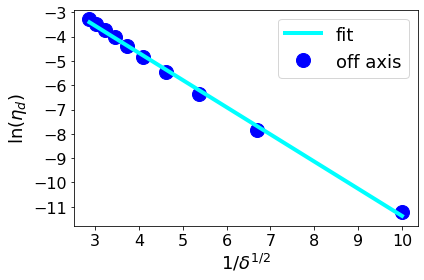

In [10]:
n_fitpts=10
Stokes_c=1.0/8.0
lnW=np.log(width_plot[0:n_fitpts])
#lnW=np.log(y_col)
delta=Stokes_plot[0:n_fitpts]-Stokes_c
one_over_root_delta=1.0/np.sqrt(delta)
#print(one_over_root_epsilon)
#print(lnW)
# fit
regress_out=linregress(one_over_root_delta,lnW)
print(regress_out)
intercept=regress_out.intercept
slope=regress_out.slope
print('eta_d A',intercept)
print('eta_d B',slope)
#
xfit=np.linspace(np.min(one_over_root_delta),np.max(one_over_root_delta),10)
yfit=intercept+slope*xfit
plt.plot(xfit,yfit,label='fit',lw=4,color='cyan')
plt.plot(one_over_root_delta,lnW,label='off axis',lw=0,marker='o',markersize=14,zorder=-5,color='blue')
plt.xlabel('$1/\delta^{1/2}$',fontsize=18)
plt.ylabel('$\ln(\eta_d)$',fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('width_scaling.png',dpi=1200)
plt.show()



#
# we need to specify the filename to be written to, this writes the data to this filename in tbe current directory
filename='eta_of_Stokes.txt'
# the numpy savetxt commands saves data in arrays
#note we need to use numpy's column_stack to put the arrays into columns
# also the fmt argument allows us to specify the format of the numbers
np.savetxt(filename,np.column_stack([Stokes_plot,width_plot]),fmt="%9.4f")

$$
\mbox{time to collide}\simeq C + \frac{D}{\epsilon^{1/2}}
$$

[5.56153798e+09 6.71217009e-01]


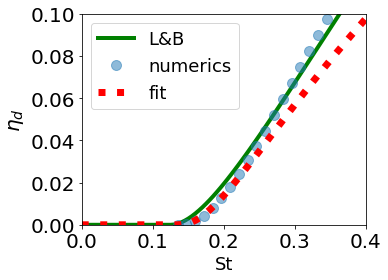

In [11]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

def etadLangB(St):
    if(St<0.125):
        lamLB=0.0
    elif(St<1.1):
        lamLB=0.466*(np.log10(8.0*St))**2
    else:
        lamLB=St/(St+np.pi/2.0)
#  
    return lamLB


    
    
#
def fitfunc(St,AA,BB):
#    if(St<0.125):
#        func=0.0
#    else:
    func=np.exp(-BB/np.sqrt(St-0.125))*(AA/(St+AA))
    return func
#
#wong55=np.loadtxt('tmp.txt')
#wong55_Stokes=2.0*(wong55[:,0])**2
#wong55_eta=wong55[:,1]
#print(wong55_Stokes)
#print(wong55_eta)
#

popt, pcov = curve_fit(fitfunc, Stokes_plot, width_plot,p0=[1.0,1.0])
AA=popt[0]
BB=popt[1]
print(popt)


npts=2000
StokesLB=np.linspace(0,10,npts)
etadLB=np.zeros(npts)
etadfit=np.zeros(npts)
for i in range(0,npts):
    etadLB[i]=etadLangB(StokesLB[i])
    if(StokesLB[i]<0.125):
        etadfit[i]=0.0
    else:
        etadfit[i]=np.exp(intercept+slope/np.sqrt(StokesLB[i]-0.125))


fig, ax1 = plt.subplots(1,figsize=(5.5, 4))
#title_string=' df '+str(df)
#fig.suptitle(title_string)
#fig.figure(figsize=(7,6))


ax1.set_xlim([0,0.4])
#ax1.set_xlim([0,4.5])
ax1.set_ylim([0,0.1])
#ax1.set_ylim([0,1])
ax1.plot(StokesLB,etadLB,lw=4,label='L&B',color='green')

ax1.plot(Stokes_plot,width_plot,label='numerics',lw=0,marker='o',ms=10,alpha=0.5)
#ax1.plot(wong55_Stokes,wong55_eta,label='Wong 55',lw=5)#,marker='o',ms=10,alpha=0.5)
#ax1.plot([0.125,0.125],[0,1],ls=':',lw=5,color='orange')#,marker='o',ms=10,alpha=0.5)

ax1.plot(StokesLB,etadfit,label='fit',color='red',lw=7,ls=':')
plt.xlabel('St',fontsize=18)
plt.ylabel('$\eta_d$',fontsize=20)
#plt.ylabel('filtration efficiency $\eta$',fontsize=20)
#print(width_plot)
plt.legend(fontsize=18,loc='upper left')
plt.tight_layout()
plt.savefig('width_vs_st.png',dpi=1200)
plt.show()

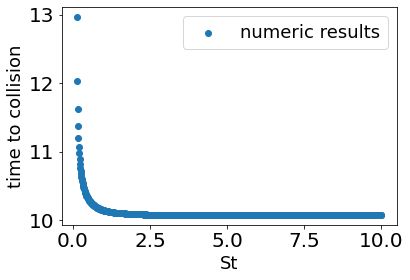

LinregressResult(slope=0.3093224253864614, intercept=9.915190030994196, rvalue=0.9987804551529907, pvalue=9.66347766682694e-12, stderr=0.0054060220520926495, intercept_stderr=0.027846248663900803)
off axis A 9.915190030994196
off axis B 0.3093224253864614


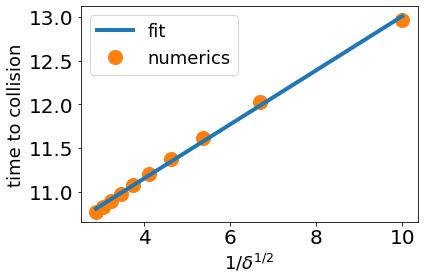

In [12]:
plt.scatter(Stokes_plot,t_col,label='numeric results')
#plt.plot(Stokes_plot,width_fit,label='fit',color='red')
plt.ylabel('time to collision',fontsize=18)
plt.xlabel('St',fontsize=18)
#print(width_plot)
plt.legend(fontsize=18)
plt.show()

# fit
regress_out=linregress(one_over_root_delta,t_col[0:n_fitpts])
print(regress_out)
intercept=regress_out.intercept
slope=regress_out.slope
print('off axis A',intercept)
print('off axis B',slope)
xfit=np.linspace(np.min(one_over_root_delta),np.max(one_over_root_delta),10)
yfit=intercept+slope*xfit
plt.plot(xfit,yfit,label='fit',lw=4)

plt.plot(one_over_root_delta,t_col[0:n_fitpts],label='numerics',lw=0,marker='o',markersize=14,zorder=-5)
#plt.plot(Stokes_plot,width_fit,label='fit',color='red')
plt.xlabel('$1/\delta^{1/2}$',fontsize=18)
plt.ylabel('time to collision',fontsize=18)
#print(width_plot)
plt.legend(fontsize=18)
plt.tight_layout()
#plt.savefig('tcol_scaling.png',dpi=1200)
plt.show()


Now study on-axis case to check scaling of time to collision with $\delta\ll1$

In [13]:
n_plot=10
Stokes_plot1D=np.linspace(0.135,0.2,n_plot)
t_col1D=np.zeros(n_plot)
for i in range(0,n_plot):
    Stokes=Stokes_plot1D[i]
    y0=0.0
    dxdt0,dydt0=u_ffinviscid(x0,y0)
    initialBC_array=np.array([x0,y0,dxdt0,dydt0])
    print('initial conditions x,y,v_x,v_y ',x0,y0,dxdt0,dydt0)
    sol0 = solve_ivp(fderivs, [0, t_max], initialBC_array, t_eval=t_eval, \
                 events=[escape],rtol=1.0e-13,atol=1.0e-13,method='RK45',max_step=1e-2)
    t_coll=sol0.t[-1]
#    print(sol0)
#
    print('time to collision          ', \
          '{:10.7f}'.format(t_coll), ' at Stokes ',round(Stokes,3))
    t_col1D[i]=t_coll
print('done')

initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           12.8220000  at Stokes  0.135
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           12.1680000  at Stokes  0.142
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           11.7960000  at Stokes  0.149
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           11.5500000  at Stokes  0.157
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           11.3700000  at Stokes  0.164
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           11.2290000  at Stokes  0.171
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           11.1150000  at Stokes  0.178
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           11.0220000  at Stokes  0.186
initial conditions x,y,v_x,v_y  -10.0 0.0 0.99 0.0
time to collision           10.9410000  at Stokes  0.193
initial conditions x,y,v_x,v

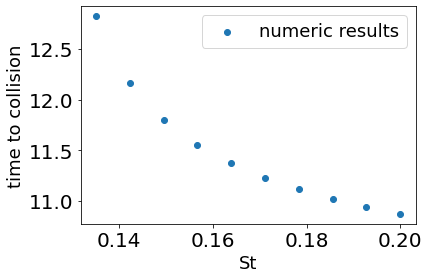

LinregressResult(slope=0.3092485668263578, intercept=9.77990777392539, rvalue=0.9987091274361882, pvalue=1.2129380975274758e-11, stderr=0.005560837013160462, intercept_stderr=0.032487130402979986)
on axis A 9.77990777392539
on axis B 0.3092485668263578


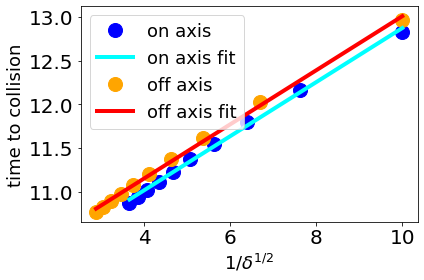

In [14]:
plt.scatter(Stokes_plot1D,t_col1D,label='numeric results')
#plt.plot(Stokes_plot,width_fit,label='fit',color='red')
plt.ylabel('time to collision',fontsize=18)
plt.xlabel('St',fontsize=18)
#print(width_plot)
plt.legend(fontsize=18)
plt.show()

delta1D=Stokes_plot1D-Stokes_c
one_over_root_delta1D=1.0/np.sqrt(delta1D)

# fit
regress_out=linregress(one_over_root_delta1D,t_col1D)
print(regress_out)
intercept=regress_out.intercept
slope=regress_out.slope
xfit1D=np.linspace(np.min(one_over_root_delta1D),np.max(one_over_root_delta1D),10)
yfit1D=intercept+slope*xfit1D
print('on axis A',intercept)
print('on axis B',slope)

plt.plot(one_over_root_delta1D,t_col1D,label='on axis',lw=0,marker='o',markersize=14,zorder=-5,color='blue')
plt.plot(xfit1D,yfit1D,label='on axis fit',lw=4,color='cyan')
#
plt.plot(one_over_root_delta,t_col[0:n_fitpts],label='off axis',lw=0,marker='o',markersize=14,zorder=-5,color='orange')
plt.plot(xfit,yfit,label='off axis fit',lw=4,color='red')

#plt.plot(Stokes_plot,width_fit,label='fit',color='red')
plt.xlabel('$1/\delta^{1/2}$',fontsize=18)
plt.ylabel('time to collision',fontsize=18)
#print(width_plot)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('tcol_scaling1D.png',dpi=1200)
plt.show()

Define a log-normal distribution for Stokes number with parameters $\mu$ and $\sigma$

$$
p({\rm St},\mu,\sigma)=\frac{1}{{\rm St}\sigma(2\pi)^{1/2}}
\exp\left[-\frac{(\ln{\rm St}-\mu)^2}{2\sigma^2}
\right]
$$

such that median St number is $\exp(\mu)$ and variance is $[\exp(\sigma^2)-1]\exp(2\mu+\sigma^2)$. Note that as (at constant air speed and obstacle radius) the Stokes number scales as particle diameter squared this is equivalent to distribution of particle diameters such that the square of the particle diameter follows a log-normal distribution.

In [15]:
def pdf_lognorm(x,mu,sigma):
    pref=1.0/(x*sigma*np.sqrt(2.0*np.pi))
    pdf=pref*np.exp(-(np.log(x)-mu)**2/(2.0*sigma**2))
    return pdf

For a distribution of particle sizes such that their Stokes numbers obey a pdf $p$, the mean filtration efficiency is

$\overline{\eta_d}({\rm St}_{MED},\sigma)=\int \eta({\rm St})p({\rm St},{\rm St}_{MED},\sigma){\rm d St}$

log-normal parameter mu 0.0 1.0
log normal sigma  0.5
variance  0.3646958540123865
std deviation  0.6039005332108811
ratio mean/median  1.1331484530668263
mean Stokes number  1.1331484530668263
std deviation/mean  0.5329403500277882
std deviation/median  0.6039005332108811
mean filtration efficiency  0.38482593680575894  for median St  1.0


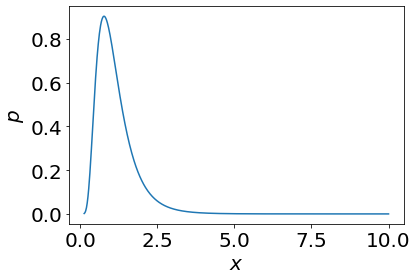

In [16]:
medianStokes=1.0
mu=np.log(medianStokes)
print('log-normal parameter mu',mu,np.exp(mu))
sigma=0.5
print('log normal sigma ',sigma)
pdf_ln=pdf_lognorm(Stokes_plot,mu,sigma)
variance=(np.exp(sigma**2)-1.0)*np.exp(2.0*mu+sigma**2)
print('variance ',variance)
std_dev=np.sqrt(variance)
print('std deviation ',std_dev)
mean=np.exp(mu+0.5*sigma**2)
mean_to_median=np.exp(0.5*sigma**2)
print('ratio mean/median ',mean_to_median)
print('mean Stokes number ',mean)
print('std deviation/mean ',std_dev/mean)
print('std deviation/median ',std_dev/medianStokes)

#
#print('pdf ',pdf_ln)
integrand_func=pdf_ln*width_plot
mean_eta=simps(integrand_func,Stokes_plot)
print('mean filtration efficiency ',mean_eta,' for median St ',medianStokes)
plt.plot(Stokes_plot,pdf_ln)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$p$',fontsize=20)
plt.show()

In [17]:

n_pts=250
medianStokes_array=np.linspace(0.001,1.5,n_pts)
mean_eta_array=np.zeros(n_pts)
mean_mass_deposit_array=np.zeros(n_pts)
for i in range(0,n_pts):
    medianStokes=medianStokes_array[i]
    mu=np.log(medianStokes)
    pdf_ln=pdf_lognorm(Stokes_plot,mu,sigma)
    integrand_func=pdf_ln*width_plot
    mean_eta_array[i]=simps(integrand_func,Stokes_plot)
    integrand_func=pdf_ln*width_plot*(Stokes_plot**1.5)
    mean_mass_deposit_array[i]=simps(integrand_func,Stokes_plot)

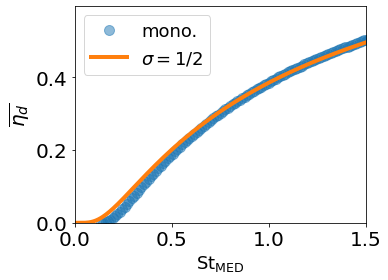

In [18]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax1 = plt.subplots(1,figsize=(5.5, 4))


ax1.plot(Stokes_plot,width_plot,label='mono.',lw=0,marker='o',ms=10,alpha=0.5)
ax1.plot(medianStokes_array,mean_eta_array,label='$\sigma=1/2$',lw=4)
ax1.set_xlim([0,np.max(medianStokes_array)])
ax1.set_ylim([0,1.2*np.max(mean_eta_array)])
ax1.legend(fontsize=18)
plt.xlabel('St$_{\mathrm{MED}}$',fontsize=18)
plt.ylabel('$\overline{\eta_d}$',fontsize=20)

plt.tight_layout()
plt.savefig('poly_eta.png',dpi=1200)
plt.show()

For a distribution of particle sizs such that their Stokes numbers obey a pdf $p$, a quantity proportional to mass deposited is

${\rm mass}({\rm St}_{med},\sigma)=\int \eta({\rm St})p({\rm St},{\rm St}_{med},\sigma){\rm St}^{3/2}{\rm d St}$

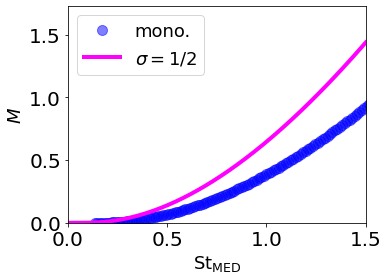

In [19]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax1 = plt.subplots(1,figsize=(5.5, 4))



ax1.plot(Stokes_plot,width_plot*Stokes_plot**1.5,label='mono.',lw=0,marker='o',ms=10,alpha=0.5,color='blue')

ax1.plot(medianStokes_array,mean_mass_deposit_array,label='$\sigma=1/2$',lw=4,color='magenta')
plt.xlim([0,np.max(medianStokes_array)])
plt.ylim([0,1.2*np.max(mean_mass_deposit_array)])
plt.legend(fontsize=18)
plt.xlabel('St$_{\mathrm{MED}}$',fontsize=18)
plt.ylabel('$M$',fontsize=18)

plt.tight_layout()
plt.savefig('poly_mass.png',dpi=1200)
plt.show()